In [339]:
# Importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import spacy
import random
nlp = spacy.load('en_core_web_sm')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, random_split

In [340]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [341]:
trainPosPath = open("./Data/Ass4/Assignment4aDataset.txt",'r')
posList = trainPosPath.read().split("\n")
posList = posList[:len(posList)-1]

In [342]:
weeknames = {'mon','monday','tue','tuesday','wed','wednesday','thu','thursday','fri','friday','sat','saturday','sun','sunday'}

In [343]:
human_date = []
machine_date = []
for i in posList:
  temp_Xy = i.split(", ")
  # if(len(temp_Xy) > 2):              #For checking if there are commas(,) in input/output text
  #   print(i)
  human_date.append(temp_Xy[0])
  machine_date.append(temp_Xy[1])

print(len(human_date))
print(len(machine_date))

40000
40000


In [344]:
print(human_date[6])
print(machine_date[6])

human_date_new = np.char.lower(np.char.replace(human_date,"'",""))

# Adding Start(<) and End(>)
# for i in range(len(machine_date)):
#   machine_date[i] = "<" + machine_date[i] + ">"

machine_date_new = np.char.lower(np.char.replace(machine_date,"'",""))

print(human_date_new.shape)
print(machine_date_new.shape)

print(human_date_new[6])
print(machine_date_new[6])

target_len = len(machine_date_new[0])
print(target_len)

'wed 1776 11 september'
'1776-09-11'
(40000,)
(40000,)
wed 1776 11 september
1776-09-11
10


In [345]:
def find_vocab(corpus):
  vocab = set()
  for document in corpus:
    vocab = vocab.union(set(document))
  return vocab

In [346]:
input_vocab = list(find_vocab(human_date_new))
output_vocab = list(find_vocab(machine_date_new))

input_vocab.sort()
output_vocab.sort()

input_vocab_size = len(input_vocab)
output_vocab_size = len(output_vocab)

print(input_vocab)
print(output_vocab)

[' ', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']
['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Getting GloVe Embeddings

In [347]:
embeddingsGloVe = {}
with open("./Data/glove.6B.300d.txt", 'r', encoding="utf-8") as wordEmbeddings:
  for line in wordEmbeddings:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embeddingsGloVe[word]=vector
embeddingsGloVe[" "] = np.zeros((300),'float32')            #Adding embeddings for ' '

Fuctions for PreProcessing

In [348]:
def to_hardmax_vec(num, max_num):
  res = np.zeros(max_num)
  res[num] = 1
  return res

# Creating dictonaries for input_vocab
input_index_to_char = dict()
input_hardmax_dict = dict()
for i, item in enumerate(input_vocab):
  input_index_to_char[i] = item
  input_hardmax_dict[item] = to_hardmax_vec(i,input_vocab_size)

# Creating dictonaries for output_vocab
output_index_to_char = dict()
output_hardmax_dict = dict()
for i, item in enumerate(output_vocab):
  output_index_to_char[i] = item
  output_hardmax_dict[item] = to_hardmax_vec(i,output_vocab_size)

print(input_index_to_char)
# print(input_hardmax_dict)
print(output_index_to_char)
# print(output_hardmax_dict)

{0: ' ', 1: '/', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9', 12: 'a', 13: 'b', 14: 'c', 15: 'd', 16: 'e', 17: 'f', 18: 'g', 19: 'h', 20: 'i', 21: 'j', 22: 'l', 23: 'm', 24: 'n', 25: 'o', 26: 'p', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'y'}
{0: '-', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9'}


In [349]:
def human_date_to_char_list(sample):
  #Tokeninzing
  tokens = sample.split("\\")
  filtered_tokens = []
  for i in tokens:
    if i not in weeknames:
      filtered_tokens.append(i)
  # print(filtered_tokens)
  # ->Filtered Token; len == 1(['21/03/2046']) or len == 3(['22', 'december', '1600'])

  # Converting filtered token to list of char
  char_list = []
  n = len(filtered_tokens)
  for i in range(n):
    curr_char_list = list(filtered_tokens[i])
    if(i != n-1):
      curr_char_list.append(' ')
    char_list.extend(curr_char_list)
  # print(char_list)
  return char_list


def char_list_to_vector(char_list, max_len):
  # Padding
  curr_len = len(char_list)
  for i in range(max_len-curr_len):
    char_list.append(' ')
  
  # Replacing chars by GloVe Embeddings  
  vector_date_rep = []
  for i in char_list:
    vector_date_rep.append(embeddingsGloVe[i])
  
  return vector_date_rep

def machine_date_to_hardmax(sample):
  char_list = list(sample)
  vector_date_rep = []
  for i in char_list:
    vector_date_rep.append(output_hardmax_dict[i]);
  return vector_date_rep

def machine_date_to_embeddings(sample):
  char_list = list(sample)
  vector_date_rep = []
  for i in char_list:
    vector_date_rep.append(embeddingsGloVe[i]);
  return vector_date_rep

In [350]:
complete_char_list = [human_date_to_char_list(sample) for sample in human_date_new]
max_len = 0
for char_list in complete_char_list:
  max_len = max(max_len, len(char_list))

train_X = [char_list_to_vector(char_list,max_len) for char_list in complete_char_list]
train_X = np.array(train_X)
print(train_X.shape)

train_y_embeddings = [machine_date_to_embeddings(sample) for sample in machine_date_new]
train_y_embeddings = np.array(train_y_embeddings)
print(train_y_embeddings.shape)

train_y_hardmax = [machine_date_to_hardmax(sample) for sample in machine_date_new]
train_y_hardmax = np.array(train_y_hardmax)
print(train_y_hardmax.shape)

# train_y; first 300 features -> GloVe Embeddings, next 11 -> One Hot Encoding
train_y = np.concatenate((train_y_embeddings,train_y_hardmax), axis = 2)
print(train_y.shape)

(40000, 27, 300)
(40000, 10, 300)
(40000, 10, 11)
(40000, 10, 311)


In [351]:
n_samples = train_X.shape[0]
# HyperParameters
batch_size = 100

Creating DataLoader

In [352]:
train_X = torch.Tensor(train_X)
train_y = torch.Tensor(train_y)

# train_y = train_y.type(torch.LongTensor)
train_tensor_Xy = TensorDataset(train_X,train_y)

train_size = int(n_samples*(0.9))
val_size = n_samples - train_size
train_data, valid_data = random_split(train_tensor_Xy, [train_size,val_size])

train_data_loader = DataLoader(train_data, batch_size = batch_size)
valid_data_loader = DataLoader(valid_data, batch_size = batch_size)

Class for **Encoder**

In [353]:
class encoder(nn.Module):
  def __init__(self,input_size, hidden_size, num_layers=1):
    super(encoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # define LSTM layer
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)

  def forward(self, x_input):
    lstm_out, self.hidden = self.lstm(x_input)
    return lstm_out, self.hidden   

  def init_hidden(self, batch_size):
    return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
            torch.zeros(self.num_layers, batch_size, self.hidden_size))  

Class for Decoder

In [354]:
class decoder(nn.Module):
  def __init__(self,input_size, hidden_size, output_size, num_layers=1):
    super(decoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers

    # define LSTM layer
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
    self.linear_recursive = nn.Linear(hidden_size, input_size)              # for recursive inputs
    self.linear_softmax = nn.Linear(hidden_size, output_size)               # for softmax output and calc loss
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x_input, hidden_state):
    x_input = x_input.float()
    lstm_out, self.hidden = self.lstm(x_input.unsqueeze(1),hidden_state)
    output_recursive = self.linear_recursive(lstm_out.squeeze(1))
    output_softmax = self.linear_softmax(lstm_out.squeeze(1))
    output_softmax = self.softmax(output_softmax)
    return output_softmax, output_recursive, self.hidden

Class for **Encoder-Decoder**

In [355]:
class seq_to_seq(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(seq_to_seq, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size

    self.encoder = encoder(input_size = input_size, hidden_size = hidden_size).to(device)
    self.decoder = decoder(input_size = input_size, hidden_size = hidden_size, output_size = output_vocab_size).to(device)

    self.train_loss_list_plotting = []
    self.valid_loss_list_plotting = []

    self.train_accuracy_plotting = []
    self.valid_accuracy_plotting = []

    self.train_charwise_accuracy_plotting = []
    self.valid_charwise_accuracy_plotting = []
  
  def forward_encoder_decoder(self, batch, target_len, teacher_forcing_ratio, batch_size):
    x, y = batch
    x = x.to(device)
    y = y.to(device)

    # ENCODER SIDE
    # outputs tensor for calculating loss and 
    outputs = torch.zeros(batch_size, 0, self.decoder.output_size).to(device)

    # Initializing Hidden State
    encoder_initial_hidden_state = self.encoder.init_hidden(batch_size)

    # Encoder Outputs
    encoder_output, encoder_hidden_state = self.encoder(x)

    y_embeddings = y[:,:,:300] 
    y_hardmax = y[:,:,300:]

    # DECODER SIDE
    # Initializing Input & Hidden State for Decoder
    decoder_input = y_embeddings[:,0,:]
    decoder_hidden = encoder_hidden_state

    # First input to decoder is true character at time-step 0
    for t in range(target_len):

      output_softmax, output_recursive, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
      outputs = torch.cat((outputs,output_softmax.unsqueeze(1)),axis = 1)
      # predict with teacher forcing
      if (t < target_len-1):
        if random.random() < teacher_forcing_ratio:
          decoder_input = y_embeddings[:, t+1, :]
        # predict recursively 
        else:
          decoder_input = output_recursive

    return outputs, y_hardmax

  def find_accuracy_batch(self,true_y,pred_y):
    true_y = torch.argmax(true_y, dim=2)
    pred_y = torch.argmax(pred_y, dim=2)
    compared_ys = (true_y == pred_y)
    compared_ys = torch.sum(compared_ys, axis = 1, keepdims = True)
    real_ys = torch.full((batch_size,1), 10).to(device)
    return torch.sum(compared_ys >= real_ys)/compared_ys.shape[0]

  def find_charwise_accuracy_batch(self,true_y,pred_y):
    true_y = torch.argmax(true_y, dim=2)
    pred_y = torch.argmax(pred_y, dim=2)
    compared_ys = (true_y == pred_y)
    return torch.sum(compared_ys)/(compared_ys.shape[0] * compared_ys.shape[1])

  def print_date(self, true_y, pred_y):
    true_y = torch.argmax(true_y, dim=2)
    pred_y = torch.argmax(pred_y, dim=2)
    
    # Bringing it back to CPU
    true_y = true_y.detach().cpu().numpy()
    pred_y = pred_y.detach().cpu().numpy()
    for i in range(true_y.shape[0]):
      true_date = ""
      pred_date = ""
      for j in range(true_y.shape[1]):
        true_date += output_index_to_char[true_y[i][j]]
        pred_date += output_index_to_char[pred_y[i][j]]
      print(true_date , "->", pred_date)
        
  def fit(self, train_data_loader, valid_data_loader, n_epochs, target_len, batch_size, teacher_forcing_ratio = 0.5, learning_rate = 0.01):
    train_loss_list = []
    val_loss_list = []

    optimizer = optim.SGD(self.parameters(), lr = learning_rate)
    loss_function = nn.CrossEntropyLoss()

    n_batches = int(train_X.shape[0]/batch_size)

    for i in range(n_epochs):
      train_loss_list_batch = []
      valid_loss_list_batch = []
      train_accuracy_list_batch = []
      valid_accuracy_list_batch = []
      train_charwise_accuracy_list_batch = []
      valid_charwise_accuracy_list_batch = []
      
      for batch in train_data_loader:
        # Forward Function for complete architecture
        pred_y, true_y = self.forward_encoder_decoder(batch, target_len, teacher_forcing_ratio, batch_size)

        # compute the loss
        true_y = true_y.float()
        loss = loss_function(pred_y, true_y)
        curr_batch_train_loss = loss.item()

        train_loss_list_batch.append(curr_batch_train_loss)
        train_accuracy_list_batch.append(self.find_accuracy_batch(true_y,pred_y))
        train_charwise_accuracy_list_batch.append(self.find_charwise_accuracy_batch(true_y,pred_y))
        
        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()
        optimizer.step()
      
      for batch in valid_data_loader:
        with torch.no_grad():
          pred_y, true_y = self.forward_encoder_decoder(batch, target_len, teacher_forcing_ratio, batch_size)
          true_y = true_y.float()
          self.print_date(true_y, pred_y)
          loss = loss_function(pred_y, true_y)
          curr_batch_valid_loss = loss.item()

        valid_loss_list_batch.append(curr_batch_valid_loss)
        valid_accuracy_list_batch.append(self.find_accuracy_batch(true_y,pred_y))
        valid_charwise_accuracy_list_batch.append(self.find_charwise_accuracy_batch(true_y,pred_y))

      # loss for epoch 
      train_loss_epoch = torch.tensor(train_loss_list_batch).mean()
      valid_loss_epoch = torch.tensor(valid_loss_list_batch).mean()

      train_accuracy_epoch = torch.tensor(train_accuracy_list_batch).mean()
      valid_accuracy_epoch = torch.tensor(valid_accuracy_list_batch).mean()
      
      train_charwise_accuracy_epoch = torch.tensor(train_charwise_accuracy_list_batch).mean()
      valid_charwise_loss_epoch = torch.tensor(valid_charwise_accuracy_list_batch).mean()
      
      print('\033[1m', "Epoch Number = ", i, '\033[0m')
      print("Training Loss = ", float(train_loss_epoch), "; Validation Loss = ", float(valid_loss_epoch))
      print("Train Accuracy = ", float(train_accuracy_epoch)*100, "%; Validation Accuracy = ", float(valid_accuracy_epoch)*100, "%")
      print("Train Charwise Accuracy = ", float(train_charwise_accuracy_epoch)*100, "%; ", "; Validation Charwise Accuracy = ", float(valid_charwise_loss_epoch)*100, "%")
      
      self.train_loss_list_plotting.append(train_loss_epoch)
      self.valid_loss_list_plotting.append(valid_loss_epoch)
  
  def predict(self, test_data_loader):
    pass

  def plot_loss_curve(self, flag):
    x = [(i+1) for i in range(len(self.train_loss_list_plotting))]
    plt.xlabel('#Epoch')
    plt.ylabel('Loss')
    temp_str = "Loss curve for "
    if(flag == 0):
        temp_str += "Train Data"
        plt.plot(x,self.train_loss_list_plotting)
    else:
        temp_str += "Validation Data"
        plt.plot(x,self.valid_loss_list_plotting)
    plt.title(temp_str)
    plt.show()

In [356]:
# specify model parameters and train
n_epochs = 50
lr = 0.005
model = seq_to_seq(input_size = train_X.shape[2], hidden_size = 128).to(device)
model.fit(train_data_loader, valid_data_loader, n_epochs = n_epochs, target_len = target_len, batch_size = batch_size, teacher_forcing_ratio = 0.5, learning_rate = lr)

1828-01-14 -> 6666666666
1579-12-13 -> 6666666666
1973-08-04 -> 6666666666
1835-02-22 -> 6666666666
1944-03-29 -> 6666666666
1936-02-08 -> 6666666666
1934-06-10 -> 6666666666
1819-12-18 -> 6666666666
1590-04-22 -> 6666666666
1780-11-03 -> 6666666666
1610-10-24 -> 6666666666
1654-02-27 -> 6666666666
2007-06-30 -> 6666666666
1725-02-14 -> 6666666666
1806-06-27 -> 6666666666
2009-06-09 -> 6666666666
1795-09-12 -> 6666666666
1792-06-29 -> 6666666666
1677-04-03 -> 6666666666
1695-02-25 -> 6666666666
1891-02-28 -> 6666666666
1535-04-29 -> 6666666666
1574-11-21 -> 6666666666
1540-07-08 -> 6666666666
1940-01-26 -> 6666666666
1575-05-29 -> 6666666666
1877-04-01 -> 6666666666
1629-08-30 -> 6666666666
1824-12-12 -> 6666666666
1531-04-04 -> 6666666666
1558-12-10 -> 6666666666
1567-06-13 -> 6666666666
1701-10-28 -> 6666666666
1702-05-23 -> 6666666666
1870-01-09 -> 6666666666
1882-11-19 -> 6666666666
1546-09-02 -> 6666666666
1748-01-06 -> 6666666666
1576-08-10 -> 6666666666
1565-11-10 -> 6666666666


1890-11-15 -> 6666666776
1769-02-08 -> 6666666466
2024-09-03 -> 6666666766
1846-01-03 -> 6666666766
2051-07-01 -> 6666666726
1987-11-16 -> 6666666776
1544-02-17 -> 6666666766
1874-07-23 -> 6666666776
1921-04-18 -> 6666666766
1857-03-22 -> 6666666476
1909-10-26 -> 6666666776
2033-03-04 -> 6666666726
2039-01-07 -> 6666666466
2056-03-09 -> 6666666466
1941-01-27 -> 6666666776
1867-12-21 -> 6666666776
1640-03-24 -> 6666666476
1615-07-08 -> 6666666466
1764-03-25 -> 6666666776
2070-06-05 -> 6666666466
1655-01-04 -> 6666666466
1704-08-15 -> 6666666766
1839-03-28 -> 6666666476
2025-02-28 -> 6666666476
1893-09-21 -> 6666666776
1568-10-22 -> 6666666776
2029-07-09 -> 6666666466
1631-03-09 -> 6666666726
1710-06-19 -> 6666666466
1714-11-07 -> 6666666726
1641-12-09 -> 6666666726
1886-05-12 -> 6666666766
2033-01-13 -> 6666666766
1799-07-29 -> 6666666476
1892-03-15 -> 6666666766
1678-07-18 -> 6666666466
2017-08-13 -> 6666666466
1537-01-27 -> 6666666476
1723-01-21 -> 6666666776
1811-06-30 -> 6666666776


1781-09-11 -> 6666776776
1652-03-30 -> 6666776776
1572-07-15 -> 6666776776
2015-08-02 -> 6666776776
1828-05-11 -> 6666776776
1955-02-17 -> 6666776776
1762-12-13 -> 6666776776
1690-07-20 -> 6666776776
1832-03-04 -> 6666776776
1720-02-18 -> 6666776776
1666-12-30 -> 6666776776
2048-02-07 -> 6666776776
1921-02-03 -> 6666776776
2066-05-20 -> 6666776776
1982-04-01 -> 6666776776
1680-09-14 -> 6666776776
1864-06-13 -> 6666776776
1928-03-26 -> 6666776776
2051-05-11 -> 6666776776
2002-04-23 -> 6666466486
1828-02-03 -> 6666776776
1965-10-24 -> 6666776776
1909-10-11 -> 6666466486
1666-03-29 -> 6666776776
1700-06-24 -> 6666466486
1779-01-30 -> 6666776776
1895-12-24 -> 6666776776
1618-06-04 -> 6666776776
1780-04-28 -> 6666776776
1701-07-06 -> 6666466486
1935-01-04 -> 6666776776
1965-03-12 -> 6666776776
1536-11-07 -> 6666776776
1869-05-12 -> 6666776776
1901-11-07 -> 6666466486
1815-08-18 -> 6666776776
1926-09-26 -> 6666776776
1923-01-21 -> 6666776776
1773-08-06 -> 6666776776
1632-04-28 -> 6666776776


1985-09-30 -> 6666726476
1971-07-10 -> 6666726466
1717-01-24 -> 6666726476
1985-08-10 -> 6666726466
1534-05-26 -> 6666726476
1534-07-15 -> 6666726466
1889-05-25 -> 6666726476
1704-04-06 -> 6666426426
1726-02-04 -> 6666726426
1575-10-31 -> 6666776776
1687-11-21 -> 6666776776
1824-05-19 -> 6666726466
1632-01-17 -> 6666726466
1844-09-07 -> 6666726426
1931-06-19 -> 6666726466
1744-09-16 -> 6666726466
1934-07-15 -> 6666726466
1669-02-18 -> 6666726466
1860-03-01 -> 6666726426
1591-03-15 -> 6666726466
1551-05-31 -> 6666726476
2064-11-24 -> 6666776776
1787-01-22 -> 6666726476
1792-04-02 -> 6666726426
2013-01-15 -> 6666726466
1946-03-11 -> 6666726466
1998-01-11 -> 6666726466
1720-03-15 -> 6666726466
1809-02-19 -> 6666426466
1529-01-06 -> 6666726426
1688-02-15 -> 6666726466
1997-06-04 -> 6666726426
1685-02-16 -> 6666726466
1561-12-23 -> 6666776776
2062-03-12 -> 6666726466
1524-05-07 -> 6666726426
1659-02-22 -> 6666726476
1635-04-28 -> 6666726476
1977-09-19 -> 6666726466
1928-01-21 -> 6666726476


1828-01-14 -> 6666726476
1579-12-13 -> 6666776776
1973-08-04 -> 6666726476
1835-02-22 -> 6666726476
1944-03-29 -> 6666726476
1936-02-08 -> 6666726476
1934-06-10 -> 6666726476
1819-12-18 -> 6666776776
1590-04-22 -> 6666726476
1780-11-03 -> 6666776776
1610-10-24 -> 6666776776
1654-02-27 -> 6666726476
2007-06-30 -> 6666726476
1725-02-14 -> 6666726476
1806-06-27 -> 6666726476
2009-06-09 -> 6666726476
1795-09-12 -> 6666726476
1792-06-29 -> 6666726476
1677-04-03 -> 6666726476
1695-02-25 -> 6666726476
1891-02-28 -> 6666726476
1535-04-29 -> 6666726476
1574-11-21 -> 6666776776
1540-07-08 -> 6666726476
1940-01-26 -> 6666726476
1575-05-29 -> 6666726476
1877-04-01 -> 6666726476
1629-08-30 -> 6666726476
1824-12-12 -> 6666776776
1531-04-04 -> 6666726476
1558-12-10 -> 6666776776
1567-06-13 -> 6666726476
1701-10-28 -> 6666776776
1702-05-23 -> 6666726476
1870-01-09 -> 6666726476
1882-11-19 -> 6666776776
1546-09-02 -> 6666726476
1748-01-06 -> 6666726476
1576-08-10 -> 6666726476
1565-11-10 -> 6666776776


1568-10-22 -> 6666666776
2029-07-09 -> 6666666446
1631-03-09 -> 6666666446
1710-06-19 -> 6666666466
1714-11-07 -> 6666666726
1641-12-09 -> 6666666726
1886-05-12 -> 6666666466
2033-01-13 -> 6666666466
1799-07-29 -> 6666666476
1892-03-15 -> 6666666466
1678-07-18 -> 6666666466
2017-08-13 -> 6666666466
1537-01-27 -> 6666666476
1723-01-21 -> 6666666476
1811-06-30 -> 6666666476
1811-01-12 -> 6666666466
1914-08-25 -> 6666666476
1744-10-23 -> 6666666776
2025-08-11 -> 6666666466
2029-07-26 -> 6666666476
1952-12-04 -> 6666666726
1542-10-02 -> 6666666726
1845-09-08 -> 6666666446
1535-11-14 -> 6666666776
1802-02-19 -> 6666666466
1981-09-02 -> 6666666446
1825-11-28 -> 6666666776
1909-10-12 -> 6666666776
1787-12-28 -> 6666666776
1982-06-10 -> 6666666466
1757-09-19 -> 6666666466
1767-10-25 -> 6666666776
1594-09-18 -> 6666666466
1723-07-27 -> 6666666476
1803-09-12 -> 6666666466
1968-09-09 -> 6666666446
1679-06-18 -> 6666666466
1907-12-18 -> 6666666776
1808-02-16 -> 6666666466
1823-10-30 -> 6666666776


2033-07-10 -> 6666726-66
1705-09-19 -> 6666726766
1903-11-29 -> 6666776776
1824-11-18 -> 6666776776
1538-11-10 -> 6666776776
1665-04-19 -> 6666726776
1807-08-22 -> 6666766766
2060-03-12 -> 6666466-76
1849-08-05 -> 6666766776
1792-12-22 -> 6666776776
1641-04-20 -> 6666726776
1842-08-04 -> 6666726776
1641-09-11 -> 6666726776
1772-01-24 -> 6666726776
1933-12-03 -> 6666776776
1855-07-23 -> 6666726-66
1531-02-02 -> 6666726776
1858-01-12 -> 6666766776
1571-05-02 -> 6666726776
1886-07-01 -> 6666726766
1779-04-28 -> 6666766776
1610-01-12 -> 6666466776
1530-09-23 -> 6666466-66
1834-08-14 -> 6666726776
1574-04-26 -> 6666726776
1852-04-09 -> 6666726776
1864-10-25 -> 6666776-66
1995-09-19 -> 6666726766
1732-10-29 -> 6666776-66
2027-10-28 -> 6666766-66
1714-08-05 -> 6666726776
1559-02-12 -> 6666766776
1672-09-08 -> 6666726776
1781-09-11 -> 6666726776
1652-03-30 -> 6666666776
1572-07-15 -> 6666666776
2015-08-02 -> 6666666726
1828-05-11 -> 6666666776
1955-02-17 -> 6666666776
1762-12-13 -> 6666666776


2047-10-17 -> 6666766-66
1831-06-12 -> 6666726776
1678-03-07 -> 6666726776
1974-02-24 -> 6666726776
2067-12-08 -> 6666766776
1620-01-09 -> 6666466776
1684-12-07 -> 6666776776
1541-06-07 -> 6666726776
1669-01-31 -> 6666726776
1713-08-06 -> 6666726776
1749-01-26 -> 6666766776
1985-09-30 -> 6666666666
1971-07-10 -> 6666666666
1717-01-24 -> 6666666666
1985-08-10 -> 6666666666
1534-05-26 -> 6666666666
1534-07-15 -> 6666666666
1889-05-25 -> 6666666666
1704-04-06 -> 6666666666
1726-02-04 -> 6666666666
1575-10-31 -> 6666666666
1687-11-21 -> 6666666666
1824-05-19 -> 6666666666
1632-01-17 -> 6666666666
1844-09-07 -> 6666666666
1931-06-19 -> 6666666666
1744-09-16 -> 6666666666
1934-07-15 -> 6666666666
1669-02-18 -> 6666666666
1860-03-01 -> 6666666666
1591-03-15 -> 6666666666
1551-05-31 -> 6666666666
2064-11-24 -> 6666666666
1787-01-22 -> 6666666666
1792-04-02 -> 6666666666
2013-01-15 -> 6666666666
1946-03-11 -> 6666666666
1998-01-11 -> 6666666666
1720-03-15 -> 6666666666
1809-02-19 -> 6666666666


1828-01-14 -> 6666776666
1579-12-13 -> 6666776666
1973-08-04 -> 6666776666
1835-02-22 -> 6666776666
1944-03-29 -> 6666776666
1936-02-08 -> 6666776666
1934-06-10 -> 6666776666
1819-12-18 -> 6666776666
1590-04-22 -> 6666776666
1780-11-03 -> 6666776666
1610-10-24 -> 6666776666
1654-02-27 -> 6666776666
2007-06-30 -> 6666776666
1725-02-14 -> 6666776666
1806-06-27 -> 6666776666
2009-06-09 -> 6666776666
1795-09-12 -> 6666776666
1792-06-29 -> 6666776666
1677-04-03 -> 6666776666
1695-02-25 -> 6666776666
1891-02-28 -> 6666776666
1535-04-29 -> 6666776666
1574-11-21 -> 6666776666
1540-07-08 -> 6666776666
1940-01-26 -> 6666776666
1575-05-29 -> 6666776666
1877-04-01 -> 6666776666
1629-08-30 -> 6666776666
1824-12-12 -> 6666776666
1531-04-04 -> 6666776666
1558-12-10 -> 6666776666
1567-06-13 -> 6666776666
1701-10-28 -> 6666776666
1702-05-23 -> 6666776666
1870-01-09 -> 6666776666
1882-11-19 -> 6666776666
1546-09-02 -> 6666776666
1748-01-06 -> 6666776666
1576-08-10 -> 6666776666
1565-11-10 -> 6666776666


2017-08-13 -> 6666666666
1537-01-27 -> 6666666666
1723-01-21 -> 6666666666
1811-06-30 -> 6666666666
1811-01-12 -> 6666666666
1914-08-25 -> 6666666666
1744-10-23 -> 6666666666
2025-08-11 -> 6666666666
2029-07-26 -> 6666666666
1952-12-04 -> 6666666666
1542-10-02 -> 6666666666
1845-09-08 -> 6666666666
1535-11-14 -> 6666666666
1802-02-19 -> 6666666666
1981-09-02 -> 6666666666
1825-11-28 -> 6666666666
1909-10-12 -> 6666666666
1787-12-28 -> 6666666666
1982-06-10 -> 6666666666
1757-09-19 -> 6666666666
1767-10-25 -> 6666666666
1594-09-18 -> 6666666666
1723-07-27 -> 6666666666
1803-09-12 -> 6666666666
1968-09-09 -> 6666666666
1679-06-18 -> 6666666666
1907-12-18 -> 6666666666
1808-02-16 -> 6666666666
1823-10-30 -> 6666666666
1536-05-20 -> 6666666666
1780-08-29 -> 6666666666
1857-05-14 -> 6666666666
1592-11-04 -> 6666666666
1694-05-22 -> 6666666666
1600-09-24 -> 6666666666
1664-01-24 -> 6666666666
1572-04-12 -> 6666666666
1562-12-17 -> 6666666666
1547-04-16 -> 6666666666
1978-09-14 -> 6666666666


1652-03-30 -> 6666666666
1572-07-15 -> 6666666666
2015-08-02 -> 6666666666
1828-05-11 -> 6666666666
1955-02-17 -> 6666666666
1762-12-13 -> 6666666666
1690-07-20 -> 6666666666
1832-03-04 -> 6666666666
1720-02-18 -> 6666666666
1666-12-30 -> 6666666666
2048-02-07 -> 6666666666
1921-02-03 -> 6666666666
2066-05-20 -> 6666666666
1982-04-01 -> 6666666666
1680-09-14 -> 6666666666
1864-06-13 -> 6666666666
1928-03-26 -> 6666666666
2051-05-11 -> 6666666666
2002-04-23 -> 6666666666
1828-02-03 -> 6666666666
1965-10-24 -> 6666666666
1909-10-11 -> 6666666666
1666-03-29 -> 6666666666
1700-06-24 -> 6666666666
1779-01-30 -> 6666666666
1895-12-24 -> 6666666666
1618-06-04 -> 6666666666
1780-04-28 -> 6666666666
1701-07-06 -> 6666666666
1935-01-04 -> 6666666666
1965-03-12 -> 6666666666
1536-11-07 -> 6666666666
1869-05-12 -> 6666666666
1901-11-07 -> 6666666666
1815-08-18 -> 6666666666
1926-09-26 -> 6666666666
1923-01-21 -> 6666666666
1773-08-06 -> 6666666666
1632-04-28 -> 6666666666
2024-05-17 -> 6666666666


1750-07-29 -> 6666666666
1970-03-24 -> 6666666666
1930-08-15 -> 6666666666
1717-06-06 -> 6666666666
1835-02-23 -> 6666666666
1943-08-16 -> 6666666666
1816-08-30 -> 6666666666
2062-10-03 -> 6666666666
2038-07-27 -> 6666666666
1544-01-09 -> 6666666666
1793-10-02 -> 6666666666
1621-05-07 -> 6666666666
1622-06-15 -> 6666666666
1821-09-04 -> 6666666666
1611-06-10 -> 6666666666
1631-12-02 -> 6666666666
1762-04-12 -> 6666666666
1804-03-13 -> 6666-26666
1825-12-12 -> 6666776666
1744-08-24 -> 6666726666
1567-03-18 -> 6666726666
1754-07-29 -> 6666726666
1882-09-12 -> 6666726666
1669-12-31 -> 6666776666
1623-05-27 -> 6666726666
1727-06-05 -> 6666726666
1813-02-17 -> 6666726666
1929-07-18 -> 6666726666
1654-06-03 -> 6666726666
1867-03-07 -> 6666726666
1542-10-12 -> 6666776666
2065-05-29 -> 6666726666
1659-12-23 -> 6666776666
1676-02-05 -> 6666726666
1674-08-13 -> 6666726666
1819-04-27 -> 6666726666
1977-08-14 -> 6666726666
1650-10-07 -> 6666776666
1839-09-04 -> 6666726666
1595-01-28 -> 6666726666


1828-01-14 -> 6666726-76
1579-12-13 -> 6666-66-76
1973-08-04 -> 6666-26-76
1835-02-22 -> 6666726-76
1944-03-29 -> 6666726-76
1936-02-08 -> 6666726-76
1934-06-10 -> 6666726-76
1819-12-18 -> 6666716-76
1590-04-22 -> 6666-66-66
1780-11-03 -> 6666-66-76
1610-10-24 -> 6666-66-66
1654-02-27 -> 6666726-76
2007-06-30 -> 6666-66-76
1725-02-14 -> 6666726-76
1806-06-27 -> 6666-26-76
2009-06-09 -> 6666-66-76
1795-09-12 -> 6666726-76
1792-06-29 -> 6666726-76
1677-04-03 -> 6666-66-76
1695-02-25 -> 6666726-76
1891-02-28 -> 6666726-76
1535-04-29 -> 6666726-76
1574-11-21 -> 6666-71-76
1540-07-08 -> 6666-26-66
1940-01-26 -> 6666-26-76
1575-05-29 -> 6666726-76
1877-04-01 -> 6666-66-76
1629-08-30 -> 6666726-76
1824-12-12 -> 6666716-76
1531-04-04 -> 6666726-76
1558-12-10 -> 6666776-76
1567-06-13 -> 6666-66-76
1701-10-28 -> 6666-16-66
1702-05-23 -> 6666-26-76
1870-01-09 -> 6666-66-76
1882-11-19 -> 6666771-76
1546-09-02 -> 6666726-76
1748-01-06 -> 6666726-76
1576-08-10 -> 6666-26-76
1565-11-10 -> 6666771-76


1744-10-23 -> 6666666-66
2025-08-11 -> 6666666-66
2029-07-26 -> 6666666-66
1952-12-04 -> 6666666776
1542-10-02 -> 6666666-66
1845-09-08 -> 6666666-66
1535-11-14 -> 6666666776
1802-02-19 -> 6666666-66
1981-09-02 -> 6666666-66
1825-11-28 -> 6666666776
1909-10-12 -> 6666666-66
1787-12-28 -> 6666666776
1982-06-10 -> 6666666-76
1757-09-19 -> 6666666-66
1767-10-25 -> 6666666-66
1594-09-18 -> 6666666-66
1723-07-27 -> 6666666-66
1803-09-12 -> 6666666-66
1968-09-09 -> 6666666-66
1679-06-18 -> 6666666-76
1907-12-18 -> 6666666-76
1808-02-16 -> 6666666-66
1823-10-30 -> 6666666-66
1536-05-20 -> 6666666-66
1780-08-29 -> 6666666-66
1857-05-14 -> 6666666-66
1592-11-04 -> 6666776-76
1694-05-22 -> 6666776-76
1600-09-24 -> 6666-76-76
1664-01-24 -> 6666776-76
1572-04-12 -> 6666-76-76
1562-12-17 -> 6666776-76
1547-04-16 -> 6666-76-76
1978-09-14 -> 6666-76-76
1788-02-04 -> 6666-76-76
1557-12-25 -> 6666776-76
1711-06-09 -> 6666-76-76
1770-02-16 -> 6666-76-76
1658-07-17 -> 6666776-76
1927-07-14 -> 6666-76-76


1652-03-30 -> 6666666666
1572-07-15 -> 6666666666
2015-08-02 -> 6666666666
1828-05-11 -> 6666666666
1955-02-17 -> 6666666666
1762-12-13 -> 6666666666
1690-07-20 -> 6666666666
1832-03-04 -> 6666666666
1720-02-18 -> 6666666666
1666-12-30 -> 6666666666
2048-02-07 -> 6666666666
1921-02-03 -> 6666666666
2066-05-20 -> 6666666666
1982-04-01 -> 6666666666
1680-09-14 -> 6666666666
1864-06-13 -> 6666666666
1928-03-26 -> 6666666666
2051-05-11 -> 6666666666
2002-04-23 -> 6666666666
1828-02-03 -> 6666666666
1965-10-24 -> 6666666666
1909-10-11 -> 6666666666
1666-03-29 -> 6666666666
1700-06-24 -> 6666666666
1779-01-30 -> 6666666666
1895-12-24 -> 6666666666
1618-06-04 -> 6666666666
1780-04-28 -> 6666666666
1701-07-06 -> 6666666666
1935-01-04 -> 6666666666
1965-03-12 -> 6666666666
1536-11-07 -> 6666666666
1869-05-12 -> 6666666666
1901-11-07 -> 6666666666
1815-08-18 -> 6666666666
1926-09-26 -> 6666666666
1923-01-21 -> 6666666666
1773-08-06 -> 6666666666
1632-04-28 -> 6666666666
2024-05-17 -> 6666666666


1708-09-13 -> 6666666-76
1592-02-18 -> 6666666-76
1987-11-28 -> 6666666-76
1535-10-29 -> 6666666-66
1618-09-02 -> 6666666-76
1868-06-29 -> 6666666776
2031-06-21 -> 6666666776
1547-06-28 -> 6666666776
1750-07-29 -> 6666666-76
1970-03-24 -> 6666666-76
1930-08-15 -> 6666666-76
1717-06-06 -> 6666666776
1835-02-23 -> 6666666-76
1943-08-16 -> 6666666-76
1816-08-30 -> 6666666-76
2062-10-03 -> 6666666-66
2038-07-27 -> 6666666-76
1544-01-09 -> 6666666-76
1793-10-02 -> 6666666-66
1621-05-07 -> 6666666776
1622-06-15 -> 6666666776
1821-09-04 -> 6666666-76
1611-06-10 -> 6666666776
1631-12-02 -> 6666666-76
1762-04-12 -> 6666666-76
1804-03-13 -> 6666666666
1825-12-12 -> 6666666666
1744-08-24 -> 6666666666
1567-03-18 -> 6666666666
1754-07-29 -> 6666666666
1882-09-12 -> 6666666666
1669-12-31 -> 6666666666
1623-05-27 -> 6666666666
1727-06-05 -> 6666666666
1813-02-17 -> 6666666666
1929-07-18 -> 6666666666
1654-06-03 -> 6666666666
1867-03-07 -> 6666666666
1542-10-12 -> 6666666666
2065-05-29 -> 6666666666


1828-01-14 -> 6666-26-46
1579-12-13 -> 6666-16-76
1973-08-04 -> 6666-26-46
1835-02-22 -> 6666-26-46
1944-03-29 -> 6666-26-46
1936-02-08 -> 6666-26-46
1934-06-10 -> 6666-26-46
1819-12-18 -> 6666-16-76
1590-04-22 -> 6666-26-46
1780-11-03 -> 6666-16-76
1610-10-24 -> 6666-16-76
1654-02-27 -> 6666-26-46
2007-06-30 -> 6666-26-46
1725-02-14 -> 6666-26-46
1806-06-27 -> 6666-26-46
2009-06-09 -> 6666-26-46
1795-09-12 -> 6666-26-46
1792-06-29 -> 6666-26-46
1677-04-03 -> 6666-26-46
1695-02-25 -> 6666-26-46
1891-02-28 -> 6666-26-46
1535-04-29 -> 6666-26-46
1574-11-21 -> 6666-16-76
1540-07-08 -> 6666-26-46
1940-01-26 -> 6666-26-46
1575-05-29 -> 6666-26-46
1877-04-01 -> 6666-26-46
1629-08-30 -> 6666-26-46
1824-12-12 -> 6666-16-76
1531-04-04 -> 6666-26-46
1558-12-10 -> 6666-16-76
1567-06-13 -> 6666-26-46
1701-10-28 -> 6666-16-76
1702-05-23 -> 6666-26-46
1870-01-09 -> 6666-26-46
1882-11-19 -> 6666-16-76
1546-09-02 -> 6666-26-46
1748-01-06 -> 6666-26-46
1576-08-10 -> 6666-26-46
1565-11-10 -> 6666-16-76


1764-03-25 -> 6666666-76
2070-06-05 -> 6666666-66
1655-01-04 -> 6666666-26
1704-08-15 -> 6666666-66
1839-03-28 -> 6666666-76
2025-02-28 -> 6666666-76
1893-09-21 -> 6666666-66
1568-10-22 -> 6666666-66
2029-07-09 -> 6666666-66
1631-03-09 -> 6666666-26
1710-06-19 -> 6666666-66
1714-11-07 -> 6666666-26
1641-12-09 -> 6666666-26
1886-05-12 -> 6666666-66
2033-01-13 -> 6666666-16
1799-07-29 -> 6666666-66
1892-03-15 -> 6666666-66
1678-07-18 -> 6666666-66
2017-08-13 -> 6666666-66
1537-01-27 -> 6666666-76
1723-01-21 -> 6666666-76
1811-06-30 -> 6666666-76
1811-01-12 -> 6666666-16
1914-08-25 -> 6666666-76
1744-10-23 -> 6666666-66
2025-08-11 -> 6666666-66
2029-07-26 -> 6666666-66
1952-12-04 -> 6666666-26
1542-10-02 -> 6666666-26
1845-09-08 -> 6666666-66
1535-11-14 -> 6666666-16
1802-02-19 -> 6666666-66
1981-09-02 -> 6666666-66
1825-11-28 -> 6666666-76
1909-10-12 -> 6666666-66
1787-12-28 -> 6666666-76
1982-06-10 -> 6666666-66
1757-09-19 -> 6666666-66
1767-10-25 -> 6666666-66
1594-09-18 -> 6666666-66


1652-03-30 -> 6666-26666
1572-07-15 -> 6666-26666
2015-08-02 -> 6666-26666
1828-05-11 -> 6666-26666
1955-02-17 -> 6666-26666
1762-12-13 -> 6666-16666
1690-07-20 -> 6666-46666
1832-03-04 -> 6666-26666
1720-02-18 -> 6666-46666
1666-12-30 -> 6666-16666
2048-02-07 -> 6666-26666
1921-02-03 -> 6666-26666
2066-05-20 -> 6666-26666
1982-04-01 -> 6666-26666
1680-09-14 -> 6666-46666
1864-06-13 -> 6666-26666
1928-03-26 -> 6666-26666
2051-05-11 -> 6666-26666
2002-04-23 -> 6666-26666
1828-02-03 -> 6666-26666
1965-10-24 -> 6666-16666
1909-10-11 -> 6666-16666
1666-03-29 -> 6666-26666
1700-06-24 -> 6666-46666
1779-01-30 -> 6666-26666
1895-12-24 -> 6666-16666
1618-06-04 -> 6666-26666
1780-04-28 -> 6666-46666
1701-07-06 -> 6666-26666
1935-01-04 -> 6666-26666
1965-03-12 -> 6666-26666
1536-11-07 -> 6666-11666
1869-05-12 -> 6666-26666
1901-11-07 -> 6666-11666
1815-08-18 -> 6666-26666
1926-09-26 -> 6666-26666
1923-01-21 -> 6666-26666
1773-08-06 -> 6666-26666
1632-04-28 -> 6666-26666
2024-05-17 -> 6666-26666


1819-09-01 -> 6666-26-46
2004-04-21 -> 6666-26-76
1959-09-12 -> 6666-26-16
2017-05-19 -> 6666-26-16
1732-08-12 -> 6666-26-16
1817-10-28 -> 6666-16-76
1795-08-14 -> 6666-26-16
1664-03-23 -> 6666-26-76
1789-10-26 -> 6666-16-76
1690-04-03 -> 6666-26-46
1838-05-23 -> 6666-26-76
1577-11-02 -> 6666-16-26
1566-12-29 -> 6666-16-76
1746-07-10 -> 6666-26-16
1690-02-28 -> 6666-26-76
1635-07-10 -> 6666-26-16
1708-09-13 -> 6666-26-16
1592-02-18 -> 6666-26-16
1987-11-28 -> 6666-16-76
1535-10-29 -> 6666-16-76
1618-09-02 -> 6666-26-46
1868-06-29 -> 6666-26-76
2031-06-21 -> 6666-26-76
1547-06-28 -> 6666-26-76
1750-07-29 -> 6666-26-76
1970-03-24 -> 6666-26-76
1930-08-15 -> 6666-26-16
1717-06-06 -> 6666-26-46
1835-02-23 -> 6666-26-76
1943-08-16 -> 6666-26-16
1816-08-30 -> 6666-26-76
2062-10-03 -> 6666-16-26
2038-07-27 -> 6666-26-76
1544-01-09 -> 6666-26-46
1793-10-02 -> 6666-16-26
1621-05-07 -> 6666-26-46
1622-06-15 -> 6666-26-16
1821-09-04 -> 6666-26-46
1611-06-10 -> 6666-26-16
1631-12-02 -> 6666-16-26


1828-01-14 -> 6666-76666
1579-12-13 -> 6666-76666
1973-08-04 -> 6666-76666
1835-02-22 -> 6666-76666
1944-03-29 -> 6666-76666
1936-02-08 -> 6666-76666
1934-06-10 -> 6666-76666
1819-12-18 -> 6666-76666
1590-04-22 -> 6666-76666
1780-11-03 -> 6666-76666
1610-10-24 -> 6666-76666
1654-02-27 -> 6666-76666
2007-06-30 -> 6666-76666
1725-02-14 -> 6666-76666
1806-06-27 -> 6666-76666
2009-06-09 -> 6666-76666
1795-09-12 -> 6666-76666
1792-06-29 -> 6666-76666
1677-04-03 -> 6666-76666
1695-02-25 -> 6666-76666
1891-02-28 -> 6666-76666
1535-04-29 -> 6666-76666
1574-11-21 -> 6666-76666
1540-07-08 -> 6666-76666
1940-01-26 -> 6666-76666
1575-05-29 -> 6666-76666
1877-04-01 -> 6666-76666
1629-08-30 -> 6666-76666
1824-12-12 -> 6666-76666
1531-04-04 -> 6666-76666
1558-12-10 -> 6666-76666
1567-06-13 -> 6666-76666
1701-10-28 -> 6666-76666
1702-05-23 -> 6666-76666
1870-01-09 -> 6666-76666
1882-11-19 -> 6666-76666
1546-09-02 -> 6666-76666
1748-01-06 -> 6666-76666
1576-08-10 -> 6666-76666
1565-11-10 -> 6666-76666


1825-11-28 -> 6666-76-76
1909-10-12 -> 6666-76-16
1787-12-28 -> 6666-76-76
1982-06-10 -> 6666-76-16
1757-09-19 -> 6666-76-16
1767-10-25 -> 6666-76-76
1594-09-18 -> 6666-76-16
1723-07-27 -> 6666-76-76
1803-09-12 -> 6666-76-16
1968-09-09 -> 6666-76-46
1679-06-18 -> 6666-76-16
1907-12-18 -> 6666-76-16
1808-02-16 -> 6666-76-16
1823-10-30 -> 6666-76-76
1536-05-20 -> 6666-76-76
1780-08-29 -> 6666-76-76
1857-05-14 -> 6666-76-16
1592-11-04 -> 6666-16-76
1694-05-22 -> 6666-46-46
1600-09-24 -> 6666-46-46
1664-01-24 -> 6666-46-46
1572-04-12 -> 6666-46-46
1562-12-17 -> 6666-16-76
1547-04-16 -> 6666-46-46
1978-09-14 -> 6666-46-46
1788-02-04 -> 6666-46-46
1557-12-25 -> 6666-16-76
1711-06-09 -> 6666-46-46
1770-02-16 -> 6666-46-46
1658-07-17 -> 6666-46-46
1927-07-14 -> 6666-46-46
1868-07-24 -> 6666-46-46
1970-09-21 -> 6666-46-46
1737-12-20 -> 6666-16-76
1592-07-28 -> 6666-46-46
1926-05-31 -> 6666-46-46
1609-04-08 -> 6666-46-46
1701-02-09 -> 6666-46-46
1888-05-23 -> 6666-46-46
2004-05-23 -> 6666-46-46


1652-03-30 -> 6666-26666
1572-07-15 -> 6666-26666
2015-08-02 -> 6666-26666
1828-05-11 -> 6666-26666
1955-02-17 -> 6666-26666
1762-12-13 -> 6666-16666
1690-07-20 -> 6666-26666
1832-03-04 -> 6666-26666
1720-02-18 -> 6666-26666
1666-12-30 -> 6666-16666
2048-02-07 -> 6666-26666
1921-02-03 -> 6666-26666
2066-05-20 -> 6666-26666
1982-04-01 -> 6666-26666
1680-09-14 -> 6666-26666
1864-06-13 -> 6666-26666
1928-03-26 -> 6666-26666
2051-05-11 -> 6666-26666
2002-04-23 -> 6666-26666
1828-02-03 -> 6666-26666
1965-10-24 -> 6666-16666
1909-10-11 -> 6666-16666
1666-03-29 -> 6666-26666
1700-06-24 -> 6666-26666
1779-01-30 -> 6666-26666
1895-12-24 -> 6666-16666
1618-06-04 -> 6666-26666
1780-04-28 -> 6666-26666
1701-07-06 -> 6666-26666
1935-01-04 -> 6666-26666
1965-03-12 -> 6666-26666
1536-11-07 -> 6666-16666
1869-05-12 -> 6666-26666
1901-11-07 -> 6666-16666
1815-08-18 -> 6666-26666
1926-09-26 -> 6666-26666
1923-01-21 -> 6666-26666
1773-08-06 -> 6666-26666
1632-04-28 -> 6666-26666
2024-05-17 -> 6666-26666


1664-03-23 -> 6666-76-76
1789-10-26 -> 6666-76-76
1690-04-03 -> 6666-76-76
1838-05-23 -> 6666-76-76
1577-11-02 -> 6666-76-76
1566-12-29 -> 6666-76-76
1746-07-10 -> 6666-76-76
1690-02-28 -> 6666-76-76
1635-07-10 -> 6666-76-76
1708-09-13 -> 6666-66-76
1592-02-18 -> 6666-76-76
1987-11-28 -> 6666-76-76
1535-10-29 -> 6666-76-76
1618-09-02 -> 6666-76-76
1868-06-29 -> 6666-76-76
2031-06-21 -> 6666-76-76
1547-06-28 -> 6666-76-76
1750-07-29 -> 6666-76-76
1970-03-24 -> 6666-76-76
1930-08-15 -> 6666-76-76
1717-06-06 -> 6666-76-76
1835-02-23 -> 6666-76-76
1943-08-16 -> 6666-76-76
1816-08-30 -> 6666-76-76
2062-10-03 -> 6666-76-76
2038-07-27 -> 6666-76-76
1544-01-09 -> 6666-76-76
1793-10-02 -> 6666-76-76
1621-05-07 -> 6666-76-76
1622-06-15 -> 6666-76-76
1821-09-04 -> 6666-76-76
1611-06-10 -> 6666-76-76
1631-12-02 -> 6666-76-76
1762-04-12 -> 6666-76-76
1804-03-13 -> 6666-76-16
1825-12-12 -> 6666-76-16
1744-08-24 -> 6666-76-76
1567-03-18 -> 6666-76-16
1754-07-29 -> 6666-76-76
1882-09-12 -> 6666-76-16


1828-01-14 -> 6666-26666
1579-12-13 -> 6666-16666
1973-08-04 -> 6666-26666
1835-02-22 -> 6666-26666
1944-03-29 -> 6666-26666
1936-02-08 -> 6666-26666
1934-06-10 -> 6666-26666
1819-12-18 -> 6666-16666
1590-04-22 -> 6666-26666
1780-11-03 -> 6666-16666
1610-10-24 -> 6666-16666
1654-02-27 -> 6666-26666
2007-06-30 -> 6666-46666
1725-02-14 -> 6666-26666
1806-06-27 -> 6666-46666
2009-06-09 -> 6666-46666
1795-09-12 -> 6666-26666
1792-06-29 -> 6666-26666
1677-04-03 -> 6666-26666
1695-02-25 -> 6666-26666
1891-02-28 -> 6666-26666
1535-04-29 -> 6666-26666
1574-11-21 -> 6666-16666
1540-07-08 -> 6666-26666
1940-01-26 -> 6666-26666
1575-05-29 -> 6666-26666
1877-04-01 -> 6666-26666
1629-08-30 -> 6666-26666
1824-12-12 -> 6666-16666
1531-04-04 -> 6666-26666
1558-12-10 -> 6666-16666
1567-06-13 -> 6666-26666
1701-10-28 -> 6666-16666
1702-05-23 -> 6666-46666
1870-01-09 -> 6666-26666
1882-11-19 -> 6666-16666
1546-09-02 -> 6666-26666
1748-01-06 -> 6666-26666
1576-08-10 -> 6666-26666
1565-11-10 -> 6666-16666


2017-08-13 -> 6666666666
1537-01-27 -> 6666666666
1723-01-21 -> 6666666666
1811-06-30 -> 6661666666
1811-01-12 -> 6661666666
1914-08-25 -> 6666666666
1744-10-23 -> 6666666666
2025-08-11 -> 6666666666
2029-07-26 -> 6666666666
1952-12-04 -> 6666666666
1542-10-02 -> 6666666666
1845-09-08 -> 6666666666
1535-11-14 -> 6666666666
1802-02-19 -> 6666666666
1981-09-02 -> 6666666666
1825-11-28 -> 6666666666
1909-10-12 -> 6666666666
1787-12-28 -> 6666666666
1982-06-10 -> 6666666666
1757-09-19 -> 6666666666
1767-10-25 -> 6666666666
1594-09-18 -> 6666666666
1723-07-27 -> 6666666666
1803-09-12 -> 6666666666
1968-09-09 -> 6666666666
1679-06-18 -> 6666666666
1907-12-18 -> 6666666666
1808-02-16 -> 6666666666
1823-10-30 -> 6666666666
1536-05-20 -> 6666666666
1780-08-29 -> 6666666666
1857-05-14 -> 6666666666
1592-11-04 -> 6666-11666
1694-05-22 -> 6666-26666
1600-09-24 -> 6660-06666
1664-01-24 -> 6666-26666
1572-04-12 -> 6666-26666
1562-12-17 -> 6666-11666
1547-04-16 -> 6666-26666
1978-09-14 -> 6666-66666


1652-03-30 -> 6666-76-76
1572-07-15 -> 6666-76-16
2015-08-02 -> 6666-76-46
1828-05-11 -> 6666-76-16
1955-02-17 -> 6666-76-16
1762-12-13 -> 6666-76-16
1690-07-20 -> 6666-76-76
1832-03-04 -> 6666-76-46
1720-02-18 -> 6666-76-16
1666-12-30 -> 6666-76-76
2048-02-07 -> 6666-76-46
1921-02-03 -> 6666-76-46
2066-05-20 -> 6666-76-76
1982-04-01 -> 6666-76-46
1680-09-14 -> 6666-76-16
1864-06-13 -> 6666-76-16
1928-03-26 -> 6666-76-76
2051-05-11 -> 6666-76-16
2002-04-23 -> 6666-76-76
1828-02-03 -> 6666-76-46
1965-10-24 -> 6666-76-76
1909-10-11 -> 6666-76-16
1666-03-29 -> 6666-76-76
1700-06-24 -> 6666-76-76
1779-01-30 -> 6666-76-76
1895-12-24 -> 6666-76-76
1618-06-04 -> 6666-76-46
1780-04-28 -> 6666-76-76
1701-07-06 -> 6666-76-46
1935-01-04 -> 6666-76-46
1965-03-12 -> 6666-76-16
1536-11-07 -> 6666-76-46
1869-05-12 -> 6666-76-16
1901-11-07 -> 6666-76-46
1815-08-18 -> 6666-76-16
1926-09-26 -> 6666-76-76
1923-01-21 -> 6666-76-76
1773-08-06 -> 6666-76-46
1632-04-28 -> 6666-76-76
2024-05-17 -> 6666-76-16


1838-05-23 -> 6666666666
1577-11-02 -> 6666666666
1566-12-29 -> 6666666666
1746-07-10 -> 6666666666
1690-02-28 -> 6666666666
1635-07-10 -> 6666666666
1708-09-13 -> 6666666666
1592-02-18 -> 6666666666
1987-11-28 -> 6666666666
1535-10-29 -> 6666666666
1618-09-02 -> 6666666666
1868-06-29 -> 6666666666
2031-06-21 -> 6666666666
1547-06-28 -> 6666666666
1750-07-29 -> 6666666666
1970-03-24 -> 6666666666
1930-08-15 -> 6666666666
1717-06-06 -> 6666666666
1835-02-23 -> 6666666666
1943-08-16 -> 6666666666
1816-08-30 -> 6666666666
2062-10-03 -> 6666666666
2038-07-27 -> 6666666666
1544-01-09 -> 6666666666
1793-10-02 -> 6666666666
1621-05-07 -> 6666666666
1622-06-15 -> 6666666666
1821-09-04 -> 6666666666
1611-06-10 -> 6666666666
1631-12-02 -> 6666666666
1762-04-12 -> 6666666666
1804-03-13 -> 6666-46-46
1825-12-12 -> 6666-76-76
1744-08-24 -> 6666-76-76
1567-03-18 -> 6666-76-76
1754-07-29 -> 6666-76-76
1882-09-12 -> 6666-76-46
1669-12-31 -> 6666-76-76
1623-05-27 -> 6666-76-76
1727-06-05 -> 6666-76-76


1828-01-14 -> 6666666666
1579-12-13 -> 6666666666
1973-08-04 -> 6666666666
1835-02-22 -> 6666666666
1944-03-29 -> 6666666666
1936-02-08 -> 6666666666
1934-06-10 -> 6666666660
1819-12-18 -> 6666666666
1590-04-22 -> 6666606666
1780-11-03 -> 6666666666
1610-10-24 -> 6666666666
1654-02-27 -> 6666666666
2007-06-30 -> 6666666660
1725-02-14 -> 6666666666
1806-06-27 -> 6666666666
2009-06-09 -> 6666666666
1795-09-12 -> 6666666666
1792-06-29 -> 6666666666
1677-04-03 -> 6666666666
1695-02-25 -> 6666666666
1891-02-28 -> 6666666666
1535-04-29 -> 6666666666
1574-11-21 -> 6666666666
1540-07-08 -> 6666606666
1940-01-26 -> 6666606666
1575-05-29 -> 6666666666
1877-04-01 -> 6666666666
1629-08-30 -> 6666666660
1824-12-12 -> 6666666666
1531-04-04 -> 6666666666
1558-12-10 -> 6666666666
1567-06-13 -> 6666666666
1701-10-28 -> 6666666666
1702-05-23 -> 6666666666
1870-01-09 -> 6666606666
1882-11-19 -> 6666666666
1546-09-02 -> 6666666666
1748-01-06 -> 6666666666
1576-08-10 -> 6666666660
1565-11-10 -> 6666666666


1892-03-15 -> 6666-06--6
1678-07-18 -> 6666-26--6
2017-08-13 -> 6066-06--6
1537-01-27 -> 6666-26--6
1723-01-21 -> 6666-06--6
1811-06-30 -> 6666-06--0
1811-01-12 -> 6666-06--6
1914-08-25 -> 6666-06--6
1744-10-23 -> 6666-16-76
2025-08-11 -> 6066-06--6
2029-07-26 -> 6066-06--6
1952-12-04 -> 6666-16-76
1542-10-02 -> 6666-16-76
1845-09-08 -> 6666-06--6
1535-11-14 -> 6666-16-76
1802-02-19 -> 6666-06--6
1981-09-02 -> 6666-06--6
1825-11-28 -> 6666-16-76
1909-10-12 -> 6666-16-76
1787-12-28 -> 6666-16-76
1982-06-10 -> 6666-06--0
1757-09-19 -> 6666-06--6
1767-10-25 -> 6666-16-76
1594-09-18 -> 6666-26--6
1723-07-27 -> 6666-06--6
1803-09-12 -> 6666-06--6
1968-09-09 -> 6666-06--6
1679-06-18 -> 6666-26--6
1907-12-18 -> 6666-16-76
1808-02-16 -> 6666-06--6
1823-10-30 -> 6666-16-70
1536-05-20 -> 6666-26--0
1780-08-29 -> 6666-06--6
1857-05-14 -> 6666-06--6
1592-11-04 -> 6666666-06
1694-05-22 -> 6666666-76
1600-09-24 -> 6666666-76
1664-01-24 -> 6666666-76
1572-04-12 -> 6666666-11
1562-12-17 -> 6666666-16


1652-03-30 -> 6666606666
1572-07-15 -> 6666606666
2015-08-02 -> 6666606666
1828-05-11 -> 6666606666
1955-02-17 -> 6666606666
1762-12-13 -> 6666666666
1690-07-20 -> 6666606666
1832-03-04 -> 6666606666
1720-02-18 -> 6666606666
1666-12-30 -> 6666666666
2048-02-07 -> 6666606666
1921-02-03 -> 6666606666
2066-05-20 -> 6666606666
1982-04-01 -> 6666606666
1680-09-14 -> 6666606666
1864-06-13 -> 6666606666
1928-03-26 -> 6666606666
2051-05-11 -> 6666606666
2002-04-23 -> 6666606666
1828-02-03 -> 6666606666
1965-10-24 -> 6666666666
1909-10-11 -> 6666666666
1666-03-29 -> 6666606666
1700-06-24 -> 6666606666
1779-01-30 -> 6666606666
1895-12-24 -> 6666666666
1618-06-04 -> 6666606666
1780-04-28 -> 6666606666
1701-07-06 -> 6666606666
1935-01-04 -> 6666606666
1965-03-12 -> 6666606666
1536-11-07 -> 6666666666
1869-05-12 -> 6666606666
1901-11-07 -> 6666666666
1815-08-18 -> 6666606666
1926-09-26 -> 6666606666
1923-01-21 -> 6666606666
1773-08-06 -> 6666606666
1632-04-28 -> 6666606666
2024-05-17 -> 6666606666


1732-08-12 -> 6666-76-11
1817-10-28 -> 6666-76-76
1795-08-14 -> 6666-76-16
1664-03-23 -> 6666-76-76
1789-10-26 -> 6666-76-76
1690-04-03 -> 6666-76-46
1838-05-23 -> 6666-76-76
1577-11-02 -> 6666-76-46
1566-12-29 -> 6666-76-76
1746-07-10 -> 6666-76-10
1690-02-28 -> 6666-76-76
1635-07-10 -> 6666-76-10
1708-09-13 -> 6666-76-11
1592-02-18 -> 6666-76-16
1987-11-28 -> 6666-76-76
1535-10-29 -> 6666-76-76
1618-09-02 -> 6666-76-46
1868-06-29 -> 6666-76-76
2031-06-21 -> 6666-76-71
1547-06-28 -> 6666-76-76
1750-07-29 -> 6666-76-76
1970-03-24 -> 6666-76-76
1930-08-15 -> 6666-76-16
1717-06-06 -> 6666-76-46
1835-02-23 -> 6666-76-76
1943-08-16 -> 6666-76-16
1816-08-30 -> 6666-76-70
2062-10-03 -> 6666-76-46
2038-07-27 -> 6666-76-76
1544-01-09 -> 6666-76-46
1793-10-02 -> 6666-76-46
1621-05-07 -> 6666-76-46
1622-06-15 -> 6666-76-16
1821-09-04 -> 6666-76-46
1611-06-10 -> 6666-76-10
1631-12-02 -> 6666-76-46
1762-04-12 -> 6666-76-11
1804-03-13 -> 6666666666
1825-12-12 -> 6666666666
1744-08-24 -> 6666666666


1828-01-14 -> 1666666--6
1579-12-13 -> 1666666-76
1973-08-04 -> 1666666--6
1835-02-22 -> 1666666--6
1944-03-29 -> 1666666--6
1936-02-08 -> 1666666--6
1934-06-10 -> 1666666--0
1819-12-18 -> 1666666-76
1590-04-22 -> 1666606--6
1780-11-03 -> 1666666-76
1610-10-24 -> 1666660--6
1654-02-27 -> 1666666--6
2007-06-30 -> 6066666--0
1725-02-14 -> 1666666--6
1806-06-27 -> 1666666--6
2009-06-09 -> 6066606--6
1795-09-12 -> 1666666--6
1792-06-29 -> 1666666--6
1677-04-03 -> 1666666--6
1695-02-25 -> 1666666--6
1891-02-28 -> 1666666--6
1535-04-29 -> 1666666--6
1574-11-21 -> 1666661-71
1540-07-08 -> 1666606--6
1940-01-26 -> 1666606--6
1575-05-29 -> 1666666--6
1877-04-01 -> 1666666--6
1629-08-30 -> 1666666--0
1824-12-12 -> 1666666-76
1531-04-04 -> 1666666--6
1558-12-10 -> 1666666-70
1567-06-13 -> 1666666--6
1701-10-28 -> 1666666--6
1702-05-23 -> 1666666--6
1870-01-09 -> 1666606--6
1882-11-19 -> 1666661-76
1546-09-02 -> 1666666--6
1748-01-06 -> 1666666--6
1576-08-10 -> 1666666--0
1565-11-10 -> 1666661-70


2024-09-03 -> 6666666666
1846-01-03 -> 1666666666
2051-07-01 -> 6666606666
1987-11-16 -> 1666666666
1544-02-17 -> 1666666666
1874-07-23 -> 1666666666
1921-04-18 -> 1666606666
1857-03-22 -> 1666666666
1909-10-26 -> 1666666666
2033-03-04 -> 6666606666
2039-01-07 -> 6666666666
2056-03-09 -> 6666666666
1941-01-27 -> 1666606666
1867-12-21 -> 1666666666
1640-03-24 -> 1660606666
1615-07-08 -> 1666666666
1764-03-25 -> 1666666666
2070-06-05 -> 6660606666
1655-01-04 -> 1666666666
1704-08-15 -> 1666666666
1839-03-28 -> 1666666666
2025-02-28 -> 6666666666
1893-09-21 -> 1666606666
1568-10-22 -> 1666666666
2029-07-09 -> 6666666666
1631-03-09 -> 1666606666
1710-06-19 -> 1660606666
1714-11-07 -> 1666666666
1641-12-09 -> 1666666666
1886-05-12 -> 1666666666
2033-01-13 -> 6666606666
1799-07-29 -> 1666666666
1892-03-15 -> 1666606666
1678-07-18 -> 1666666666
2017-08-13 -> 6666666666
1537-01-27 -> 1666666666
1723-01-21 -> 1666606666
1811-06-30 -> 1666606660
1811-01-12 -> 1666606666
1914-08-25 -> 1666666666


1652-03-30 -> 1666666-76
1572-07-15 -> 1666666-16
2015-08-02 -> 6066666-06
1828-05-11 -> 1666666-16
1955-02-17 -> 1666666-16
1762-12-13 -> 1666666-16
1690-07-20 -> 1666666-76
1832-03-04 -> 1666666-06
1720-02-18 -> 1666666-16
1666-12-30 -> 1666666-76
2048-02-07 -> 6066666-06
1921-02-03 -> 1666666-06
2066-05-20 -> 6066666-76
1982-04-01 -> 1666666-06
1680-09-14 -> 1666666-16
1864-06-13 -> 1666666-16
1928-03-26 -> 1666666-76
2051-05-11 -> 6066666-16
2002-04-23 -> 6066666-76
1828-02-03 -> 1666666-06
1965-10-24 -> 1666666-66
1909-10-11 -> 1666660-16
1666-03-29 -> 1666666-76
1700-06-24 -> 1666666-76
1779-01-30 -> 1666666-76
1895-12-24 -> 1666666-76
1618-06-04 -> 1666666-06
1780-04-28 -> 1666666-76
1701-07-06 -> 1666666-06
1935-01-04 -> 1666666-06
1965-03-12 -> 1666666-16
1536-11-07 -> 1666666-06
1869-05-12 -> 1666666-16
1901-11-07 -> 6666666-06
1815-08-18 -> 1666666-16
1926-09-26 -> 1666666-76
1923-01-21 -> 1666666-16
1773-08-06 -> 1666666-06
1632-04-28 -> 1666666-76
2024-05-17 -> 6066666-16


1975-12-15 -> 1666-16666
1819-09-01 -> 1666-06606
2004-04-21 -> 6606-06666
1959-09-12 -> 1666-06666
2017-05-19 -> 6666-06666
1732-08-12 -> 1666-06666
1817-10-28 -> 1666-16666
1795-08-14 -> 1666-06666
1664-03-23 -> 1666-06666
1789-10-26 -> 1666-16666
1690-04-03 -> 1666-06606
1838-05-23 -> 1666-06666
1577-11-02 -> 1666-16606
1566-12-29 -> 1666-16666
1746-07-10 -> 1666-06666
1690-02-28 -> 1666-06666
1635-07-10 -> 1666-06666
1708-09-13 -> 1606-06666
1592-02-18 -> 1666-06666
1987-11-28 -> 1666-16666
1535-10-29 -> 1666-16666
1618-09-02 -> 1666-06606
1868-06-29 -> 1666-06666
2031-06-21 -> 6666-06666
1547-06-28 -> 1666-06666
1750-07-29 -> 1666-06666
1970-03-24 -> 1666-06666
1930-08-15 -> 1666-06666
1717-06-06 -> 1666-06606
1835-02-23 -> 1666-06666
1943-08-16 -> 1666-06666
1816-08-30 -> 1666-06666
2062-10-03 -> 6666-16606
2038-07-27 -> 6666-06666
1544-01-09 -> 1666-06606
1793-10-02 -> 1666-16606
1621-05-07 -> 1666-06606
1622-06-15 -> 1666-06666
1821-09-04 -> 1666-06606
1611-06-10 -> 1666-06666


1828-01-14 -> 1666666--6
1579-12-13 -> 1666666--6
1973-08-04 -> 1666666--6
1835-02-22 -> 1666666--6
1944-03-29 -> 1666666--6
1936-02-08 -> 1666666--6
1934-06-10 -> 1666666--6
1819-12-18 -> 1616666--6
1590-04-22 -> 1666606--6
1780-11-03 -> 1666661--6
1610-10-24 -> 1610660--6
1654-02-27 -> 1666666--6
2007-06-30 -> 6006606--6
1725-02-14 -> 1666666--6
1806-06-27 -> 1666606--6
2009-06-09 -> 6006606--6
1795-09-12 -> 1666666--6
1792-06-29 -> 1666666--6
1677-04-03 -> 1666666--6
1695-02-25 -> 1666666--6
1891-02-28 -> 1666666--6
1535-04-29 -> 1666666--6
1574-11-21 -> 1666661--6
1540-07-08 -> 1666606--6
1940-01-26 -> 1666606--6
1575-05-29 -> 1666666--6
1877-04-01 -> 1666666--6
1629-08-30 -> 1666606--6
1824-12-12 -> 1666666--6
1531-04-04 -> 1661606--6
1558-12-10 -> 1666666--6
1567-06-13 -> 1666666--6
1701-10-28 -> 1606660--6
1702-05-23 -> 1606606--6
1870-01-09 -> 1666606--6
1882-11-19 -> 1666661--6
1546-09-02 -> 1666666--6
1748-01-06 -> 1666666--6
1576-08-10 -> 1666666--6
1565-11-10 -> 1666661--6


1631-03-09 -> 1666606--6
1710-06-19 -> 1666606--6
1714-11-07 -> 1666661--6
1641-12-09 -> 1666666--6
1886-05-12 -> 1666606--6
2033-01-13 -> 6066606--6
1799-07-29 -> 1666606--6
1892-03-15 -> 1666606--6
1678-07-18 -> 1666606--6
2017-08-13 -> 6066606--6
1537-01-27 -> 1666606--6
1723-01-21 -> 1666606--6
1811-06-30 -> 1666606--6
1811-01-12 -> 1666606--6
1914-08-25 -> 1666606--6
1744-10-23 -> 1666660--6
2025-08-11 -> 6066606--6
2029-07-26 -> 6066606--6
1952-12-04 -> 1666666--6
1542-10-02 -> 1666660--6
1845-09-08 -> 1666606--6
1535-11-14 -> 1666661--6
1802-02-19 -> 1666606--6
1981-09-02 -> 6666606--6
1825-11-28 -> 1666661--6
1909-10-12 -> 1666660--6
1787-12-28 -> 1666666--6
1982-06-10 -> 1666606--6
1757-09-19 -> 1666606--6
1767-10-25 -> 1666660--6
1594-09-18 -> 1666606--6
1723-07-27 -> 1666606--6
1803-09-12 -> 1666606--6
1968-09-09 -> 1666606--6
1679-06-18 -> 1666606--6
1907-12-18 -> 1666666--6
1808-02-16 -> 1666606--6
1823-10-30 -> 1666660--6
1536-05-20 -> 1666606--6
1780-08-29 -> 1666606--6


1652-03-30 -> 1666666660
1572-07-15 -> 1666666666
2015-08-02 -> 6066666666
1828-05-11 -> 1666666666
1955-02-17 -> 1666666666
1762-12-13 -> 1666666666
1690-07-20 -> 1660666660
1832-03-04 -> 1666666666
1720-02-18 -> 1660666666
1666-12-30 -> 1666666660
2048-02-07 -> 6066666666
1921-02-03 -> 1666666666
2066-05-20 -> 6066666660
1982-04-01 -> 1666666666
1680-09-14 -> 1660666666
1864-06-13 -> 1666666666
1928-03-26 -> 1666666666
2051-05-11 -> 6066666666
2002-04-23 -> 6066666666
1828-02-03 -> 1666666666
1965-10-24 -> 1666666666
1909-10-11 -> 1666666666
1666-03-29 -> 1666666666
1700-06-24 -> 1660666666
1779-01-30 -> 1666666660
1895-12-24 -> 1666666666
1618-06-04 -> 1666666666
1780-04-28 -> 1660666666
1701-07-06 -> 1666666666
1935-01-04 -> 1666666666
1965-03-12 -> 1666666666
1536-11-07 -> 1666666666
1869-05-12 -> 1666666666
1901-11-07 -> 1666666666
1815-08-18 -> 1666666666
1926-09-26 -> 1666666666
1923-01-21 -> 1666666666
1773-08-06 -> 1666666666
1632-04-28 -> 1666666666
2024-05-17 -> 6066666666


1535-10-29 -> 1666666666
1618-09-02 -> 1666666606
1868-06-29 -> 1666666666
2031-06-21 -> 6666666666
1547-06-28 -> 1666666666
1750-07-29 -> 1660666666
1970-03-24 -> 1660666666
1930-08-15 -> 1660666666
1717-06-06 -> 1666666606
1835-02-23 -> 1666666666
1943-08-16 -> 1666666666
1816-08-30 -> 1666666660
2062-10-03 -> 6666666606
2038-07-27 -> 6666666666
1544-01-09 -> 1666666606
1793-10-02 -> 1666666606
1621-05-07 -> 1666666606
1622-06-15 -> 1666666666
1821-09-04 -> 1666666606
1611-06-10 -> 1666666660
1631-12-02 -> 1666666606
1762-04-12 -> 1666666666
1804-03-13 -> 1666606666
1825-12-12 -> 1666666666
1744-08-24 -> 1666666666
1567-03-18 -> 1666666666
1754-07-29 -> 1666666666
1882-09-12 -> 1666666666
1669-12-31 -> 1666666666
1623-05-27 -> 1666606666
1727-06-05 -> 1666666666
1813-02-17 -> 1616606666
1929-07-18 -> 1666666666
1654-06-03 -> 1666666666
1867-03-07 -> 1666666666
1542-10-12 -> 1666666666
2065-05-29 -> 6066606666
1659-12-23 -> 1666666666
1676-02-05 -> 1666666666
1674-08-13 -> 1666666666


1828-01-14 -> 1666-06-16
1579-12-13 -> 1666-16-11
1973-08-04 -> 1666-06-06
1835-02-22 -> 1666-06--1
1944-03-29 -> 1666-06--6
1936-02-08 -> 1666-06-06
1934-06-10 -> 1666-06-10
1819-12-18 -> 1616-16-16
1590-04-22 -> 1666-06--6
1780-11-03 -> 1666-16--6
1610-10-24 -> 1616-16-16
1654-02-27 -> 1666-06--6
2007-06-30 -> 6606-06--0
1725-02-14 -> 1666-06-16
1806-06-27 -> 1606-06--6
2009-06-09 -> 6606-06-06
1795-09-12 -> 1666-06-11
1792-06-29 -> 1666-06--6
1677-04-03 -> 1666-06-06
1695-02-25 -> 1666-06--6
1891-02-28 -> 1666-06--6
1535-04-29 -> 1666-06--6
1574-11-21 -> 1666-16-11
1540-07-08 -> 1666-06-06
1940-01-26 -> 1666-06--6
1575-05-29 -> 1666-06--6
1877-04-01 -> 1666-06-06
1629-08-30 -> 1666-06--0
1824-12-12 -> 1666-16-11
1531-04-04 -> 1666-06-06
1558-12-10 -> 1666-16-10
1567-06-13 -> 1666-06-11
1701-10-28 -> 1606-16-16
1702-05-23 -> 1606-06--6
1870-01-09 -> 1666-06-06
1882-11-19 -> 1666-16-11
1546-09-02 -> 1666-06-06
1748-01-06 -> 1666-06-06
1576-08-10 -> 1666-06-10
1565-11-10 -> 1666-16-10


1764-03-25 -> 1666666--6
2070-06-05 -> 6660666--6
1655-01-04 -> 1666666--6
1704-08-15 -> 1666666--6
1839-03-28 -> 1666666--6
2025-02-28 -> 6666666--6
1893-09-21 -> 1666666--6
1568-10-22 -> 1666660--6
2029-07-09 -> 6666666--6
1631-03-09 -> 1666666--6
1710-06-19 -> 1660666--6
1714-11-07 -> 1666666--6
1641-12-09 -> 1666666--6
1886-05-12 -> 1666666--6
2033-01-13 -> 6666666--6
1799-07-29 -> 1666666--6
1892-03-15 -> 1666666--6
1678-07-18 -> 1666666--6
2017-08-13 -> 6666666--6
1537-01-27 -> 1666666--6
1723-01-21 -> 1666666--6
1811-06-30 -> 1666666--6
1811-01-12 -> 1666666--6
1914-08-25 -> 1666666--6
1744-10-23 -> 1666660--6
2025-08-11 -> 6666666--6
2029-07-26 -> 6666666--6
1952-12-04 -> 1666666--6
1542-10-02 -> 1666660--6
1845-09-08 -> 1666666--6
1535-11-14 -> 1666666--6
1802-02-19 -> 1666666--6
1981-09-02 -> 1666666--6
1825-11-28 -> 1666666--6
1909-10-12 -> 1666660--6
1787-12-28 -> 1666666--6
1982-06-10 -> 1666666--6
1757-09-19 -> 1666666--6
1767-10-25 -> 1666660--6
1594-09-18 -> 1666666--6


1714-08-05 -> 1616--6606
1559-02-12 -> 1666--6666
1672-09-08 -> 1666--6606
1781-09-11 -> 1666--6661
1652-03-30 -> 1666-06--6
1572-07-15 -> 1666-06--6
2015-08-02 -> 6666-06--6
1828-05-11 -> 1666-06--6
1955-02-17 -> 1666-06--6
1762-12-13 -> 1666-16--6
1690-07-20 -> 1666-06--6
1832-03-04 -> 1666-06--6
1720-02-18 -> 1666-06--6
1666-12-30 -> 1666-16--6
2048-02-07 -> 6666-06--6
1921-02-03 -> 1666-06--6
2066-05-20 -> 6666-06--6
1982-04-01 -> 1666-06--6
1680-09-14 -> 1666-06--6
1864-06-13 -> 1666-06--6
1928-03-26 -> 1666-06--6
2051-05-11 -> 6666-06--6
2002-04-23 -> 6666-06--6
1828-02-03 -> 1666-06--6
1965-10-24 -> 1666-16--6
1909-10-11 -> 1666-16--6
1666-03-29 -> 1666-06--6
1700-06-24 -> 1666-06--6
1779-01-30 -> 1666-06--6
1895-12-24 -> 1666-16--6
1618-06-04 -> 1666-06--6
1780-04-28 -> 1666-06--6
1701-07-06 -> 1666-06--6
1935-01-04 -> 1666-06--6
1965-03-12 -> 1666-06--6
1536-11-07 -> 1666-16--6
1869-05-12 -> 1666-06--6
1901-11-07 -> 1666-16--6
1815-08-18 -> 1666-06--6
1926-09-26 -> 1666-06--6


1985-09-30 -> 1666--6660
1971-07-10 -> 1666--6660
1717-01-24 -> 1666--1666
1985-08-10 -> 1666--6660
1534-05-26 -> 1666--6666
1534-07-15 -> 1666--6666
1889-05-25 -> 1666--6666
1704-04-06 -> 1666--6666
1726-02-04 -> 1666--6666
1575-10-31 -> 1666--0666
1687-11-21 -> 1666--1666
1824-05-19 -> 1666--6666
1632-01-17 -> 1666--1666
1844-09-07 -> 1666--6666
1931-06-19 -> 1666--6666
1744-09-16 -> 1666--6666
1934-07-15 -> 1666--6666
1669-02-18 -> 1666--6666
1860-03-01 -> 1660--6666
1591-03-15 -> 1666--6666
1551-05-31 -> 1666--6666
2064-11-24 -> 6666--1666
1787-01-22 -> 1666--1666
1792-04-02 -> 1666--6666
2013-01-15 -> 6666--1666
1946-03-11 -> 1666--6666
1998-01-11 -> 1666--1666
1720-03-15 -> 1660--6666
1809-02-19 -> 1666--6666
1529-01-06 -> 1666--1666
1688-02-15 -> 1666--6666
1997-06-04 -> 1666--6666
1685-02-16 -> 1666--6666
1561-12-23 -> 1666--6666
2062-03-12 -> 6666--6666
1524-05-07 -> 1666--6666
1659-02-22 -> 1666--6666
1635-04-28 -> 1666--6666
1977-09-19 -> 1666--6666
1928-01-21 -> 1666--1666


1828-01-14 -> 1666-01-16
1579-12-13 -> 1666-11-16
1973-08-04 -> 1666-06-06
1835-02-22 -> 1666-06--6
1944-03-29 -> 1666-06--6
1936-02-08 -> 1666-06-06
1934-06-10 -> 1666-06-16
1819-12-18 -> 1616-11-16
1590-04-22 -> 1666-06--6
1780-11-03 -> 1666-11-06
1610-10-24 -> 1616-10--6
1654-02-27 -> 1666-06--6
2007-06-30 -> 6606-06--6
1725-02-14 -> 1666-06-16
1806-06-27 -> 1606-06--6
2009-06-09 -> 6606-06-06
1795-09-12 -> 1666-06-16
1792-06-29 -> 1666-06--6
1677-04-03 -> 1666-06-06
1695-02-25 -> 1666-06--6
1891-02-28 -> 1666-06--6
1535-04-29 -> 1666-06--6
1574-11-21 -> 1666-11-16
1540-07-08 -> 1666-06-06
1940-01-26 -> 1666-01-16
1575-05-29 -> 1666-06--6
1877-04-01 -> 1666-06-06
1629-08-30 -> 1666-06--6
1824-12-12 -> 1666-11-16
1531-04-04 -> 1666-06-06
1558-12-10 -> 1666-11-16
1567-06-13 -> 1666-06-16
1701-10-28 -> 1606-10--6
1702-05-23 -> 1606-06--6
1870-01-09 -> 1666-06-06
1882-11-19 -> 1666-11-16
1546-09-02 -> 1666-06-06
1748-01-06 -> 1666-01-06
1576-08-10 -> 1666-06-16
1565-11-10 -> 1666-11-16


2017-08-13 -> 6066-06666
1537-01-27 -> 1666-06666
1723-01-21 -> 1666-06666
1811-06-30 -> 1616-06666
1811-01-12 -> 1616-06666
1914-08-25 -> 1616-06666
1744-10-23 -> 1666-16666
2025-08-11 -> 6066-06666
2029-07-26 -> 6066-06666
1952-12-04 -> 1666-16606
1542-10-02 -> 1666-16606
1845-09-08 -> 1666-06606
1535-11-14 -> 1666-16616
1802-02-19 -> 1606-06666
1981-09-02 -> 1666-06606
1825-11-28 -> 1666-16666
1909-10-12 -> 1606-16616
1787-12-28 -> 1666-16666
1982-06-10 -> 1666-06666
1757-09-19 -> 1666-06666
1767-10-25 -> 1666-16666
1594-09-18 -> 1666-06666
1723-07-27 -> 1666-06666
1803-09-12 -> 1606-06666
1968-09-09 -> 1666-06606
1679-06-18 -> 1666-06666
1907-12-18 -> 1606-16616
1808-02-16 -> 1606-06666
1823-10-30 -> 1666-16666
1536-05-20 -> 1666-06666
1780-08-29 -> 1666-06666
1857-05-14 -> 1666-06666
1592-11-04 -> 1666666--6
1694-05-22 -> 1666666--6
1600-09-24 -> 1660666--6
1664-01-24 -> 1666666--6
1572-04-12 -> 1666666--6
1562-12-17 -> 1666666--6
1547-04-16 -> 1666666--6
1978-09-14 -> 1666666--6


1559-02-12 -> 1666-06--6
1672-09-08 -> 1666-06--6
1781-09-11 -> 1666-06--1
1652-03-30 -> 1666606--6
1572-07-15 -> 1666606-16
2015-08-02 -> 6066606-06
1828-05-11 -> 1666606-16
1955-02-17 -> 1666606-16
1762-12-13 -> 1666666-16
1690-07-20 -> 1666606--6
1832-03-04 -> 1666606-06
1720-02-18 -> 1666606-16
1666-12-30 -> 1666666-16
2048-02-07 -> 6066606-06
1921-02-03 -> 1666606-06
2066-05-20 -> 6066606--6
1982-04-01 -> 1666606-06
1680-09-14 -> 1666606-16
1864-06-13 -> 1666606-16
1928-03-26 -> 1666606--6
2051-05-11 -> 6066606-16
2002-04-23 -> 6066606--6
1828-02-03 -> 1666606-06
1965-10-24 -> 1666660--6
1909-10-11 -> 1666660-16
1666-03-29 -> 1666606--6
1700-06-24 -> 1666606--6
1779-01-30 -> 1666606-16
1895-12-24 -> 1666666-16
1618-06-04 -> 1666606-06
1780-04-28 -> 1666606--6
1701-07-06 -> 1666606-06
1935-01-04 -> 1666606-06
1965-03-12 -> 1666606-16
1536-11-07 -> 1666661-06
1869-05-12 -> 1666606-16
1901-11-07 -> 1666661-06
1815-08-18 -> 1666606-16
1926-09-26 -> 1666606--6
1923-01-21 -> 1666606-16


1985-09-30 -> 1666-06666
1971-07-10 -> 1666-06666
1717-01-24 -> 1616-06666
1985-08-10 -> 1666-06666
1534-05-26 -> 1666-06666
1534-07-15 -> 1666-06666
1889-05-25 -> 1666-06666
1704-04-06 -> 1606-06606
1726-02-04 -> 1666-06606
1575-10-31 -> 1666-16666
1687-11-21 -> 1666-16666
1824-05-19 -> 1666-06666
1632-01-17 -> 1666-06666
1844-09-07 -> 1666-06606
1931-06-19 -> 1666-06666
1744-09-16 -> 1666-06666
1934-07-15 -> 1666-06666
1669-02-18 -> 1666-06666
1860-03-01 -> 1666-06606
1591-03-15 -> 1666-06666
1551-05-31 -> 1666-06666
2064-11-24 -> 6066-16666
1787-01-22 -> 1666-06666
1792-04-02 -> 1666-06606
2013-01-15 -> 6066-06666
1946-03-11 -> 1666-06666
1998-01-11 -> 1666-06666
1720-03-15 -> 1666-06666
1809-02-19 -> 1606-06666
1529-01-06 -> 1666-06606
1688-02-15 -> 1666-06666
1997-06-04 -> 1666-06606
1685-02-16 -> 1666-06666
1561-12-23 -> 1666-16666
2062-03-12 -> 6066-06666
1524-05-07 -> 1666-06606
1659-02-22 -> 1666-06666
1635-04-28 -> 1666-06666
1977-09-19 -> 1666-06666
1928-01-21 -> 1666-06666


1828-01-14 -> 1666606666
1579-12-13 -> 1666666616
1973-08-04 -> 1666606606
1835-02-22 -> 1666606666
1944-03-29 -> 1666606666
1936-02-08 -> 1666606606
1934-06-10 -> 1666606666
1819-12-18 -> 1666666616
1590-04-22 -> 1666606666
1780-11-03 -> 1666666606
1610-10-24 -> 1666666666
1654-02-27 -> 1666606666
2007-06-30 -> 6666606666
1725-02-14 -> 1666606666
1806-06-27 -> 1666606666
2009-06-09 -> 6666606606
1795-09-12 -> 1666606666
1792-06-29 -> 1666606666
1677-04-03 -> 1666606606
1695-02-25 -> 1666606666
1891-02-28 -> 1666606666
1535-04-29 -> 1666606666
1574-11-21 -> 1666666666
1540-07-08 -> 1666606606
1940-01-26 -> 1666606666
1575-05-29 -> 1666606666
1877-04-01 -> 1666606606
1629-08-30 -> 1666606666
1824-12-12 -> 1666666616
1531-04-04 -> 1666606606
1558-12-10 -> 1666666616
1567-06-13 -> 1666606666
1701-10-28 -> 1666666666
1702-05-23 -> 1666606666
1870-01-09 -> 1666606606
1882-11-19 -> 1666666616
1546-09-02 -> 1666606606
1748-01-06 -> 1666606606
1576-08-10 -> 1666606666
1565-11-10 -> 1666666616


1640-03-24 -> 1666606666
1615-07-08 -> 1666606606
1764-03-25 -> 1666606666
2070-06-05 -> 6066606606
1655-01-04 -> 1666606606
1704-08-15 -> 1666606666
1839-03-28 -> 1666606666
2025-02-28 -> 6066606666
1893-09-21 -> 1666606666
1568-10-22 -> 1666660666
2029-07-09 -> 6066606606
1631-03-09 -> 1666606606
1710-06-19 -> 1666606666
1714-11-07 -> 1666661606
1641-12-09 -> 1666666606
1886-05-12 -> 1666606666
2033-01-13 -> 6066606616
1799-07-29 -> 1666606666
1892-03-15 -> 1666606666
1678-07-18 -> 1666606666
2017-08-13 -> 6066606666
1537-01-27 -> 1666606666
1723-01-21 -> 1666606666
1811-06-30 -> 1666606666
1811-01-12 -> 1666606616
1914-08-25 -> 1666606666
1744-10-23 -> 1666660666
2025-08-11 -> 6066606666
2029-07-26 -> 6066606666
1952-12-04 -> 1666666606
1542-10-02 -> 1666660606
1845-09-08 -> 1666606606
1535-11-14 -> 1666661616
1802-02-19 -> 1666606666
1981-09-02 -> 1666606606
1825-11-28 -> 1666661666
1909-10-12 -> 1666660666
1787-12-28 -> 1666666666
1982-06-10 -> 1666606666
1757-09-19 -> 1666606666


1781-09-11 -> 1666666666
1652-03-30 -> 1666--6--6
1572-07-15 -> 1666--6--6
2015-08-02 -> 6666--6--6
1828-05-11 -> 1666--6--6
1955-02-17 -> 1666--6--6
1762-12-13 -> 1666--6--6
1690-07-20 -> 1666--6--6
1832-03-04 -> 1666--6--6
1720-02-18 -> 1666--6--6
1666-12-30 -> 1666--6--6
2048-02-07 -> 6666--6--6
1921-02-03 -> 1666--6--6
2066-05-20 -> 6666--6--6
1982-04-01 -> 1666--6--6
1680-09-14 -> 1666--6--6
1864-06-13 -> 1666--6--6
1928-03-26 -> 1666--6--6
2051-05-11 -> 6666--6--6
2002-04-23 -> 6666--6--6
1828-02-03 -> 1666--6--6
1965-10-24 -> 1666--0--6
1909-10-11 -> 1666--0--6
1666-03-29 -> 1666--6--6
1700-06-24 -> 1666--6--6
1779-01-30 -> 1666--1--6
1895-12-24 -> 1666--6--6
1618-06-04 -> 1666--6--6
1780-04-28 -> 1666--6--6
1701-07-06 -> 1666--6--6
1935-01-04 -> 1666--1--6
1965-03-12 -> 1666--6--6
1536-11-07 -> 1666--1--6
1869-05-12 -> 1666--6--6
1901-11-07 -> 1666--1--6
1815-08-18 -> 1666--6--6
1926-09-26 -> 1666--6--6
1923-01-21 -> 1666--1--6
1773-08-06 -> 1666--6--6
1632-04-28 -> 1666--6--6


1985-09-30 -> 1666-06--0
1971-07-10 -> 1661-06-10
1717-01-24 -> 1616-06--6
1985-08-10 -> 1666-06--0
1534-05-26 -> 1666-06--6
1534-07-15 -> 1666-06--1
1889-05-25 -> 1666-06--6
1704-04-06 -> 1606-06-06
1726-02-04 -> 1666-06-06
1575-10-31 -> 1666-16--1
1687-11-21 -> 1666-16--1
1824-05-19 -> 1666-06--6
1632-01-17 -> 1666-06-16
1844-09-07 -> 1666-06-06
1931-06-19 -> 1661-06-11
1744-09-16 -> 1666-06--1
1934-07-15 -> 1666-06--1
1669-02-18 -> 1666-06--6
1860-03-01 -> 1660-06-01
1591-03-15 -> 1661-06-11
1551-05-31 -> 1661-06--1
2064-11-24 -> 6666-16--6
1787-01-22 -> 1666-06--1
1792-04-02 -> 1666-06-06
2013-01-15 -> 6616-06-11
1946-03-11 -> 1666-06--1
1998-01-11 -> 1666-06--1
1720-03-15 -> 1660-06--1
1809-02-19 -> 1606-06--6
1529-01-06 -> 1666-06-06
1688-02-15 -> 1666-06--1
1997-06-04 -> 1666-06-06
1685-02-16 -> 1666-06--1
1561-12-23 -> 1661-16--1
2062-03-12 -> 6666-06--1
1524-05-07 -> 1666-06-06
1659-02-22 -> 1666-06--1
1635-04-28 -> 1666-06--6
1977-09-19 -> 1666-06--6
1928-01-21 -> 1666-06--1


1828-01-14 -> 1666-01-11
1579-12-13 -> 1666-11-11
1973-08-04 -> 1666-06-06
1835-02-22 -> 1666-06--1
1944-03-29 -> 1666-06--6
1936-02-08 -> 1666-06-06
1934-06-10 -> 1666-06-10
1819-12-18 -> 1616-11-11
1590-04-22 -> 1660-06--1
1780-11-03 -> 1660-11--6
1610-10-24 -> 1610-10--6
1654-02-27 -> 1666-06--6
2007-06-30 -> 6006-06--0
1725-02-14 -> 1666-06-11
1806-06-27 -> 1606-06--6
2009-06-09 -> 6006-06-06
1795-09-12 -> 1666-06--1
1792-06-29 -> 1666-06--6
1677-04-03 -> 1666-06-06
1695-02-25 -> 1666-06--6
1891-02-28 -> 1661-06--6
1535-04-29 -> 1666-06--6
1574-11-21 -> 1666-11-11
1540-07-08 -> 1660-06-06
1940-01-26 -> 1660-01--6
1575-05-29 -> 1666-06--6
1877-04-01 -> 1666-06-01
1629-08-30 -> 1666-06--0
1824-12-12 -> 1666-11-11
1531-04-04 -> 1661-06-06
1558-12-10 -> 1666-11-10
1567-06-13 -> 1666-06-11
1701-10-28 -> 1606-10--6
1702-05-23 -> 1606-06--1
1870-01-09 -> 1660-06-06
1882-11-19 -> 1666-11-11
1546-09-02 -> 1666-06-06
1748-01-06 -> 1666-01-06
1576-08-10 -> 1666-06--0
1565-11-10 -> 1666-11-10


1615-07-08 -> 1666606606
1764-03-25 -> 1666606666
2070-06-05 -> 6660606606
1655-01-04 -> 1666606606
1704-08-15 -> 1666606666
1839-03-28 -> 1666606666
2025-02-28 -> 6666606666
1893-09-21 -> 1666606666
1568-10-22 -> 1666660666
2029-07-09 -> 6666606606
1631-03-09 -> 1661606606
1710-06-19 -> 1660606666
1714-11-07 -> 1666611606
1641-12-09 -> 1661611606
1886-05-12 -> 1666606666
2033-01-13 -> 6666606616
1799-07-29 -> 1666606666
1892-03-15 -> 1666606616
1678-07-18 -> 1666606666
2017-08-13 -> 6666606666
1537-01-27 -> 1666606666
1723-01-21 -> 1666606666
1811-06-30 -> 1661606666
1811-01-12 -> 1661606616
1914-08-25 -> 1666606666
1744-10-23 -> 1666610666
2025-08-11 -> 6666606666
2029-07-26 -> 6666606666
1952-12-04 -> 1666611606
1542-10-02 -> 1666610606
1845-09-08 -> 1666606606
1535-11-14 -> 1666611616
1802-02-19 -> 1666606616
1981-09-02 -> 1661606606
1825-11-28 -> 1666611666
1909-10-12 -> 1666660666
1787-12-28 -> 1666666666
1982-06-10 -> 1666606666
1757-09-19 -> 1666606666
1767-10-25 -> 1666660666


1571-05-02 -> 1661-06606
1886-07-01 -> 1666-06606
1779-04-28 -> 1666-06666
1610-01-12 -> 1610-00666
1530-09-23 -> 1660-00666
1834-08-14 -> 1666-06616
1574-04-26 -> 1666-06666
1852-04-09 -> 1666-06606
1864-10-25 -> 1666-16666
1995-09-19 -> 1666-06666
1732-10-29 -> 1666-16666
2027-10-28 -> 6666-16666
1714-08-05 -> 1616-06606
1559-02-12 -> 1666-06666
1672-09-08 -> 1666-06606
1781-09-11 -> 1661-06616
1652-03-30 -> 1666---660
1572-07-15 -> 1666---616
2015-08-02 -> 6616---606
1828-05-11 -> 1666---661
1955-02-17 -> 1666--6666
1762-12-13 -> 1666---616
1690-07-20 -> 1660---660
1832-03-04 -> 1666---606
1720-02-18 -> 1660---666
1666-12-30 -> 1666---660
2048-02-07 -> 6666---606
1921-02-03 -> 1661---606
2066-05-20 -> 6666---660
1982-04-01 -> 1666---606
1680-09-14 -> 1660---666
1864-06-13 -> 1666---616
1928-03-26 -> 1666---666
2051-05-11 -> 6661---611
2002-04-23 -> 6606---666
1828-02-03 -> 1666---606
1965-10-24 -> 1666---666
1909-10-11 -> 1606---661
1666-03-29 -> 1666---666
1700-06-24 -> 1600---666


1985-09-30 -> 1666-06---
1971-07-10 -> 1661-06---
1717-01-24 -> 1616-01---
1985-08-10 -> 1666-06---
1534-05-26 -> 1666-06---
1534-07-15 -> 1666-06---
1889-05-25 -> 1666-06---
1704-04-06 -> 1606-06---
1726-02-04 -> 1666-06---
1575-10-31 -> 1666-10---
1687-11-21 -> 1666-11---
1824-05-19 -> 1666-06---
1632-01-17 -> 1666-01---
1844-09-07 -> 1666-06---
1931-06-19 -> 1661-06---
1744-09-16 -> 1666-06---
1934-07-15 -> 1666-06---
1669-02-18 -> 1666-06---
1860-03-01 -> 1660-06---
1591-03-15 -> 1661-06---
1551-05-31 -> 1661-06---
2064-11-24 -> 6666-11---
1787-01-22 -> 1666-01---
1792-04-02 -> 1666-06---
2013-01-15 -> 6611-01---
1946-03-11 -> 1666-06---
1998-01-11 -> 1666-01---
1720-03-15 -> 1660-06---
1809-02-19 -> 1606-06---
1529-01-06 -> 1666-01---
1688-02-15 -> 1666-06---
1997-06-04 -> 1666-06---
1685-02-16 -> 1666-06---
1561-12-23 -> 1661-11---
2062-03-12 -> 6666-06---
1524-05-07 -> 1666-06---
1659-02-22 -> 1666-06---
1635-04-28 -> 1666-06---
1977-09-19 -> 1666-06---
1928-01-21 -> 1666-01---


1828-01-14 -> 1666606616
1579-12-13 -> 1666611616
1973-08-04 -> 1666606606
1835-02-22 -> 1666606666
1944-03-29 -> 1666606666
1936-02-08 -> 1666606606
1934-06-10 -> 1666606666
1819-12-18 -> 1616611616
1590-04-22 -> 1660606666
1780-11-03 -> 1660661606
1610-10-24 -> 1610610666
1654-02-27 -> 1666606666
2007-06-30 -> 1606606666
1725-02-14 -> 1666606616
1806-06-27 -> 1606606666
2009-06-09 -> 1606606606
1795-09-12 -> 1666606666
1792-06-29 -> 1666606666
1677-04-03 -> 1666606606
1695-02-25 -> 1666606666
1891-02-28 -> 1661606666
1535-04-29 -> 1666606666
1574-11-21 -> 1666611666
1540-07-08 -> 1660606606
1940-01-26 -> 1660606666
1575-05-29 -> 1666606666
1877-04-01 -> 1666606606
1629-08-30 -> 1666606666
1824-12-12 -> 1666611616
1531-04-04 -> 1661606606
1558-12-10 -> 1666611616
1567-06-13 -> 1666606666
1701-10-28 -> 1601610666
1702-05-23 -> 1606606666
1870-01-09 -> 1660606606
1882-11-19 -> 1666611616
1546-09-02 -> 1666606606
1748-01-06 -> 1666606606
1576-08-10 -> 1666606666
1565-11-10 -> 1666611616


2039-01-07 -> 1666--1666
2056-03-09 -> 1666--6666
1941-01-27 -> 1666--1666
1867-12-21 -> 1666--6661
1640-03-24 -> 1666--6666
1615-07-08 -> 1616--6666
1764-03-25 -> 1666--6666
2070-06-05 -> 1666--6666
1655-01-04 -> 1666--1666
1704-08-15 -> 1606--6666
1839-03-28 -> 1666--6666
2025-02-28 -> 1666--6666
1893-09-21 -> 1666--6661
1568-10-22 -> 1666--0066
2029-07-09 -> 1666--6666
1631-03-09 -> 1666--6666
1710-06-19 -> 1616--6666
1714-11-07 -> 1616--1666
1641-12-09 -> 1666--6666
1886-05-12 -> 1666--6666
2033-01-13 -> 1666--1666
1799-07-29 -> 1666--6666
1892-03-15 -> 1666--6666
1678-07-18 -> 1666--6666
2017-08-13 -> 1616--6666
1537-01-27 -> 1666--1666
1723-01-21 -> 1666--1661
1811-06-30 -> 1616--6660
1811-01-12 -> 1616--1666
1914-08-25 -> 1616--6666
1744-10-23 -> 1666--0066
2025-08-11 -> 1666--6661
2029-07-26 -> 1666--6666
1952-12-04 -> 1666--6666
1542-10-02 -> 1666--0066
1845-09-08 -> 1666--6666
1535-11-14 -> 1666--1666
1802-02-19 -> 1606--6666
1981-09-02 -> 1666--6666
1825-11-28 -> 1666--1666


1652-03-30 -> 1666-0----
1572-07-15 -> 1666-0----
2015-08-02 -> 1666-0--0-
1828-05-11 -> 1666-0----
1955-02-17 -> 1666-0----
1762-12-13 -> 1666------
1690-07-20 -> 1666-0----
1832-03-04 -> 1666-0--0-
1720-02-18 -> 1666-0----
1666-12-30 -> 1666------
2048-02-07 -> 1666-0--0-
1921-02-03 -> 1666-0--0-
2066-05-20 -> 1666-0----
1982-04-01 -> 1666-0--0-
1680-09-14 -> 1666-0----
1864-06-13 -> 1666-0----
1928-03-26 -> 1666-0----
2051-05-11 -> 1666-0----
2002-04-23 -> 1666-0----
1828-02-03 -> 1666-0--0-
1965-10-24 -> 1666------
1909-10-11 -> 1666------
1666-03-29 -> 1666-0----
1700-06-24 -> 1666-0----
1779-01-30 -> 1666-0----
1895-12-24 -> 1666------
1618-06-04 -> 1666-0--0-
1780-04-28 -> 1666-0----
1701-07-06 -> 1666-0--0-
1935-01-04 -> 1666-0--0-
1965-03-12 -> 1666-0----
1536-11-07 -> 1666------
1869-05-12 -> 1666-0----
1901-11-07 -> 1666------
1815-08-18 -> 1666-0----
1926-09-26 -> 1666-0----
1923-01-21 -> 1666-0----
1773-08-06 -> 1666-0--0-
1632-04-28 -> 1666-0----
2024-05-17 -> 1666-0----


1959-09-12 -> 1666606---
2017-05-19 -> 1066606---
1732-08-12 -> 1666606---
1817-10-28 -> 1666616---
1795-08-14 -> 1666606---
1664-03-23 -> 1166606---
1789-10-26 -> 1666616---
1690-04-03 -> 1166606-00
1838-05-23 -> 1666606---
1577-11-02 -> 1666616-0-
1566-12-29 -> 1666616---
1746-07-10 -> 1666606---
1690-02-28 -> 1166606---
1635-07-10 -> 1166606---
1708-09-13 -> 1666606---
1592-02-18 -> 1666606---
1987-11-28 -> 1666616---
1535-10-29 -> 1666616---
1618-09-02 -> 1166606-00
1868-06-29 -> 1666606---
2031-06-21 -> 1066606---
1547-06-28 -> 1666606---
1750-07-29 -> 1666606---
1970-03-24 -> 1666606---
1930-08-15 -> 1666606---
1717-06-06 -> 1666606-00
1835-02-23 -> 1666606---
1943-08-16 -> 1666606---
1816-08-30 -> 1666606---
2062-10-03 -> 1066616-0-
2038-07-27 -> 1066606---
1544-01-09 -> 1666606-00
1793-10-02 -> 1666616-0-
1621-05-07 -> 1166606-00
1622-06-15 -> 1166606---
1821-09-04 -> 1666606-00
1611-06-10 -> 1166606---
1631-12-02 -> 1166616-0-
1762-04-12 -> 1666606---
1804-03-13 -> 1606666--1


1828-01-14 -> 1666600616
1579-12-13 -> 1166616616
1973-08-04 -> 1666600600
1835-02-22 -> 1666600666
1944-03-29 -> 1666600666
1936-02-08 -> 1666600600
1934-06-10 -> 1666600616
1819-12-18 -> 1666616616
1590-04-22 -> 1166600666
1780-11-03 -> 1666616600
1610-10-24 -> 1166616666
1654-02-27 -> 1166600666
2007-06-30 -> 1066600666
1725-02-14 -> 1666600616
1806-06-27 -> 1666600666
2009-06-09 -> 1066600600
1795-09-12 -> 1666600616
1792-06-29 -> 1666600666
1677-04-03 -> 1166600600
1695-02-25 -> 1166600666
1891-02-28 -> 1666600666
1535-04-29 -> 1166600666
1574-11-21 -> 1166616666
1540-07-08 -> 1166600600
1940-01-26 -> 1666600666
1575-05-29 -> 1166600666
1877-04-01 -> 1666600600
1629-08-30 -> 1166600666
1824-12-12 -> 1666616616
1531-04-04 -> 1166600600
1558-12-10 -> 1166616616
1567-06-13 -> 1166600616
1701-10-28 -> 1666616666
1702-05-23 -> 1666600666
1870-01-09 -> 1666600600
1882-11-19 -> 1666616616
1546-09-02 -> 1166600600
1748-01-06 -> 1666600600
1576-08-10 -> 1166600616
1565-11-10 -> 1166616616


2025-02-28 -> 1066666--6
1893-09-21 -> 1666666--1
1568-10-22 -> 1166666--6
2029-07-09 -> 1066666--6
1631-03-09 -> 1111666--6
1710-06-19 -> 1610666--6
1714-11-07 -> 1616666--6
1641-12-09 -> 1161666--6
1886-05-12 -> 1666666--6
2033-01-13 -> 1066666--6
1799-07-29 -> 1666666--6
1892-03-15 -> 1666666--6
1678-07-18 -> 1166666--6
2017-08-13 -> 1016666--6
1537-01-27 -> 1166666--6
1723-01-21 -> 1616666--1
1811-06-30 -> 1611666--0
1811-01-12 -> 1611666--1
1914-08-25 -> 1616666--6
1744-10-23 -> 1666666--6
2025-08-11 -> 1066666--1
2029-07-26 -> 1066666--6
1952-12-04 -> 1666666--6
1542-10-02 -> 1166666--6
1845-09-08 -> 1666666--6
1535-11-14 -> 1166666--6
1802-02-19 -> 1606666--6
1981-09-02 -> 1661666--6
1825-11-28 -> 1616666--6
1909-10-12 -> 1606666--6
1787-12-28 -> 1666666--6
1982-06-10 -> 1666666--0
1757-09-19 -> 1666666--6
1767-10-25 -> 1666666--6
1594-09-18 -> 1166666--6
1723-07-27 -> 1616666--6
1803-09-12 -> 1606666--6
1968-09-09 -> 1666666--6
1679-06-18 -> 1166666--6
1907-12-18 -> 1606666--6


1864-10-25 -> 1666-----6
1995-09-19 -> 1666-0---6
1732-10-29 -> 1666-1----
2027-10-28 -> 1666------
1714-08-05 -> 1666-0---6
1559-02-12 -> 1666-0---6
1672-09-08 -> 1666-0---6
1781-09-11 -> 1661-0---1
1652-03-30 -> 1666606660
1572-07-15 -> 1666606616
2015-08-02 -> 1666606606
1828-05-11 -> 1666606611
1955-02-17 -> 1666606616
1762-12-13 -> 1666611611
1690-07-20 -> 1666606660
1832-03-04 -> 1666606606
1720-02-18 -> 1666606616
1666-12-30 -> 1666611660
2048-02-07 -> 1666606606
1921-02-03 -> 1666606606
2066-05-20 -> 1666606660
1982-04-01 -> 1666606606
1680-09-14 -> 1666606616
1864-06-13 -> 1666606611
1928-03-26 -> 1666606666
2051-05-11 -> 1666606611
2002-04-23 -> 1666606666
1828-02-03 -> 1666606606
1965-10-24 -> 1666610666
1909-10-11 -> 1666610611
1666-03-29 -> 1666606666
1700-06-24 -> 1666606666
1779-01-30 -> 1666606660
1895-12-24 -> 1666611666
1618-06-04 -> 1666606606
1780-04-28 -> 1666606666
1701-07-06 -> 1666606606
1935-01-04 -> 1666606606
1965-03-12 -> 1666606611
1536-11-07 -> 1666611606


1985-09-30 -> 1666666666
1971-07-10 -> 1661666616
1717-01-24 -> 1616666666
1985-08-10 -> 1666666616
1534-05-26 -> 1166666666
1534-07-15 -> 1166666616
1889-05-25 -> 1666666666
1704-04-06 -> 1606666600
1726-02-04 -> 1616666600
1575-10-31 -> 1166666666
1687-11-21 -> 1166666666
1824-05-19 -> 1616666616
1632-01-17 -> 1111666616
1844-09-07 -> 1666666600
1931-06-19 -> 1661666616
1744-09-16 -> 1666666616
1934-07-15 -> 1666666616
1669-02-18 -> 1166666616
1860-03-01 -> 1660666600
1591-03-15 -> 1161666616
1551-05-31 -> 1161666666
2064-11-24 -> 1066666666
1787-01-22 -> 1666666666
1792-04-02 -> 1666666600
2013-01-15 -> 1011666616
1946-03-11 -> 1666666616
1998-01-11 -> 1666666616
1720-03-15 -> 1610666616
1809-02-19 -> 1606666616
1529-01-06 -> 1116666600
1688-02-15 -> 1166666616
1997-06-04 -> 1666666600
1685-02-16 -> 1166666616
1561-12-23 -> 1161666666
2062-03-12 -> 1066666616
1524-05-07 -> 1116666600
1659-02-22 -> 1166666666
1635-04-28 -> 1116666666
1977-09-19 -> 1666666616
1928-01-21 -> 1616666666


1828-01-14 -> 1666------
1579-12-13 -> 1666------
1973-08-04 -> 1666------
1835-02-22 -> 1666------
1944-03-29 -> 1666------
1936-02-08 -> 1666------
1934-06-10 -> 1666------
1819-12-18 -> 1666------
1590-04-22 -> 1660------
1780-11-03 -> 1660------
1610-10-24 -> 1660------
1654-02-27 -> 1666------
2007-06-30 -> 1666------
1725-02-14 -> 1666------
1806-06-27 -> 1666------
2009-06-09 -> 1666------
1795-09-12 -> 1666------
1792-06-29 -> 1666------
1677-04-03 -> 1666------
1695-02-25 -> 1666------
1891-02-28 -> 1661------
1535-04-29 -> 1666------
1574-11-21 -> 1666------
1540-07-08 -> 1660------
1940-01-26 -> 1660------
1575-05-29 -> 1666------
1877-04-01 -> 1666------
1629-08-30 -> 1666------
1824-12-12 -> 1666------
1531-04-04 -> 1661------
1558-12-10 -> 1666------
1567-06-13 -> 1666------
1701-10-28 -> 1661------
1702-05-23 -> 1666------
1870-01-09 -> 1660------
1882-11-19 -> 1666------
1546-09-02 -> 1666------
1748-01-06 -> 1666------
1576-08-10 -> 1666------
1565-11-10 -> 1666------


2039-01-07 -> 1066606-0-
2056-03-09 -> 1066606-0-
1941-01-27 -> 1161601---
1867-12-21 -> 1666611---
1640-03-24 -> 1160606---
1615-07-08 -> 1111606-0-
1764-03-25 -> 1666606---
2070-06-05 -> 1060006-0-
1655-01-04 -> 1166606-0-
1704-08-15 -> 1606606---
1839-03-28 -> 1616606---
2025-02-28 -> 1066606---
1893-09-21 -> 1666606---
1568-10-22 -> 1166610---
2029-07-09 -> 1066606-0-
1631-03-09 -> 1111606-0-
1710-06-19 -> 1610606---
1714-11-07 -> 1611611---
1641-12-09 -> 1161611---
1886-05-12 -> 1666606---
2033-01-13 -> 1066601---
1799-07-29 -> 1666606---
1892-03-15 -> 1666606---
1678-07-18 -> 1166606---
2017-08-13 -> 1016606---
1537-01-27 -> 1116606---
1723-01-21 -> 1611601---
1811-06-30 -> 1611606---
1811-01-12 -> 1611601---
1914-08-25 -> 1111606---
1744-10-23 -> 1666610---
2025-08-11 -> 1066606---
2029-07-26 -> 1066606---
1952-12-04 -> 1166611---
1542-10-02 -> 1166610-0-
1845-09-08 -> 1666606-0-
1535-11-14 -> 1116611-1-
1802-02-19 -> 1606606---
1981-09-02 -> 1161606-0-
1825-11-28 -> 1616611---


1652-03-30 -> 1666666666
1572-07-15 -> 1666666666
2015-08-02 -> 1616666666
1828-05-11 -> 1616666666
1955-02-17 -> 1666666666
1762-12-13 -> 1661666666
1690-07-20 -> 1660666666
1832-03-04 -> 1611666666
1720-02-18 -> 1610066666
1666-12-30 -> 1666666666
2048-02-07 -> 1666666666
1921-02-03 -> 1611666666
2066-05-20 -> 1666666666
1982-04-01 -> 1666666666
1680-09-14 -> 1660666666
1864-06-13 -> 1666666666
1928-03-26 -> 1616666666
2051-05-11 -> 1661666666
2002-04-23 -> 1606666666
1828-02-03 -> 1616666666
1965-10-24 -> 1666666666
1909-10-11 -> 1606666666
1666-03-29 -> 1666666666
1700-06-24 -> 1600066666
1779-01-30 -> 1666666666
1895-12-24 -> 1666666666
1618-06-04 -> 1616666666
1780-04-28 -> 1660666666
1701-07-06 -> 1601666666
1935-01-04 -> 1616666666
1965-03-12 -> 1666666666
1536-11-07 -> 1616666666
1869-05-12 -> 1666666666
1901-11-07 -> 1601666666
1815-08-18 -> 1611666666
1926-09-26 -> 1616666666
1923-01-21 -> 1611666666
1773-08-06 -> 1666666666
1632-04-28 -> 1611666666
2024-05-17 -> 1666666666


1891-03-06 -> 1666600--6
1859-11-20 -> 1666616--0
1808-10-02 -> 1600616--1
1849-07-24 -> 1666600--6
2018-04-19 -> 1616600---
1892-07-17 -> 1666600--6
1595-01-31 -> 1666600--1
1975-12-15 -> 1666616--6
1819-09-01 -> 1616600--1
2004-04-21 -> 1600600--1
1959-09-12 -> 1666600---
2017-05-19 -> 1616600---
1732-08-12 -> 1616600---
1817-10-28 -> 1616616---
1795-08-14 -> 1666600--6
1664-03-23 -> 1666600--6
1789-10-26 -> 1666616--6
1690-04-03 -> 1666600--6
1838-05-23 -> 1616600--6
1577-11-02 -> 1666616--1
1566-12-29 -> 1666616---
1746-07-10 -> 1666600--0
1690-02-28 -> 1666600---
1635-07-10 -> 1616600--0
1708-09-13 -> 1600600--6
1592-02-18 -> 1666600---
1987-11-28 -> 1666616---
1535-10-29 -> 1616616---
1618-09-02 -> 1616600---
1868-06-29 -> 1666600---
2031-06-21 -> 1666600--1
1547-06-28 -> 1666600---
1750-07-29 -> 1666600---
1970-03-24 -> 1666600--6
1930-08-15 -> 1616600--6
1717-06-06 -> 1616600--6
1835-02-23 -> 1616600--6
1943-08-16 -> 1666600--6
1816-08-30 -> 1616600--0
2062-10-03 -> 1666616--6


1828-01-14 -> 1666-----1
1579-12-13 -> 1666-----1
1973-08-04 -> 1666-----6
1835-02-22 -> 1666-----1
1944-03-29 -> 1666------
1936-02-08 -> 1666------
1934-06-10 -> 1666-----0
1819-12-18 -> 1666-----1
1590-04-22 -> 1666-----1
1780-11-03 -> 1666------
1610-10-24 -> 1666-----1
1654-02-27 -> 1666------
2007-06-30 -> 1666-----0
1725-02-14 -> 1666-----1
1806-06-27 -> 1666------
2009-06-09 -> 1666------
1795-09-12 -> 1666-----1
1792-06-29 -> 1666------
1677-04-03 -> 1666------
1695-02-25 -> 1666-----1
1891-02-28 -> 1666------
1535-04-29 -> 1666------
1574-11-21 -> 1666-----1
1540-07-08 -> 1666------
1940-01-26 -> 1666-----1
1575-05-29 -> 1666------
1877-04-01 -> 1666-----1
1629-08-30 -> 1666-----0
1824-12-12 -> 1666-----1
1531-04-04 -> 1666-----6
1558-12-10 -> 1666-----0
1567-06-13 -> 1666-----1
1701-10-28 -> 1666------
1702-05-23 -> 1666-----1
1870-01-09 -> 1666------
1882-11-19 -> 1666-----1
1546-09-02 -> 1666------
1748-01-06 -> 1666------
1576-08-10 -> 1666-----0
1565-11-10 -> 1666-----0


2029-07-09 -> 1666----06
1631-03-09 -> 1666----06
1710-06-19 -> 1666----16
1714-11-07 -> 1666----06
1641-12-09 -> 1666----06
1886-05-12 -> 1666----11
2033-01-13 -> 1666----11
1799-07-29 -> 1666----66
1892-03-15 -> 1666----16
1678-07-18 -> 1666----16
2017-08-13 -> 1666----11
1537-01-27 -> 1666----66
1723-01-21 -> 1666----61
1811-06-30 -> 1666----60
1811-01-12 -> 1666----11
1914-08-25 -> 1666----66
1744-10-23 -> 1666----11
2025-08-11 -> 1666----11
2029-07-26 -> 1666----66
1952-12-04 -> 1666----06
1542-10-02 -> 1666----06
1845-09-08 -> 1666----06
1535-11-14 -> 1666----11
1802-02-19 -> 1666----16
1981-09-02 -> 1666----06
1825-11-28 -> 1666----16
1909-10-12 -> 1666----11
1787-12-28 -> 1666----16
1982-06-10 -> 1666----10
1757-09-19 -> 1666----16
1767-10-25 -> 1666----16
1594-09-18 -> 1666----16
1723-07-27 -> 1666----66
1803-09-12 -> 1666----11
1968-09-09 -> 1666----06
1679-06-18 -> 1666----16
1907-12-18 -> 1666----16
1808-02-16 -> 1666----16
1823-10-30 -> 1666----60
1536-05-20 -> 1666----60


1652-03-30 -> 1666666666
1572-07-15 -> 1666666616
2015-08-02 -> 1616666600
1828-05-11 -> 1616666616
1955-02-17 -> 1666666616
1762-12-13 -> 1666666616
1690-07-20 -> 1666666666
1832-03-04 -> 1616666600
1720-02-18 -> 1616666616
1666-12-30 -> 1666666666
2048-02-07 -> 1666666600
1921-02-03 -> 1616666600
2066-05-20 -> 1666666666
1982-04-01 -> 1666666600
1680-09-14 -> 1666666616
1864-06-13 -> 1666666616
1928-03-26 -> 1616666666
2051-05-11 -> 1666666616
2002-04-23 -> 1600666666
1828-02-03 -> 1616666600
1965-10-24 -> 1666666666
1909-10-11 -> 1600666616
1666-03-29 -> 1666666666
1700-06-24 -> 1600666666
1779-01-30 -> 1666666666
1895-12-24 -> 1666666666
1618-06-04 -> 1616666600
1780-04-28 -> 1666666666
1701-07-06 -> 1600666600
1935-01-04 -> 1616666600
1965-03-12 -> 1666666616
1536-11-07 -> 1616666600
1869-05-12 -> 1666666616
1901-11-07 -> 1600666600
1815-08-18 -> 1616666616
1926-09-26 -> 1616666666
1923-01-21 -> 1616666666
1773-08-06 -> 1666666600
1632-04-28 -> 1616666666
2024-05-17 -> 1616666616


1987-11-28 -> 1666611666
1535-10-29 -> 1666610066
1618-09-02 -> 1666606666
1868-06-29 -> 1666606666
2031-06-21 -> 1661606666
1547-06-28 -> 1666606666
1750-07-29 -> 1660006666
1970-03-24 -> 1660000666
1930-08-15 -> 1660006666
1717-06-06 -> 1666606666
1835-02-23 -> 1666606666
1943-08-16 -> 1666606666
1816-08-30 -> 1666606666
2062-10-03 -> 1666610066
2038-07-27 -> 1666606666
1544-01-09 -> 1666601666
1793-10-02 -> 1666610066
1621-05-07 -> 1661606666
1622-06-15 -> 1666606666
1821-09-04 -> 1661606666
1611-06-10 -> 1661606666
1631-12-02 -> 1661611666
1762-04-12 -> 1666606666
1804-03-13 -> 1166----16
1825-12-12 -> 1166----16
1744-08-24 -> 1166----66
1567-03-18 -> 1166----16
1754-07-29 -> 1166----66
1882-09-12 -> 1166----16
1669-12-31 -> 1166----66
1623-05-27 -> 1166---666
1727-06-05 -> 1166----00
1813-02-17 -> 1166----16
1929-07-18 -> 1166----16
1654-06-03 -> 1166----00
1867-03-07 -> 1166----00
1542-10-12 -> 1166--0016
2065-05-29 -> 1006---666
1659-12-23 -> 1166----66
1676-02-05 -> 1166----00


1828-01-14 -> 1116-----6
1579-12-13 -> 1166-----6
1973-08-04 -> 1166-----6
1835-02-22 -> 1116-----6
1944-03-29 -> 1166-----6
1936-02-08 -> 1116-----6
1934-06-10 -> 1116-----0
1819-12-18 -> 1111-----6
1590-04-22 -> 1160-----6
1780-11-03 -> 1160-----6
1610-10-24 -> 1110-----6
1654-02-27 -> 1166-----6
2007-06-30 -> 1000-----0
1725-02-14 -> 1116-----6
1806-06-27 -> 1106-----6
2009-06-09 -> 1000-----6
1795-09-12 -> 1166-----6
1792-06-29 -> 1161-----6
1677-04-03 -> 1166-----6
1695-02-25 -> 1166-----6
1891-02-28 -> 1161-----6
1535-04-29 -> 1116-----6
1574-11-21 -> 1166-----1
1540-07-08 -> 1160-----6
1940-01-26 -> 1160-----6
1575-05-29 -> 1166-----6
1877-04-01 -> 1166-----1
1629-08-30 -> 1116-----0
1824-12-12 -> 1116-----6
1531-04-04 -> 1111-----6
1558-12-10 -> 1166-----0
1567-06-13 -> 1166-----6
1701-10-28 -> 1101-----6
1702-05-23 -> 1106-----6
1870-01-09 -> 1160-----6
1882-11-19 -> 1161-----6
1546-09-02 -> 1166-----6
1748-01-06 -> 1166-----6
1576-08-10 -> 1166-----0
1565-11-10 -> 1166-----0


1857-03-22 -> 1166----66
1909-10-26 -> 1166----66
2033-03-04 -> 1006----66
2039-01-07 -> 1006----66
2056-03-09 -> 1006----66
1941-01-27 -> 1166----66
1867-12-21 -> 1166----61
1640-03-24 -> 1166----66
1615-07-08 -> 1166----66
1764-03-25 -> 1166----66
2070-06-05 -> 1006----66
1655-01-04 -> 1166----66
1704-08-15 -> 1166----66
1839-03-28 -> 1166----66
2025-02-28 -> 1006----66
1893-09-21 -> 1166----61
1568-10-22 -> 1166----66
2029-07-09 -> 1006----66
1631-03-09 -> 1166----66
1710-06-19 -> 1166----66
1714-11-07 -> 1166----66
1641-12-09 -> 1166----66
1886-05-12 -> 1166----66
2033-01-13 -> 1006----66
1799-07-29 -> 1166----66
1892-03-15 -> 1166----66
1678-07-18 -> 1166----66
2017-08-13 -> 1006----66
1537-01-27 -> 1166----66
1723-01-21 -> 1166----61
1811-06-30 -> 1166----60
1811-01-12 -> 1166----66
1914-08-25 -> 1166----66
1744-10-23 -> 1166----66
2025-08-11 -> 1006----61
2029-07-26 -> 1006----66
1952-12-04 -> 1166----66
1542-10-02 -> 1166----66
1845-09-08 -> 1166----66
1535-11-14 -> 1166----66


1559-02-12 -> 1166666--1
1672-09-08 -> 1166666---
1781-09-11 -> 1166666--1
1652-03-30 -> 1161------
1572-07-15 -> 1161-----6
2015-08-02 -> 1006-----6
1828-05-11 -> 1166-----6
1955-02-17 -> 1166-----6
1762-12-13 -> 1161-----6
1690-07-20 -> 1160-----6
1832-03-04 -> 1161------
1720-02-18 -> 1160-----6
1666-12-30 -> 1166-----6
2048-02-07 -> 1006-----6
1921-02-03 -> 1161-----6
2066-05-20 -> 1006-----6
1982-04-01 -> 1161-----6
1680-09-14 -> 1160-----6
1864-06-13 -> 1166-----6
1928-03-26 -> 1166------
2051-05-11 -> 1001-----6
2002-04-23 -> 1006-----6
1828-02-03 -> 1166-----6
1965-10-24 -> 1166--00-6
1909-10-11 -> 1166--00-6
1666-03-29 -> 1166------
1700-06-24 -> 1160-----6
1779-01-30 -> 1166--1--6
1895-12-24 -> 1166-----6
1618-06-04 -> 1166-----6
1780-04-28 -> 1160-----6
1701-07-06 -> 1161-----6
1935-01-04 -> 1166--1--6
1965-03-12 -> 1166------
1536-11-07 -> 1166--1--6
1869-05-12 -> 1166-----6
1901-11-07 -> 1161--1---
1815-08-18 -> 1166-----6
1926-09-26 -> 1166-----6
1923-01-21 -> 1166--1---


1985-09-30 -> 1666-----6
1971-07-10 -> 1666------
1717-01-24 -> 1616--1---
1985-08-10 -> 1666------
1534-05-26 -> 1616------
1534-07-15 -> 1616------
1889-05-25 -> 1666------
1704-04-06 -> 1600------
1726-02-04 -> 1616------
1575-10-31 -> 1666--00-6
1687-11-21 -> 1666--1---
1824-05-19 -> 1616-----6
1632-01-17 -> 1616--1---
1844-09-07 -> 1666-----6
1931-06-19 -> 1616------
1744-09-16 -> 1666-----6
1934-07-15 -> 1616------
1669-02-18 -> 1666------
1860-03-01 -> 1666------
1591-03-15 -> 1666------
1551-05-31 -> 1666-----6
2064-11-24 -> 1666--1---
1787-01-22 -> 1666--1---
1792-04-02 -> 1666------
2013-01-15 -> 1616--1---
1946-03-11 -> 1666------
1998-01-11 -> 1666--1---
1720-03-15 -> 1616------
1809-02-19 -> 1600------
1529-01-06 -> 1616--1---
1688-02-15 -> 1666------
1997-06-04 -> 1666------
1685-02-16 -> 1666------
1561-12-23 -> 1666--1---
2062-03-12 -> 1666------
1524-05-07 -> 1616-----6
1659-02-22 -> 1666------
1635-04-28 -> 1616------
1977-09-19 -> 1666-----6
1928-01-21 -> 1616--1---


1828-01-14 -> 1616----11
1579-12-13 -> 1666----11
1973-08-04 -> 1666----06
1835-02-22 -> 1616----61
1944-03-29 -> 1666----66
1936-02-08 -> 1616----06
1934-06-10 -> 1616----10
1819-12-18 -> 1616----16
1590-04-22 -> 1666----61
1780-11-03 -> 1666----00
1610-10-24 -> 1616----66
1654-02-27 -> 1666----66
2007-06-30 -> 1600----60
1725-02-14 -> 1616----11
1806-06-27 -> 1600----66
2009-06-09 -> 1600----00
1795-09-12 -> 1666----11
1792-06-29 -> 1666----66
1677-04-03 -> 1666----00
1695-02-25 -> 1666----66
1891-02-28 -> 1666----66
1535-04-29 -> 1616----66
1574-11-21 -> 1666----61
1540-07-08 -> 1666----06
1940-01-26 -> 1666----66
1575-05-29 -> 1666----66
1877-04-01 -> 1666----01
1629-08-30 -> 1616----60
1824-12-12 -> 1616----11
1531-04-04 -> 1616----06
1558-12-10 -> 1666----10
1567-06-13 -> 1666----11
1701-10-28 -> 1600----66
1702-05-23 -> 1600----61
1870-01-09 -> 1666----00
1882-11-19 -> 1666----16
1546-09-02 -> 1666----00
1748-01-06 -> 1666----06
1576-08-10 -> 1666----10
1565-11-10 -> 1666----10


1921-04-18 -> 1616----16
1857-03-22 -> 1666----11
1909-10-26 -> 1600--0-16
2033-03-04 -> 1616----06
2039-01-07 -> 1616--1-06
2056-03-09 -> 1666----00
1941-01-27 -> 1666--1-16
1867-12-21 -> 1666--1-11
1640-03-24 -> 1666----16
1615-07-08 -> 1616----06
1764-03-25 -> 1666----16
2070-06-05 -> 1666----06
1655-01-04 -> 1666--1-06
1704-08-15 -> 1600----11
1839-03-28 -> 1616----16
2025-02-28 -> 1616----16
1893-09-21 -> 1666----61
1568-10-22 -> 1666--0-11
2029-07-09 -> 1616----00
1631-03-09 -> 1616----00
1710-06-19 -> 1616----16
1714-11-07 -> 1616--1-06
1641-12-09 -> 1666--1-06
1886-05-12 -> 1666----11
2033-01-13 -> 1616--1-11
1799-07-29 -> 1666----66
1892-03-15 -> 1666----11
1678-07-18 -> 1666----16
2017-08-13 -> 1616----11
1537-01-27 -> 1616--1-16
1723-01-21 -> 1616--1-11
1811-06-30 -> 1616----60
1811-01-12 -> 1616--1-11
1914-08-25 -> 1616----66
1744-10-23 -> 1666--0-11
2025-08-11 -> 1616----11
2029-07-26 -> 1616----66
1952-12-04 -> 1666--1-06
1542-10-02 -> 1666--0-00
1845-09-08 -> 1666----06


1724-08-30 -> 166-----60
1696-11-22 -> 166---1-11
1861-01-02 -> 166---1-00
1924-11-23 -> 166---1-11
1820-10-10 -> 166---0010
1826-11-03 -> 166---1-00
1948-03-04 -> 166-----06
1756-12-04 -> 166-----06
1529-10-03 -> 166---0000
1843-07-29 -> 166-----66
2002-08-30 -> 1666----60
2039-07-03 -> 1666----00
1548-10-12 -> 166---0011
1892-04-28 -> 166-----16
1979-08-21 -> 166-----61
1986-06-24 -> 166-----16
2033-07-10 -> 1666----10
1705-09-19 -> 166-----16
1903-11-29 -> 166---1-16
1824-11-18 -> 166---1-11
1538-11-10 -> 166---1-10
1665-04-19 -> 166-----16
1807-08-22 -> 166-----61
2060-03-12 -> 1666----11
1849-08-05 -> 166-----06
1792-12-22 -> 166-----11
1641-04-20 -> 166-----10
1842-08-04 -> 166-----06
1641-09-11 -> 166-----11
1772-01-24 -> 166---1-11
1933-12-03 -> 166-----00
1855-07-23 -> 166-----61
1531-02-02 -> 1666----00
1858-01-12 -> 166---1-11
1571-05-02 -> 166-----00
1886-07-01 -> 166-----01
1779-04-28 -> 166-----16
1610-01-12 -> 166---1-11
1530-09-23 -> 166-----61
1834-08-14 -> 1666----11


1713-08-06 -> 1611600-00
1749-01-26 -> 1666600-66
1985-09-30 -> 116------6
1971-07-10 -> 116------6
1717-01-24 -> 116------6
1985-08-10 -> 116------6
1534-05-26 -> 1166-----6
1534-07-15 -> 1166-----6
1889-05-25 -> 116------6
1704-04-06 -> 116------6
1726-02-04 -> 116------6
1575-10-31 -> 1166-----6
1687-11-21 -> 116------6
1824-05-19 -> 116------6
1632-01-17 -> 116------6
1844-09-07 -> 116------6
1931-06-19 -> 116------6
1744-09-16 -> 116------6
1934-07-15 -> 116------6
1669-02-18 -> 116------6
1860-03-01 -> 116------6
1591-03-15 -> 1166-----6
1551-05-31 -> 1166-----6
2064-11-24 -> 1006-----6
1787-01-22 -> 116------6
1792-04-02 -> 116------6
2013-01-15 -> 1006-----6
1946-03-11 -> 116------6
1998-01-11 -> 116------6
1720-03-15 -> 116------6
1809-02-19 -> 116------6
1529-01-06 -> 1166-----6
1688-02-15 -> 116------6
1997-06-04 -> 116------6
1685-02-16 -> 116------6
1561-12-23 -> 1166-----6
2062-03-12 -> 1006-----6
1524-05-07 -> 1166-----6
1659-02-22 -> 116------6
1635-04-28 -> 116------6


1828-01-14 -> 1116------
1579-12-13 -> 1166------
1973-08-04 -> 1161------
1835-02-22 -> 1111------
1944-03-29 -> 1116------
1936-02-08 -> 1116------
1934-06-10 -> 1111-----0
1819-12-18 -> 1111------
1590-04-22 -> 1160------
1780-11-03 -> 1160------
1610-10-24 -> 1110--0---
1654-02-27 -> 1116------
2007-06-30 -> 1000-----0
1725-02-14 -> 1111------
1806-06-27 -> 1106------
2009-06-09 -> 1000------
1795-09-12 -> 1166------
1792-06-29 -> 1161------
1677-04-03 -> 1166------
1695-02-25 -> 1166------
1891-02-28 -> 1161------
1535-04-29 -> 1111------
1574-11-21 -> 1166------
1540-07-08 -> 1110------
1940-01-26 -> 1110------
1575-05-29 -> 1166------
1877-04-01 -> 1166------
1629-08-30 -> 1116-----0
1824-12-12 -> 1111------
1531-04-04 -> 1111------
1558-12-10 -> 1116-----0
1567-06-13 -> 1116------
1701-10-28 -> 1101--0---
1702-05-23 -> 1101------
1870-01-09 -> 1160------
1882-11-19 -> 1161------
1546-09-02 -> 1116------
1748-01-06 -> 1116------
1576-08-10 -> 1166-----0
1565-11-10 -> 1116-----0


1744-10-23 -> 116---0-11
2025-08-11 -> 100-----11
2029-07-26 -> 100-----16
1952-12-04 -> 116---1-06
1542-10-02 -> 116---0-00
1845-09-08 -> 11------06
1535-11-14 -> 116---1-11
1802-02-19 -> 11------11
1981-09-02 -> 11------00
1825-11-28 -> 11----1-11
1909-10-12 -> 116---0-11
1787-12-28 -> 116---1-16
1982-06-10 -> 116-----10
1757-09-19 -> 116-----11
1767-10-25 -> 116---0-16
1594-09-18 -> 116-----16
1723-07-27 -> 116-----16
1803-09-12 -> 11------11
1968-09-09 -> 116-----00
1679-06-18 -> 116-----11
1907-12-18 -> 116---1-11
1808-02-16 -> 11------11
1823-10-30 -> 11----0-10
1536-05-20 -> 116-----10
1780-08-29 -> 116-----16
1857-05-14 -> 11------11
1592-11-04 -> 1161-11-00
1694-05-22 -> 1166606-6-
1600-09-24 -> 1100000-6-
1664-01-24 -> 1166-01-1-
1572-04-12 -> 1161-06-1-
1562-12-17 -> 1161-11-1-
1547-04-16 -> 1116-06-1-
1978-09-14 -> 1-66-00-1-
1788-02-04 -> 1166-00-00
1557-12-25 -> 1166-11-1-
1711-06-09 -> 1111106-00
1770-02-16 -> 1160000-1-
1658-07-17 -> 1166-06-1-
1927-07-14 -> 1116-06-1-


1652-03-30 -> 1111--6--0
1572-07-15 -> 1161--6---
2015-08-02 -> 10116-6---
1828-05-11 -> 1116--6--1
1955-02-17 -> 11166-6---
1762-12-13 -> 1161--1--1
1690-07-20 -> 11600-6--0
1832-03-04 -> 1111--6---
1720-02-18 -> 11100-6---
1666-12-30 -> 11166-1--0
2048-02-07 -> 1066--6---
1921-02-03 -> 1111--1---
2066-05-20 -> 1066--6--0
1982-04-01 -> 1161--6--1
1680-09-14 -> 11600-6--1
1864-06-13 -> 11666-6--1
1928-03-26 -> 1116--6---
2051-05-11 -> 10616-6--1
2002-04-23 -> 10000-6--1
1828-02-03 -> 1116--1---
1965-10-24 -> 11166-0---
1909-10-11 -> 11066-0--1
1666-03-29 -> 11166-6---
1700-06-24 -> 1100006---
1779-01-30 -> 1166--1--0
1895-12-24 -> 11666-6---
1618-06-04 -> 1111--6---
1780-04-28 -> 11600-6---
1701-07-06 -> 11016-6---
1935-01-04 -> 11166-1---
1965-03-12 -> 11166-6--1
1536-11-07 -> 1111--1---
1869-05-12 -> 1116--6--1
1901-11-07 -> 11016-1---
1815-08-18 -> 11116-6---
1926-09-26 -> 1111--6---
1923-01-21 -> 1111--1--1
1773-08-06 -> 1161--6---
1632-04-28 -> 1111--6---
2024-05-17 -> 10166-6---


1819-09-01 -> 11--------
2004-04-21 -> 100-------
1959-09-12 -> 116-------
2017-05-19 -> 100-------
1732-08-12 -> 116-------
1817-10-28 -> 11----0---
1795-08-14 -> 116-------
1664-03-23 -> 116-------
1789-10-26 -> 116---0---
1690-04-03 -> 116-------
1838-05-23 -> 11--------
1577-11-02 -> 116---1---
1566-12-29 -> 116---1---
1746-07-10 -> 116-------
1690-02-28 -> 116-------
1635-07-10 -> 116-------
1708-09-13 -> 116-------
1592-02-18 -> 116-------
1987-11-28 -> 11----1---
1535-10-29 -> 116---0---
1618-09-02 -> 116-------
1868-06-29 -> 11--------
2031-06-21 -> 100-------
1547-06-28 -> 116-------
1750-07-29 -> 116-------
1970-03-24 -> 116-------
1930-08-15 -> 116-------
1717-06-06 -> 116-------
1835-02-23 -> 11--------
1943-08-16 -> 116-------
1816-08-30 -> 11--------
2062-10-03 -> 100---0---
2038-07-27 -> 100-------
1544-01-09 -> 116---1---
1793-10-02 -> 116---0---
1621-05-07 -> 116-------
1622-06-15 -> 116-------
1821-09-04 -> 11--------
1611-06-10 -> 116-------
1631-12-02 -> 116---1---


1828-01-14 -> 1-11-00---
1579-12-13 -> 1-66-1---1
1973-08-04 -> 1-61-00---
1835-02-22 -> 1-11-00---
1944-03-29 -> 1-11-00---
1936-02-08 -> 1-11-00---
1934-06-10 -> 1-11-00--0
1819-12-18 -> 1-11-1----
1590-04-22 -> 1-60000---
1780-11-03 -> 1-6001----
1610-10-24 -> 1-1001----
1654-02-27 -> 1-16-00---
2007-06-30 -> 1-00-00--0
1725-02-14 -> 1-11-00---
1806-06-27 -> 1-00-00---
2009-06-09 -> 1-00-00---
1795-09-12 -> 1-66-00--1
1792-06-29 -> 1-61-00---
1677-04-03 -> 1-66-00---
1695-02-25 -> 1-66-00---
1891-02-28 -> 1-61-00---
1535-04-29 -> 1-11-00---
1574-11-21 -> 1-66-1---1
1540-07-08 -> 1-10000---
1940-01-26 -> 1-10000---
1575-05-29 -> 1-66-00---
1877-04-01 -> 1-66-00---
1629-08-30 -> 1-11-00--0
1824-12-12 -> 1-11-1---1
1531-04-04 -> 1-11-00---
1558-12-10 -> 1-16-1---0
1567-06-13 -> 1-16-00---
1701-10-28 -> 1-01-1----
1702-05-23 -> 1-00-00---
1870-01-09 -> 1-60000---
1882-11-19 -> 1-61-1----
1546-09-02 -> 1-16-00---
1748-01-06 -> 1-16-00---
1576-08-10 -> 1-66-00--0
1565-11-10 -> 1-16-1---0


1542-10-02 -> 1-1---0---
1845-09-08 -> 1-1-------
1535-11-14 -> 1-1-------
1802-02-19 -> 1-00------
1981-09-02 -> 1-6-------
1825-11-28 -> 1-1-------
1909-10-12 -> 1-00--0---
1787-12-28 -> 1-6-------
1982-06-10 -> 1-6------0
1757-09-19 -> 1-1-------
1767-10-25 -> 1-1---0---
1594-09-18 -> 1-6-------
1723-07-27 -> 1-1-------
1803-09-12 -> 1-00------
1968-09-09 -> 1-1-------
1679-06-18 -> 1-6-------
1907-12-18 -> 1-00------
1808-02-16 -> 1-00------
1823-10-30 -> 1-1---0--0
1536-05-20 -> 1-1------0
1780-08-29 -> 1-6-------
1857-05-14 -> 1-1-------
1592-11-04 -> 1-61--1---
1694-05-22 -> 1-66------
1600-09-24 -> 1-00------
1664-01-24 -> 1-16--1---
1572-04-12 -> 1-61------
1562-12-17 -> 1-11--1---
1547-04-16 -> 1-16------
1978-09-14 -> 1-66------
1788-02-04 -> 1-66------
1557-12-25 -> 1-16--1---
1711-06-09 -> 1-11------
1770-02-16 -> 1-60------
1658-07-17 -> 1-16------
1927-07-14 -> 1-16------
1868-07-24 -> 1-16------
1970-09-21 -> 1-60------
1737-12-20 -> 1-16--1---
1592-07-28 -> 1-61------


1652-03-30 -> 1-1---6--0
1572-07-15 -> 1-6---6---
2015-08-02 -> 1-1---6---
1828-05-11 -> 1-1---6--1
1955-02-17 -> 1-1---1---
1762-12-13 -> 1-1---1--1
1690-07-20 -> 1-6---6--0
1832-03-04 -> 1-1---6---
1720-02-18 -> 1-1---1---
1666-12-30 -> 1-1---1--0
2048-02-07 -> 1-6---1---
1921-02-03 -> 1-1---1---
2066-05-20 -> 1-6---6--0
1982-04-01 -> 1-6---6---
1680-09-14 -> 1-6---6---
1864-06-13 -> 1-1---6--1
1928-03-26 -> 1-1---6---
2051-05-11 -> 1-6---6--1
2002-04-23 -> 1-00--6---
1828-02-03 -> 1-1---1---
1965-10-24 -> 1-1---0---
1909-10-11 -> 1-00--0--1
1666-03-29 -> 1-1---6---
1700-06-24 -> 1-00--6---
1779-01-30 -> 1-6---1--0
1895-12-24 -> 1-6---1---
1618-06-04 -> 1-1---6---
1780-04-28 -> 1-6---6---
1701-07-06 -> 1-00--6---
1935-01-04 -> 1-1---1---
1965-03-12 -> 1-1---6--1
1536-11-07 -> 1-1---1---
1869-05-12 -> 1-1---6--1
1901-11-07 -> 1-00--1---
1815-08-18 -> 1-1---6---
1926-09-26 -> 1-1---6---
1923-01-21 -> 1-1---1--1
1773-08-06 -> 1-6---6---
1632-04-28 -> 1-1---6---
2024-05-17 -> 1-1---6---


1664-03-23 -> 1---------
1789-10-26 -> 1---------
1690-04-03 -> 1---------
1838-05-23 -> 1---------
1577-11-02 -> 1---------
1566-12-29 -> 1---------
1746-07-10 -> 1--------0
1690-02-28 -> 1---------
1635-07-10 -> 1--------0
1708-09-13 -> 1---------
1592-02-18 -> 1---------
1987-11-28 -> 1---------
1535-10-29 -> 1---------
1618-09-02 -> 1---------
1868-06-29 -> 1---------
2031-06-21 -> 1---------
1547-06-28 -> 1---------
1750-07-29 -> 1---------
1970-03-24 -> 1---------
1930-08-15 -> 1---------
1717-06-06 -> 1---------
1835-02-23 -> 1---------
1943-08-16 -> 1---------
1816-08-30 -> 1--------0
2062-10-03 -> 1---------
2038-07-27 -> 1---------
1544-01-09 -> 1---------
1793-10-02 -> 1---------
1621-05-07 -> 1---------
1622-06-15 -> 1---------
1821-09-04 -> 1---------
1611-06-10 -> 1--------0
1631-12-02 -> 1---------
1762-04-12 -> 1---------
1804-03-13 -> 1-00----11
1825-12-12 -> 1-1-----11
1744-08-24 -> 1-1-----11
1567-03-18 -> 1-1-----11
1754-07-29 -> 1-1-----16
1882-09-12 -> 1-6-----11


1828-01-14 -> 1---------
1579-12-13 -> 1--6------
1973-08-04 -> 1--1------
1835-02-22 -> 1--6------
1944-03-29 -> 1--6------
1936-02-08 -> 1--6------
1934-06-10 -> 1--6-----0
1819-12-18 -> 1--6------
1590-04-22 -> 1--0------
1780-11-03 -> 1--0------
1610-10-24 -> 1--0------
1654-02-27 -> 1--6------
2007-06-30 -> 1--6-----0
1725-02-14 -> 1--6------
1806-06-27 -> 1--6------
2009-06-09 -> 1--6------
1795-09-12 -> 1--6------
1792-06-29 -> 1--1------
1677-04-03 -> 1--6------
1695-02-25 -> 1--6------
1891-02-28 -> 1--1------
1535-04-29 -> 1--6------
1574-11-21 -> 1--6------
1540-07-08 -> 1--0------
1940-01-26 -> 1--0------
1575-05-29 -> 1--6------
1877-04-01 -> 1--6------
1629-08-30 -> 1--6-----0
1824-12-12 -> 1--6------
1531-04-04 -> 1--1------
1558-12-10 -> 1--------0
1567-06-13 -> 1--6------
1701-10-28 -> 1--1------
1702-05-23 -> 1--1------
1870-01-09 -> 1--0------
1882-11-19 -> 1--1------
1546-09-02 -> 1--6------
1748-01-06 -> 1---------
1576-08-10 -> 1--6-----0
1565-11-10 -> 1--6-----0


2017-08-13 -> 1-----6---
1537-01-27 -> 1-----1---
1723-01-21 -> 1-----1---
1811-06-30 -> 1-----6---
1811-01-12 -> 1-----1---
1914-08-25 -> 1-----6---
1744-10-23 -> 1-----00--
2025-08-11 -> 1-----6---
2029-07-26 -> 1-----6---
1952-12-04 -> 1-----1---
1542-10-02 -> 1-----00--
1845-09-08 -> 1-----6---
1535-11-14 -> 1-----1---
1802-02-19 -> 1-----1---
1981-09-02 -> 1-----6---
1825-11-28 -> 1-----1---
1909-10-12 -> 1-----00--
1787-12-28 -> 1-----1---
1982-06-10 -> 1-----6---
1757-09-19 -> 1-----6---
1767-10-25 -> 1-----00--
1594-09-18 -> 1-----6---
1723-07-27 -> 1-----6---
1803-09-12 -> 1-----6---
1968-09-09 -> 1-----6---
1679-06-18 -> 1-----6---
1907-12-18 -> 1-----1---
1808-02-16 -> 1-----1---
1823-10-30 -> 1-----00--
1536-05-20 -> 1-----6---
1780-08-29 -> 1-----6---
1857-05-14 -> 1-----6---
1592-11-04 -> 11-1------
1694-05-22 -> 11-6------
1600-09-24 -> 11-00-----
1664-01-24 -> 11-6------
1572-04-12 -> 11-1------
1562-12-17 -> 11-1------
1547-04-16 -> 11-6------
1978-09-14 -> 11--------


1652-03-30 -> 11-------0
1572-07-15 -> 11--------
2015-08-02 -> 100-------
1828-05-11 -> 11-------1
1955-02-17 -> 11--------
1762-12-13 -> 11--------
1690-07-20 -> 11-------0
1832-03-04 -> 11--------
1720-02-18 -> 11--------
1666-12-30 -> 11-------0
2048-02-07 -> 100-------
1921-02-03 -> 11--------
2066-05-20 -> 100------0
1982-04-01 -> 11--------
1680-09-14 -> 11--------
1864-06-13 -> 11--------
1928-03-26 -> 11--------
2051-05-11 -> 100------1
2002-04-23 -> 100-------
1828-02-03 -> 11--------
1965-10-24 -> 11----0---
1909-10-11 -> 11----0--1
1666-03-29 -> 11--------
1700-06-24 -> 11--------
1779-01-30 -> 11-------0
1895-12-24 -> 11--------
1618-06-04 -> 11--------
1780-04-28 -> 11--------
1701-07-06 -> 11--------
1935-01-04 -> 11--------
1965-03-12 -> 11--------
1536-11-07 -> 11--------
1869-05-12 -> 11--------
1901-11-07 -> 11--------
1815-08-18 -> 11--------
1926-09-26 -> 11--------
1923-01-21 -> 11-------1
1773-08-06 -> 11--------
1632-04-28 -> 11--------
2024-05-17 -> 100-------


1690-04-03 -> 1-6-----00
1838-05-23 -> 1-1------1
1577-11-02 -> 1-6-----00
1566-12-29 -> 1-1-----11
1746-07-10 -> 1-1-----10
1690-02-28 -> 1-6------6
1635-07-10 -> 1-1-----10
1708-09-13 -> 1-00----11
1592-02-18 -> 1-6-----11
1987-11-28 -> 1-6-----1-
1535-10-29 -> 1-1-----11
1618-09-02 -> 1-1-----00
1868-06-29 -> 1-1------6
2031-06-21 -> 1-1------1
1547-06-28 -> 1-1-------
1750-07-29 -> 1-1------6
1970-03-24 -> 1-6------1
1930-08-15 -> 1-1-----11
1717-06-06 -> 1-1-----00
1835-02-23 -> 1-1------1
1943-08-16 -> 1-1-----11
1816-08-30 -> 1-1------0
2062-10-03 -> 1-6-----00
2038-07-27 -> 1-1------6
1544-01-09 -> 1-1-----00
1793-10-02 -> 1-6-----00
1621-05-07 -> 1-1-----00
1622-06-15 -> 1-1-----11
1821-09-04 -> 1-1-----00
1611-06-10 -> 1-1-----10
1631-12-02 -> 1-1-----00
1762-04-12 -> 1-1-----11
1804-03-13 -> 1106-----1
1825-12-12 -> 1111-----1
1744-08-24 -> 1111-----6
1567-03-18 -> 1116------
1754-07-29 -> 1111------
1882-09-12 -> 1111-----1
1669-12-31 -> 1116-----1
1623-05-27 -> 1111------


1828-01-14 -> 1-------11
1579-12-13 -> 1-------11
1973-08-04 -> 1-------00
1835-02-22 -> 1--------1
1944-03-29 -> 1---------
1936-02-08 -> 1-------00
1934-06-10 -> 1-------10
1819-12-18 -> 1-------11
1590-04-22 -> 1--------1
1780-11-03 -> 1-----1-00
1610-10-24 -> 1-----0-11
1654-02-27 -> 1---------
2007-06-30 -> 1--------0
1725-02-14 -> 1-------11
1806-06-27 -> 1---------
2009-06-09 -> 1-------00
1795-09-12 -> 1-------11
1792-06-29 -> 1---------
1677-04-03 -> 1-------00
1695-02-25 -> 1--------1
1891-02-28 -> 1---------
1535-04-29 -> 1---------
1574-11-21 -> 1-----1-11
1540-07-08 -> 1-------00
1940-01-26 -> 1-------11
1575-05-29 -> 1---------
1877-04-01 -> 1-------01
1629-08-30 -> 1--------0
1824-12-12 -> 1-------11
1531-04-04 -> 1-------00
1558-12-10 -> 1-------10
1567-06-13 -> 1-------11
1701-10-28 -> 1-----0-1-
1702-05-23 -> 1--------1
1870-01-09 -> 1-------00
1882-11-19 -> 1-----1-11
1546-09-02 -> 1-------00
1748-01-06 -> 1-------00
1576-08-10 -> 1-------10
1565-11-10 -> 1-----1-10


1867-12-21 -> 1-16-11--1
1640-03-24 -> 1-10000---
1615-07-08 -> 1-11-00---
1764-03-25 -> 1-11-00---
2070-06-05 -> 1-60000---
1655-01-04 -> 1-11-01---
1704-08-15 -> 1-00-00---
1839-03-28 -> 1-11-00---
2025-02-28 -> 1-11-00---
1893-09-21 -> 1--1-00---
1568-10-22 -> 1-16-10---
2029-07-09 -> 1-11-00---
1631-03-09 -> 1-11-00---
1710-06-19 -> 1-10-00---
1714-11-07 -> 1-11-11---
1641-12-09 -> 1-11-11---
1886-05-12 -> 1--1-00---
2033-01-13 -> 1-11-01---
1799-07-29 -> 1--6-00---
1892-03-15 -> 1--1-00---
1678-07-18 -> 1-66-00---
2017-08-13 -> 1-11-06---
1537-01-27 -> 1-11-01---
1723-01-21 -> 1-11-01--1
1811-06-30 -> 1-11-00--0
1811-01-12 -> 1-11-01---
1914-08-25 -> 1-11-06---
1744-10-23 -> 1-11-10---
2025-08-11 -> 1-11-06--1
2029-07-26 -> 1-11-00---
1952-12-04 -> 1-11-11---
1542-10-02 -> 1-11-10---
1845-09-08 -> 1-11-00---
1535-11-14 -> 1-11-11---
1802-02-19 -> 1-00-00---
1981-09-02 -> 1--1-00---
1825-11-28 -> 1-11-11---
1909-10-12 -> 1-00-10---
1787-12-28 -> 1--6-11---
1982-06-10 -> 1--1-00--0


2033-07-10 -> 1-11----10
1705-09-19 -> 1-00----11
1903-11-29 -> 1-00--1-11
1824-11-18 -> 1-11--1-11
1538-11-10 -> 1-11--1-10
1665-04-19 -> 1-11--6-11
1807-08-22 -> 1-00----11
2060-03-12 -> 1-100-1-11
1849-08-05 -> 1-16----00
1792-12-22 -> 1--1--1-11
1641-04-20 -> 1-11----10
1842-08-04 -> 1-11----00
1641-09-11 -> 1-11----11
1772-01-24 -> 1-61--1-11
1933-12-03 -> 1-11--1-00
1855-07-23 -> 1-11----11
1531-02-02 -> 1-11--1-00
1858-01-12 -> 1-16--1-11
1571-05-02 -> 1-61----00
1886-07-01 -> 1--1----01
1779-04-28 -> 1-66--6-1-
1610-01-12 -> 1-10--1-11
1530-09-23 -> 1-100---11
1834-08-14 -> 1-11----11
1574-04-26 -> 1-61----11
1852-04-09 -> 1-11----00
1864-10-25 -> 1-11--0-11
1995-09-19 -> 1--1----11
1732-10-29 -> 1-11--001-
2027-10-28 -> 1-11--001-
1714-08-05 -> 1-11----00
1559-02-12 -> 1-16--1-11
1672-09-08 -> 1-61----06
1781-09-11 -> 1--1----11
1652-03-30 -> 1--1-----0
1572-07-15 -> 1--1------
2015-08-02 -> 1--6-----1
1828-05-11 -> 1--------1
1955-02-17 -> 1--6------
1762-12-13 -> 1--1-----1


1749-01-26 -> 11--------
1985-09-30 -> 1---------
1971-07-10 -> 1-6-------
1717-01-24 -> 1-1---1---
1985-08-10 -> 1---------
1534-05-26 -> 1-1-------
1534-07-15 -> 1-1-------
1889-05-25 -> 1---------
1704-04-06 -> 1-00--6---
1726-02-04 -> 1-1---1---
1575-10-31 -> 1-6---00--
1687-11-21 -> 1-----1---
1824-05-19 -> 1-1-------
1632-01-17 -> 1-1---1---
1844-09-07 -> 1-1-------
1931-06-19 -> 1-1-------
1744-09-16 -> 1-1-------
1934-07-15 -> 1-1-------
1669-02-18 -> 1-1---1---
1860-03-01 -> 1-1---1---
1591-03-15 -> 1-----1---
1551-05-31 -> 1-1-------
2064-11-24 -> 1-1---1---
1787-01-22 -> 1-----1---
1792-04-02 -> 1-----6---
2013-01-15 -> 1-1---1---
1946-03-11 -> 1-1---1---
1998-01-11 -> 1-----1---
1720-03-15 -> 1-1---1---
1809-02-19 -> 1-00--1---
1529-01-06 -> 1-1---1---
1688-02-15 -> 1-----1---
1997-06-04 -> 1-----6---
1685-02-16 -> 1-----1---
1561-12-23 -> 1-1---1---
2062-03-12 -> 1-1---1---
1524-05-07 -> 1-1-------
1659-02-22 -> 1-1---1---
1635-04-28 -> 1-1---6---
1977-09-19 -> 1-6-------


1828-01-14 -> 1-1-----1-
1579-12-13 -> 1-------1-
1973-08-04 -> 1-------0-
1835-02-22 -> 1-1-------
1944-03-29 -> 1-1-------
1936-02-08 -> 1-1-----0-
1934-06-10 -> 1-1-----1-
1819-12-18 -> 1-1-----1-
1590-04-22 -> 1---------
1780-11-03 -> 1-------0-
1610-10-24 -> 1-1-------
1654-02-27 -> 1-1-------
2007-06-30 -> 1-00------
1725-02-14 -> 1-1-----1-
1806-06-27 -> 1-0-------
2009-06-09 -> 1-00----00
1795-09-12 -> 1-------1-
1792-06-29 -> 1---------
1677-04-03 -> 1-------0-
1695-02-25 -> 1---------
1891-02-28 -> 1---------
1535-04-29 -> 1-1-------
1574-11-21 -> 1---------
1540-07-08 -> 1-1-----0-
1940-01-26 -> 1-1-------
1575-05-29 -> 1---------
1877-04-01 -> 1-------0-
1629-08-30 -> 1-1-------
1824-12-12 -> 1-1-----1-
1531-04-04 -> 1-1-----0-
1558-12-10 -> 1-1-----1-
1567-06-13 -> 1-1-----1-
1701-10-28 -> 1-0-------
1702-05-23 -> 1-0-------
1870-01-09 -> 1-------0-
1882-11-19 -> 1-------1-
1546-09-02 -> 1-1-----0-
1748-01-06 -> 1-1-----0-
1576-08-10 -> 1-------1-
1565-11-10 -> 1-1-----1-


1893-09-21 -> 1---------
1568-10-22 -> 1-----0---
2029-07-09 -> 1-------0-
1631-03-09 -> 1-------0-
1710-06-19 -> 1-------1-
1714-11-07 -> 1-------0-
1641-12-09 -> 1-------0-
1886-05-12 -> 1-------1-
2033-01-13 -> 1-------1-
1799-07-29 -> 1---------
1892-03-15 -> 1-------1-
1678-07-18 -> 1-------1-
2017-08-13 -> 1-------1-
1537-01-27 -> 1-------1-
1723-01-21 -> 1-------1-
1811-06-30 -> 1---------
1811-01-12 -> 1-------1-
1914-08-25 -> 1---------
1744-10-23 -> 1-----0---
2025-08-11 -> 1-------1-
2029-07-26 -> 1---------
1952-12-04 -> 1-------0-
1542-10-02 -> 1-----0-00
1845-09-08 -> 1-------0-
1535-11-14 -> 1-------1-
1802-02-19 -> 1-------1-
1981-09-02 -> 1-------0-
1825-11-28 -> 1-------1-
1909-10-12 -> 1-----0-1-
1787-12-28 -> 1---------
1982-06-10 -> 1-------1-
1757-09-19 -> 1-------1-
1767-10-25 -> 1-----0---
1594-09-18 -> 1-------1-
1723-07-27 -> 1---------
1803-09-12 -> 1-------1-
1968-09-09 -> 1-------0-
1679-06-18 -> 1-------1-
1907-12-18 -> 1-------1-
1808-02-16 -> 1-------1-


1559-02-12 -> 1111------
1672-09-08 -> 1111------
1781-09-11 -> 1111------
1652-03-30 -> 1-1--00---
1572-07-15 -> 1----00---
2015-08-02 -> 1-1--00---
1828-05-11 -> 1-1--00---
1955-02-17 -> 1-1--00---
1762-12-13 -> 1-1--11---
1690-07-20 -> 1----00---
1832-03-04 -> 1-1--00---
1720-02-18 -> 1-1--00---
1666-12-30 -> 1-1--11---
2048-02-07 -> 1-1--00---
1921-02-03 -> 1-1--00---
2066-05-20 -> 1-1--00---
1982-04-01 -> 1----00---
1680-09-14 -> 1----00---
1864-06-13 -> 1-1--00---
1928-03-26 -> 1-1--00---
2051-05-11 -> 1-1--00---
2002-04-23 -> 1-00-00---
1828-02-03 -> 1-1--00---
1965-10-24 -> 1-1--10---
1909-10-11 -> 1-0--10---
1666-03-29 -> 1-1--00---
1700-06-24 -> 1-0--00---
1779-01-30 -> 1----01---
1895-12-24 -> 1----11---
1618-06-04 -> 1-1--00---
1780-04-28 -> 1----00---
1701-07-06 -> 1-0--00---
1935-01-04 -> 1-1--01---
1965-03-12 -> 1-1--00---
1536-11-07 -> 1-1--11---
1869-05-12 -> 1-1--00---
1901-11-07 -> 1-0--11---
1815-08-18 -> 1-1--00---
1926-09-26 -> 1-1--00---
1923-01-21 -> 1-1--01---


1985-09-30 -> 1111------
1971-07-10 -> 1111------
1717-01-24 -> 1111------
1985-08-10 -> 1111------
1534-05-26 -> 1111------
1534-07-15 -> 1111------
1889-05-25 -> 111-------
1704-04-06 -> 1100------
1726-02-04 -> 1111------
1575-10-31 -> 1111--0---
1687-11-21 -> 1116------
1824-05-19 -> 1111------
1632-01-17 -> 1111------
1844-09-07 -> 1111------
1931-06-19 -> 1111------
1744-09-16 -> 1111------
1934-07-15 -> 1111------
1669-02-18 -> 1111------
1860-03-01 -> 1110------
1591-03-15 -> 1111------
1551-05-31 -> 1111------
2064-11-24 -> 1001------
1787-01-22 -> 1116------
1792-04-02 -> 1111------
2013-01-15 -> 1011------
1946-03-11 -> 1111------
1998-01-11 -> 111-------
1720-03-15 -> 1110------
1809-02-19 -> 1100------
1529-01-06 -> 1111------
1688-02-15 -> 111-------
1997-06-04 -> 1116------
1685-02-16 -> 1111------
1561-12-23 -> 1111------
2062-03-12 -> 1001------
1524-05-07 -> 1111------
1659-02-22 -> 1111------
1635-04-28 -> 1111------
1977-09-19 -> 1116------
1928-01-21 -> 1111------


1828-01-14 -> 111-------
1579-12-13 -> 111-------
1973-08-04 -> 111-------
1835-02-22 -> 111-------
1944-03-29 -> 111-------
1936-02-08 -> 111-------
1934-06-10 -> 111-------
1819-12-18 -> 111-------
1590-04-22 -> 111-------
1780-11-03 -> 111-------
1610-10-24 -> 111-------
1654-02-27 -> 111-------
2007-06-30 -> 1000------
1725-02-14 -> 111-------
1806-06-27 -> 110-------
2009-06-09 -> 1000------
1795-09-12 -> 111-------
1792-06-29 -> 111-------
1677-04-03 -> 111-------
1695-02-25 -> 111-------
1891-02-28 -> 111-------
1535-04-29 -> 111-------
1574-11-21 -> 111-------
1540-07-08 -> 111-------
1940-01-26 -> 111-------
1575-05-29 -> 111-------
1877-04-01 -> 111-------
1629-08-30 -> 111-------
1824-12-12 -> 111-------
1531-04-04 -> 111-------
1558-12-10 -> 111-------
1567-06-13 -> 111-------
1701-10-28 -> 110-------
1702-05-23 -> 110-------
1870-01-09 -> 111-------
1882-11-19 -> 111-------
1546-09-02 -> 111-------
1748-01-06 -> 111-------
1576-08-10 -> 111-------
1565-11-10 -> 111-------


1857-03-22 -> 1111------
1909-10-26 -> 1100------
2033-03-04 -> 1001------
2039-01-07 -> 1001------
2056-03-09 -> 1001------
1941-01-27 -> 1111------
1867-12-21 -> 1111------
1640-03-24 -> 1110------
1615-07-08 -> 1111------
1764-03-25 -> 1111------
2070-06-05 -> 1000------
1655-01-04 -> 1111------
1704-08-15 -> 1100------
1839-03-28 -> 1111------
2025-02-28 -> 1011------
1893-09-21 -> 1111------
1568-10-22 -> 111-------
2029-07-09 -> 1011------
1631-03-09 -> 1111------
1710-06-19 -> 1110------
1714-11-07 -> 1111------
1641-12-09 -> 1111------
1886-05-12 -> 1111------
2033-01-13 -> 1001------
1799-07-29 -> 111-------
1892-03-15 -> 1111------
1678-07-18 -> 111-------
2017-08-13 -> 1011------
1537-01-27 -> 1111------
1723-01-21 -> 1111------
1811-06-30 -> 1111------
1811-01-12 -> 1111------
1914-08-25 -> 1111------
1744-10-23 -> 1111------
2025-08-11 -> 1011------
2029-07-26 -> 1011------
1952-12-04 -> 1111------
1542-10-02 -> 1111------
1845-09-08 -> 1111------
1535-11-14 -> 1111------


1574-04-26 -> 11--------
1852-04-09 -> 11------0-
1864-10-25 -> 11----0---
1995-09-19 -> 11------1-
1732-10-29 -> 11----0---
2027-10-28 -> 100---0---
1714-08-05 -> 11------0-
1559-02-12 -> 11------1-
1672-09-08 -> 11------0-
1781-09-11 -> 11------1-
1652-03-30 -> 1111------
1572-07-15 -> 1111------
2015-08-02 -> 1011------
1828-05-11 -> 1111------
1955-02-17 -> 1111------
1762-12-13 -> 1111------
1690-07-20 -> 1110------
1832-03-04 -> 1111------
1720-02-18 -> 1110------
1666-12-30 -> 1111------
2048-02-07 -> 100-------
1921-02-03 -> 1111------
2066-05-20 -> 1001------
1982-04-01 -> 1111------
1680-09-14 -> 1110------
1864-06-13 -> 1111------
1928-03-26 -> 1111------
2051-05-11 -> 1001------
2002-04-23 -> 1000------
1828-02-03 -> 1111------
1965-10-24 -> 1111------
1909-10-11 -> 1100------
1666-03-29 -> 1111------
1700-06-24 -> 11000-----
1779-01-30 -> 111-------
1895-12-24 -> 1111------
1618-06-04 -> 1111------
1780-04-28 -> 1110------
1701-07-06 -> 1101------
1935-01-04 -> 1111------


1985-09-30 -> 111--00---
1971-07-10 -> 111--00---
1717-01-24 -> 111--01---
1985-08-10 -> 111--0----
1534-05-26 -> 111--00---
1534-07-15 -> 111--00---
1889-05-25 -> 111--00---
1704-04-06 -> 110--00---
1726-02-04 -> 111--00---
1575-10-31 -> 111--10---
1687-11-21 -> 111--11---
1824-05-19 -> 111--00---
1632-01-17 -> 111--01---
1844-09-07 -> 111--00---
1931-06-19 -> 111--00---
1744-09-16 -> 111--00---
1934-07-15 -> 111--00---
1669-02-18 -> 111--00---
1860-03-01 -> 111--00---
1591-03-15 -> 111--00---
1551-05-31 -> 111--00---
2064-11-24 -> 100--11---
1787-01-22 -> 111--01---
1792-04-02 -> 111--00---
2013-01-15 -> 101--01---
1946-03-11 -> 111--00---
1998-01-11 -> 111--01---
1720-03-15 -> 111--00---
1809-02-19 -> 110--00---
1529-01-06 -> 111--01---
1688-02-15 -> 111--00---
1997-06-04 -> 111--00---
1685-02-16 -> 111--00---
1561-12-23 -> 111--11---
2062-03-12 -> 100--00---
1524-05-07 -> 111--00---
1659-02-22 -> 111--00---
1635-04-28 -> 111--00---
1977-09-19 -> 111--00---
1928-01-21 -> 111--01---


1828-01-14 -> 1-1-------
1579-12-13 -> 1---------
1973-08-04 -> 1--1------
1835-02-22 -> 1-11------
1944-03-29 -> 1-11------
1936-02-08 -> 1-11------
1934-06-10 -> 1-11------
1819-12-18 -> 1-11------
1590-04-22 -> 1--0------
1780-11-03 -> 1--0------
1610-10-24 -> 1-10------
1654-02-27 -> 1-11------
2007-06-30 -> 1-00------
1725-02-14 -> 1-11------
1806-06-27 -> 1-00------
2009-06-09 -> 1-00------
1795-09-12 -> 1--1------
1792-06-29 -> 1--1------
1677-04-03 -> 1---------
1695-02-25 -> 1--1------
1891-02-28 -> 1--1------
1535-04-29 -> 1-11------
1574-11-21 -> 1--1------
1540-07-08 -> 1-10------
1940-01-26 -> 1-10------
1575-05-29 -> 1--1------
1877-04-01 -> 1---------
1629-08-30 -> 1-11------
1824-12-12 -> 1-11------
1531-04-04 -> 1-11------
1558-12-10 -> 1-1-------
1567-06-13 -> 1-1-------
1701-10-28 -> 1-01------
1702-05-23 -> 1-00------
1870-01-09 -> 1--0------
1882-11-19 -> 1--1------
1546-09-02 -> 1-11------
1748-01-06 -> 1-1-------
1576-08-10 -> 1--1------
1565-11-10 -> 1-11------


1631-03-09 -> 1-11------
1710-06-19 -> 1-10------
1714-11-07 -> 1-11--1---
1641-12-09 -> 1-11------
1886-05-12 -> 1--1------
2033-01-13 -> 1-11--1---
1799-07-29 -> 1---------
1892-03-15 -> 1--1------
1678-07-18 -> 1---------
2017-08-13 -> 1-11------
1537-01-27 -> 1-11--1---
1723-01-21 -> 1-11--1---
1811-06-30 -> 1-11------
1811-01-12 -> 1-11--1---
1914-08-25 -> 1-11------
1744-10-23 -> 1-11--0---
2025-08-11 -> 1-11------
2029-07-26 -> 1-1-------
1952-12-04 -> 1-11------
1542-10-02 -> 1-11--0---
1845-09-08 -> 1-11------
1535-11-14 -> 1-11--1---
1802-02-19 -> 1-00------
1981-09-02 -> 1--1------
1825-11-28 -> 1-11--1---
1909-10-12 -> 1-00--0---
1787-12-28 -> 1---------
1982-06-10 -> 1--1------
1757-09-19 -> 1-1-------
1767-10-25 -> 1-1---0---
1594-09-18 -> 1--1------
1723-07-27 -> 1-11------
1803-09-12 -> 1-00------
1968-09-09 -> 1-1-------
1679-06-18 -> 1---------
1907-12-18 -> 1-00------
1808-02-16 -> 1-00------
1823-10-30 -> 1-11--0---
1536-05-20 -> 1-11------
1780-08-29 -> 1--0------


1652-03-30 -> 1--1-----0
1572-07-15 -> 1--1------
2015-08-02 -> 1---------
1828-05-11 -> 1---------
1955-02-17 -> 1---------
1762-12-13 -> 1--1------
1690-07-20 -> 1--0-----0
1832-03-04 -> 1--1------
1720-02-18 -> 1--0------
1666-12-30 -> 1--------0
2048-02-07 -> 1---------
1921-02-03 -> 1--1------
2066-05-20 -> 1--------0
1982-04-01 -> 1--1------
1680-09-14 -> 1--0------
1864-06-13 -> 1---------
1928-03-26 -> 1---------
2051-05-11 -> 1--1------
2002-04-23 -> 1--1------
1828-02-03 -> 1---------
1965-10-24 -> 1-----0---
1909-10-11 -> 1-----0---
1666-03-29 -> 1---------
1700-06-24 -> 1--0------
1779-01-30 -> 1--------0
1895-12-24 -> 1---------
1618-06-04 -> 1---------
1780-04-28 -> 1--0------
1701-07-06 -> 1--1------
1935-01-04 -> 1---------
1965-03-12 -> 1---------
1536-11-07 -> 1---------
1869-05-12 -> 1---------
1901-11-07 -> 1--1------
1815-08-18 -> 1---------
1926-09-26 -> 1---------
1923-01-21 -> 1--1------
1773-08-06 -> 1--1------
1632-04-28 -> 1--1------
2024-05-17 -> 1---------


2038-07-27 -> 10--------
1544-01-09 -> 11----1---
1793-10-02 -> 11----0---
1621-05-07 -> 11--------
1622-06-15 -> 11--------
1821-09-04 -> 11--------
1611-06-10 -> 11--------
1631-12-02 -> 11--------
1762-04-12 -> 11--------
1804-03-13 -> 11------11
1825-12-12 -> 11------11
1744-08-24 -> 11-------1
1567-03-18 -> 11------1-
1754-07-29 -> 11--------
1882-09-12 -> 11------11
1669-12-31 -> 11------11
1623-05-27 -> 11------1-
1727-06-05 -> 11------00
1813-02-17 -> 11------11
1929-07-18 -> 11------1-
1654-06-03 -> 11------00
1867-03-07 -> 11------00
1542-10-12 -> 11----0-11
2065-05-29 -> 10------1-
1659-12-23 -> 11------11
1676-02-05 -> 11------00
1674-08-13 -> 11------11
1819-04-27 -> 11------1-
1977-08-14 -> 11------11
1650-10-07 -> 11----0-00
1839-09-04 -> 11------00
1595-01-28 -> 11----1-1-
1673-01-21 -> 11----1-11
1718-12-24 -> 11------11
1946-05-29 -> 11------1-
1721-07-05 -> 11------00
1653-01-25 -> 11----1-11
2039-06-11 -> 10------11
1637-02-10 -> 11------10
1660-10-28 -> 11----0-1-


1828-01-14 -> 1111--1---
1579-12-13 -> 111-------
1973-08-04 -> 1111------
1835-02-22 -> 1111------
1944-03-29 -> 1111------
1936-02-08 -> 1111------
1934-06-10 -> 1111------
1819-12-18 -> 1111------
1590-04-22 -> 1110------
1780-11-03 -> 1110--1---
1610-10-24 -> 1110--0---
1654-02-27 -> 1111------
2007-06-30 -> 1000------
1725-02-14 -> 1111------
1806-06-27 -> 1100------
2009-06-09 -> 1000------
1795-09-12 -> 1111------
1792-06-29 -> 1111------
1677-04-03 -> 1111------
1695-02-25 -> 1111------
1891-02-28 -> 1111------
1535-04-29 -> 1111------
1574-11-21 -> 1111--1---
1540-07-08 -> 1110------
1940-01-26 -> 1110--1---
1575-05-29 -> 1111------
1877-04-01 -> 1111------
1629-08-30 -> 1111------
1824-12-12 -> 1111------
1531-04-04 -> 1111------
1558-12-10 -> 1111------
1567-06-13 -> 1111------
1701-10-28 -> 1101--0---
1702-05-23 -> 1101------
1870-01-09 -> 1110--1---
1882-11-19 -> 1111--1---
1546-09-02 -> 1111------
1748-01-06 -> 1111--1---
1576-08-10 -> 1111------
1565-11-10 -> 1111--1---


1655-01-04 -> 11----1-00
1704-08-15 -> 11-1----11
1839-03-28 -> 11------1-
2025-02-28 -> 10------1-
1893-09-21 -> 11-1-----1
1568-10-22 -> 11----0-11
2029-07-09 -> 10------00
1631-03-09 -> 11-1----00
1710-06-19 -> 11-0----11
1714-11-07 -> 11-1--1-00
1641-12-09 -> 11-1--1-00
1886-05-12 -> 11------11
2033-01-13 -> 1001--1-11
1799-07-29 -> 11--------
1892-03-15 -> 11-1----11
1678-07-18 -> 11------1-
2017-08-13 -> 10------11
1537-01-27 -> 11----1-1-
1723-01-21 -> 11-1--1-11
1811-06-30 -> 11-1-----0
1811-01-12 -> 11-1--1-11
1914-08-25 -> 11-1-----1
1744-10-23 -> 11-1--0-11
2025-08-11 -> 10------11
2029-07-26 -> 10-------1
1952-12-04 -> 11-1----00
1542-10-02 -> 11-1--0-00
1845-09-08 -> 11------00
1535-11-14 -> 11----1-11
1802-02-19 -> 11-1----11
1981-09-02 -> 11-1----00
1825-11-28 -> 11----1-1-
1909-10-12 -> 11----0-11
1787-12-28 -> 11------1-
1982-06-10 -> 11-1----10
1757-09-19 -> 11------1-
1767-10-25 -> 11----0-11
1594-09-18 -> 11-1----1-
1723-07-27 -> 11-1------
1803-09-12 -> 11-1----11


1548-10-12 -> 1-----0-1-
1892-04-28 -> 1---------
1979-08-21 -> 1---------
1986-06-24 -> 1---------
2033-07-10 -> 1-------1-
1705-09-19 -> 1-------1-
1903-11-29 -> 1-------1-
1824-11-18 -> 1-------1-
1538-11-10 -> 1-------1-
1665-04-19 -> 1-------1-
1807-08-22 -> 1---------
2060-03-12 -> 1-------1-
1849-08-05 -> 1-------0-
1792-12-22 -> 1---------
1641-04-20 -> 1---------
1842-08-04 -> 1-------0-
1641-09-11 -> 1-------1-
1772-01-24 -> 1---------
1933-12-03 -> 1-------0-
1855-07-23 -> 1---------
1531-02-02 -> 1-------0-
1858-01-12 -> 1-------1-
1571-05-02 -> 1-------0-
1886-07-01 -> 1-------0-
1779-04-28 -> 1---------
1610-01-12 -> 1-------1-
1530-09-23 -> 1---------
1834-08-14 -> 1-------1-
1574-04-26 -> 1---------
1852-04-09 -> 1-------0-
1864-10-25 -> 1-----0---
1995-09-19 -> 1-------1-
1732-10-29 -> 1-----0---
2027-10-28 -> 1-----0---
1714-08-05 -> 1-------0-
1559-02-12 -> 1-------1-
1672-09-08 -> 1-------0-
1781-09-11 -> 1-------1-
1652-03-30 -> 1-----1---
1572-07-15 -> 1---------


1908-10-05 -> 1100--0---
1704-11-05 -> 1100------
1891-11-14 -> 1111------
1564-03-24 -> 1111------
1634-04-03 -> 1111------
1612-04-02 -> 1111------
1742-10-22 -> 1111--0---
1584-08-13 -> 1111------
1619-05-10 -> 1111------
2028-05-14 -> 1011------
2051-10-21 -> 1001--0---
1614-02-12 -> 1111------
2034-08-09 -> 1001------
1865-04-21 -> 1111------
1892-12-12 -> 1111------
1800-07-21 -> 1100------
2047-10-17 -> 1001--0---
1831-06-12 -> 1111------
1678-03-07 -> 111-------
1974-02-24 -> 1111------
2067-12-08 -> 1001------
1620-01-09 -> 1110------
1684-12-07 -> 1111------
1541-06-07 -> 1111------
1669-01-31 -> 1111------
1713-08-06 -> 1111------
1749-01-26 -> 1111------
1985-09-30 -> 1---------
1971-07-10 -> 1-------1-
1717-01-24 -> 1---------
1985-08-10 -> 1-------1-
1534-05-26 -> 1---------
1534-07-15 -> 1-------1-
1889-05-25 -> 1---------
1704-04-06 -> 1-------0-
1726-02-04 -> 1-------0-
1575-10-31 -> 1---------
1687-11-21 -> 1---------
1824-05-19 -> 1-------1-
1632-01-17 -> 1-------1-


1828-01-14 -> 1-1-------
1579-12-13 -> 1---------
1973-08-04 -> 1---------
1835-02-22 -> 1-1-------
1944-03-29 -> 1-1-------
1936-02-08 -> 1-1-------
1934-06-10 -> 1-1------0
1819-12-18 -> 1-1-------
1590-04-22 -> 1---------
1780-11-03 -> 1-----1---
1610-10-24 -> 1-1---0---
1654-02-27 -> 1-1-------
2007-06-30 -> 1-0------0
1725-02-14 -> 1-1-------
1806-06-27 -> 1-0-------
2009-06-09 -> 1-0-------
1795-09-12 -> 1---------
1792-06-29 -> 1---------
1677-04-03 -> 1---------
1695-02-25 -> 1---------
1891-02-28 -> 1---------
1535-04-29 -> 1-1-------
1574-11-21 -> 1-----1---
1540-07-08 -> 1-1-------
1940-01-26 -> 1-1-------
1575-05-29 -> 1---------
1877-04-01 -> 1---------
1629-08-30 -> 1-1------0
1824-12-12 -> 1-1-------
1531-04-04 -> 1-1-------
1558-12-10 -> 1-1------0
1567-06-13 -> 1-1-------
1701-10-28 -> 1-0---0---
1702-05-23 -> 1-0-------
1870-01-09 -> 1---------
1882-11-19 -> 1-----1---
1546-09-02 -> 1-1-------
1748-01-06 -> 1-1-------
1576-08-10 -> 1--------0
1565-11-10 -> 1-1---1--0


1917-01-31 -> 1-11-01-1-
1890-11-15 -> 1--0-11-1-
1769-02-08 -> 1-11-00-0-
2024-09-03 -> 1-11-00-0-
1846-01-03 -> 1-11-01-0-
2051-07-01 -> 1-11-00-0-
1987-11-16 -> 1----11-1-
1544-02-17 -> 1-11-00-1-
1874-07-23 -> 1--1-00-1-
1921-04-18 -> 1-11-00-1-
1857-03-22 -> 1-11-00-1-
1909-10-26 -> 1-00-10-1-
2033-03-04 -> 1-11-00-0-
2039-01-07 -> 1-11-01-0-
2056-03-09 -> 1-11-00-0-
1941-01-27 -> 1-11-01-1-
1867-12-21 -> 1-11-11-1-
1640-03-24 -> 1-10-00-1-
1615-07-08 -> 1-11-00-0-
1764-03-25 -> 1-11-00-1-
2070-06-05 -> 1--0-00-0-
1655-01-04 -> 1-11-01-0-
1704-08-15 -> 1-00-00-1-
1839-03-28 -> 1-11-00-1-
2025-02-28 -> 1-11-00-1-
1893-09-21 -> 1--1-00-1-
1568-10-22 -> 1-11-10-1-
2029-07-09 -> 1-11-00-0-
1631-03-09 -> 1-11-00-0-
1710-06-19 -> 1-10-00-1-
1714-11-07 -> 1-11-11-0-
1641-12-09 -> 1-11-11-0-
1886-05-12 -> 1--1-00-1-
2033-01-13 -> 1-11-01-1-
1799-07-29 -> 1----00-1-
1892-03-15 -> 1--1-00-1-
1678-07-18 -> 1----00-1-
2017-08-13 -> 1-11-00-1-
1537-01-27 -> 1-11-01-1-
1723-01-21 -> 1-11-01-1-


1842-08-04 -> 111--00---
1641-09-11 -> 111--00---
1772-01-24 -> 111--01---
1933-12-03 -> 111--11---
1855-07-23 -> 111--00---
1531-02-02 -> 111--00---
1858-01-12 -> 111--01---
1571-05-02 -> 111--00---
1886-07-01 -> 111--00---
1779-04-28 -> 111--00---
1610-01-12 -> 111--01---
1530-09-23 -> 111--00---
1834-08-14 -> 111--00---
1574-04-26 -> 111--00---
1852-04-09 -> 111--00---
1864-10-25 -> 111--10---
1995-09-19 -> 111--00---
1732-10-29 -> 111--10---
2027-10-28 -> 101--10---
1714-08-05 -> 111--00---
1559-02-12 -> 111--00---
1672-09-08 -> 111--00---
1781-09-11 -> 111--00---
1652-03-30 -> 11-1-----0
1572-07-15 -> 11-1----11
2015-08-02 -> 1001----00
1828-05-11 -> 11------11
1955-02-17 -> 11------11
1762-12-13 -> 11-1----11
1690-07-20 -> 11-0-----0
1832-03-04 -> 11-1----00
1720-02-18 -> 11-0----11
1666-12-30 -> 11-1-----0
2048-02-07 -> 100-----00
1921-02-03 -> 11-1----00
2066-05-20 -> 1001-----0
1982-04-01 -> 11-1----01
1680-09-14 -> 11-0----11
1864-06-13 -> 11-1----11
1928-03-26 -> 11-------1


1985-09-30 -> 111-------
1971-07-10 -> 111-------
1717-01-24 -> 111---1---
1985-08-10 -> 111-------
1534-05-26 -> 111-------
1534-07-15 -> 111-------
1889-05-25 -> 111-------
1704-04-06 -> 110-------
1726-02-04 -> 111---1---
1575-10-31 -> 111---0---
1687-11-21 -> 111---1---
1824-05-19 -> 111-------
1632-01-17 -> 111---1---
1844-09-07 -> 111-------
1931-06-19 -> 111-------
1744-09-16 -> 111-------
1934-07-15 -> 111-------
1669-02-18 -> 111---1---
1860-03-01 -> 111-------
1591-03-15 -> 111-------
1551-05-31 -> 111-------
2064-11-24 -> 100---1---
1787-01-22 -> 111---1---
1792-04-02 -> 111-------
2013-01-15 -> 101---1---
1946-03-11 -> 111-------
1998-01-11 -> 111---1---
1720-03-15 -> 111-------
1809-02-19 -> 110---1---
1529-01-06 -> 111---1---
1688-02-15 -> 111---1---
1997-06-04 -> 111-------
1685-02-16 -> 111---1---
1561-12-23 -> 111---1---
2062-03-12 -> 100---1---
1524-05-07 -> 111-------
1659-02-22 -> 111---1---
1635-04-28 -> 111-------
1977-09-19 -> 111-------
1928-01-21 -> 111---1---


1828-01-14 -> 1-11------
1579-12-13 -> 1-11------
1973-08-04 -> 1-11------
1835-02-22 -> 1-11------
1944-03-29 -> 1-11------
1936-02-08 -> 1-11------
1934-06-10 -> 1-11------
1819-12-18 -> 1-11------
1590-04-22 -> 1-10------
1780-11-03 -> 1-10------
1610-10-24 -> 1-10--0---
1654-02-27 -> 1-11------
2007-06-30 -> 1-00------
1725-02-14 -> 1-11------
1806-06-27 -> 1-00------
2009-06-09 -> 1-00------
1795-09-12 -> 1-11------
1792-06-29 -> 1-11------
1677-04-03 -> 1-11------
1695-02-25 -> 1-11------
1891-02-28 -> 1-11------
1535-04-29 -> 1-11------
1574-11-21 -> 1-11------
1540-07-08 -> 1-10------
1940-01-26 -> 1-10------
1575-05-29 -> 1-11------
1877-04-01 -> 1-11------
1629-08-30 -> 1-11------
1824-12-12 -> 1-11------
1531-04-04 -> 1-11------
1558-12-10 -> 1-11------
1567-06-13 -> 1-11------
1701-10-28 -> 1-01--0---
1702-05-23 -> 1-00------
1870-01-09 -> 1-10------
1882-11-19 -> 1-11------
1546-09-02 -> 1-11------
1748-01-06 -> 1-11------
1576-08-10 -> 1-11------
1565-11-10 -> 1-11------


1890-11-15 -> 1-10------
1769-02-08 -> 1-11------
2024-09-03 -> 1-11------
1846-01-03 -> 1-11------
2051-07-01 -> 1-11------
1987-11-16 -> 1-11------
1544-02-17 -> 1-11------
1874-07-23 -> 1-11------
1921-04-18 -> 1-11------
1857-03-22 -> 1-11------
1909-10-26 -> 1-00------
2033-03-04 -> 1-11------
2039-01-07 -> 1-11------
2056-03-09 -> 1-11------
1941-01-27 -> 1-11------
1867-12-21 -> 1-11------
1640-03-24 -> 1-10------
1615-07-08 -> 1-11------
1764-03-25 -> 1-11------
2070-06-05 -> 1-10------
1655-01-04 -> 1-11------
1704-08-15 -> 1-00------
1839-03-28 -> 1-11------
2025-02-28 -> 1-11------
1893-09-21 -> 1-11------
1568-10-22 -> 1-11------
2029-07-09 -> 1-11------
1631-03-09 -> 1-11------
1710-06-19 -> 1-10------
1714-11-07 -> 1-11------
1641-12-09 -> 1-11------
1886-05-12 -> 1-11------
2033-01-13 -> 1-11------
1799-07-29 -> 1-11------
1892-03-15 -> 1-11------
1678-07-18 -> 1-11------
2017-08-13 -> 1-11------
1537-01-27 -> 1-11------
1723-01-21 -> 1-11------
1811-06-30 -> 1-11------


1652-03-30 -> 1111--1---
1572-07-15 -> 1111------
2015-08-02 -> 1011------
1828-05-11 -> 1111------
1955-02-17 -> 1111--1---
1762-12-13 -> 1111--1---
1690-07-20 -> 1110------
1832-03-04 -> 1111--1---
1720-02-18 -> 1110--1---
1666-12-30 -> 1111--1---
2048-02-07 -> 1001--1---
1921-02-03 -> 1111--1---
2066-05-20 -> 1001------
1982-04-01 -> 1111------
1680-09-14 -> 1110------
1864-06-13 -> 1111------
1928-03-26 -> 1111--1---
2051-05-11 -> 1001------
2002-04-23 -> 1000------
1828-02-03 -> 1111--1---
1965-10-24 -> 1111--0---
1909-10-11 -> 1100--0---
1666-03-29 -> 1111--1---
1700-06-24 -> 11000-----
1779-01-30 -> 1111--1---
1895-12-24 -> 1111--1---
1618-06-04 -> 1111------
1780-04-28 -> 1110------
1701-07-06 -> 1101------
1935-01-04 -> 1111--1---
1965-03-12 -> 1111--1---
1536-11-07 -> 1111--1---
1869-05-12 -> 1111------
1901-11-07 -> 1101--1---
1815-08-18 -> 1111------
1926-09-26 -> 1111------
1923-01-21 -> 1111--1---
1773-08-06 -> 1111------
1632-04-28 -> 1111------
2024-05-17 -> 1011------


1685-02-16 -> 1111-0----
1561-12-23 -> 1111-1----
2062-03-12 -> 1001-0----
1524-05-07 -> 1111-0----
1659-02-22 -> 1111-0----
1635-04-28 -> 1111-0----
1977-09-19 -> 1111-0----
1928-01-21 -> 1111-0----
1585-07-13 -> 1111-0----
1776-10-26 -> 1111-1----
1783-01-10 -> 1111-0----
1763-01-19 -> 1111-0----
1545-11-16 -> 1111-1----
1804-06-07 -> 1100-0----
1708-06-07 -> 1100-0----
1760-02-27 -> 1110-0----
1711-10-29 -> 1111-1----
1920-03-01 -> 1110-00---
1867-08-27 -> 1111-0----
1891-03-06 -> 1111-0----
1859-11-20 -> 1111-1----
1808-10-02 -> 1100-1----
1849-07-24 -> 1111-0----
2018-04-19 -> 1011-0----
1892-07-17 -> 1111-0----
1595-01-31 -> 1111-0----
1975-12-15 -> 1111-1----
1819-09-01 -> 1111-0----
2004-04-21 -> 1000-0----
1959-09-12 -> 1111-0----
2017-05-19 -> 1011-0----
1732-08-12 -> 1111-0----
1817-10-28 -> 1111-1----
1795-08-14 -> 1111-0----
1664-03-23 -> 1111-0----
1789-10-26 -> 1111-1----
1690-04-03 -> 1110-00---
1838-05-23 -> 1111-0----
1577-11-02 -> 1111-1----
1566-12-29 -> 1111-1----


1828-01-14 -> 1-----1--1
1579-12-13 -> 1-----1--1
1973-08-04 -> 1---------
1835-02-22 -> 1-----1--1
1944-03-29 -> 1-----1---
1936-02-08 -> 1-----1---
1934-06-10 -> 1-----1--0
1819-12-18 -> 1-----1---
1590-04-22 -> 1-----1--1
1780-11-03 -> 1-----1---
1610-10-24 -> 1-----0---
1654-02-27 -> 1-----1---
2007-06-30 -> 1-----1--0
1725-02-14 -> 1-----1---
1806-06-27 -> 1-----1---
2009-06-09 -> 1-----1---
1795-09-12 -> 1--------1
1792-06-29 -> 1-----1---
1677-04-03 -> 1-----1---
1695-02-25 -> 1-----1---
1891-02-28 -> 1-----1---
1535-04-29 -> 1-----1---
1574-11-21 -> 1-----1--1
1540-07-08 -> 1---------
1940-01-26 -> 1-----1---
1575-05-29 -> 1-----1---
1877-04-01 -> 1-----1--1
1629-08-30 -> 1--------0
1824-12-12 -> 1-----1--1
1531-04-04 -> 1-----1---
1558-12-10 -> 1-----1--0
1567-06-13 -> 1-----1--1
1701-10-28 -> 1-----0---
1702-05-23 -> 1-----1---
1870-01-09 -> 1-----1---
1882-11-19 -> 1-----1---
1546-09-02 -> 1---------
1748-01-06 -> 1-----1---
1576-08-10 -> 1--------0
1565-11-10 -> 1-----1--0


2029-07-09 -> 101-----00
1631-03-09 -> 111---1-00
1710-06-19 -> 111-----11
1714-11-07 -> 111---1-00
1641-12-09 -> 111---1-00
1886-05-12 -> 111-----11
2033-01-13 -> 100---1-11
1799-07-29 -> 111-----11
1892-03-15 -> 111---1-11
1678-07-18 -> 111-----11
2017-08-13 -> 101-----11
1537-01-27 -> 111---1-11
1723-01-21 -> 111---1-11
1811-06-30 -> 111-----10
1811-01-12 -> 111---1-11
1914-08-25 -> 111-----11
1744-10-23 -> 111---0-11
2025-08-11 -> 101-----11
2029-07-26 -> 101-----11
1952-12-04 -> 111---1-00
1542-10-02 -> 111---0-00
1845-09-08 -> 111-----00
1535-11-14 -> 111---1-11
1802-02-19 -> 110---1-11
1981-09-02 -> 111-----00
1825-11-28 -> 111---1-11
1909-10-12 -> 1100--0011
1787-12-28 -> 111---1-11
1982-06-10 -> 111-----10
1757-09-19 -> 111-----11
1767-10-25 -> 111---0011
1594-09-18 -> 111-----11
1723-07-27 -> 111-----11
1803-09-12 -> 110-----11
1968-09-09 -> 111-----00
1679-06-18 -> 111-----11
1907-12-18 -> 1100--1-11
1808-02-16 -> 110---1-11
1823-10-30 -> 111---0010
1536-05-20 -> 111-----10


1652-03-30 -> 1-1---1-10
1572-07-15 -> 1-1-----11
2015-08-02 -> 1-1-----00
1828-05-11 -> 1-1-----11
1955-02-17 -> 1-1---1-11
1762-12-13 -> 1-1---1-11
1690-07-20 -> 1-1-----10
1832-03-04 -> 1-1---1-00
1720-02-18 -> 1-1---1-11
1666-12-30 -> 1-1---1-10
2048-02-07 -> 1-1---1-00
1921-02-03 -> 1-1---1-00
2066-05-20 -> 1-1-----10
1982-04-01 -> 1-1---1-01
1680-09-14 -> 1-1-----11
1864-06-13 -> 1-1-----11
1928-03-26 -> 1-1---1-11
2051-05-11 -> 1-1-----11
2002-04-23 -> 1-00--1-11
1828-02-03 -> 1-1---1-00
1965-10-24 -> 1-1---0011
1909-10-11 -> 1-00--0011
1666-03-29 -> 1-1---1-11
1700-06-24 -> 1-00--1-11
1779-01-30 -> 1-1---1-10
1895-12-24 -> 1-1---1-11
1618-06-04 -> 1-1---1-00
1780-04-28 -> 1-1---1-11
1701-07-06 -> 1-00----00
1935-01-04 -> 1-1---1-00
1965-03-12 -> 1-1---1-11
1536-11-07 -> 1-1---1-00
1869-05-12 -> 1-1-----11
1901-11-07 -> 1-00--1-00
1815-08-18 -> 1-1-----11
1926-09-26 -> 1-1-----11
1923-01-21 -> 1-1---1-11
1773-08-06 -> 1-1-----00
1632-04-28 -> 1-1---1-11
2024-05-17 -> 1-1-----11


1635-07-10 -> 1-1------0
1708-09-13 -> 1-00-----1
1592-02-18 -> 1-1-------
1987-11-28 -> 1-1-------
1535-10-29 -> 1-1---0---
1618-09-02 -> 1-1------1
1868-06-29 -> 1-1-------
2031-06-21 -> 1-1------1
1547-06-28 -> 1-1-------
1750-07-29 -> 1-1-------
1970-03-24 -> 1-1------1
1930-08-15 -> 1-1-------
1717-06-06 -> 1-1-------
1835-02-23 -> 1-1------1
1943-08-16 -> 1-1-------
1816-08-30 -> 1-1------0
2062-10-03 -> 1-1---0--1
2038-07-27 -> 1-1-------
1544-01-09 -> 1-1-------
1793-10-02 -> 1-1---0--1
1621-05-07 -> 1-1-------
1622-06-15 -> 1-1-------
1821-09-04 -> 1-1------1
1611-06-10 -> 1-1------0
1631-12-02 -> 1-1------1
1762-04-12 -> 1-1------1
1804-03-13 -> 1-00-----1
1825-12-12 -> 1-1------1
1744-08-24 -> 1-1-------
1567-03-18 -> 1-1-------
1754-07-29 -> 1-1-------
1882-09-12 -> 1-1------1
1669-12-31 -> 1-1------1
1623-05-27 -> 1-1-------
1727-06-05 -> 1-1-------
1813-02-17 -> 1-1-------
1929-07-18 -> 1-1-------
1654-06-03 -> 1-1-------
1867-03-07 -> 1-1-------
1542-10-12 -> 1-1---0--1


1828-01-14 -> 1-11------
1579-12-13 -> 1-11-----1
1973-08-04 -> 1-11------
1835-02-22 -> 1-11-----1
1944-03-29 -> 1-11------
1936-02-08 -> 1-11------
1934-06-10 -> 1-11-----0
1819-12-18 -> 1-11------
1590-04-22 -> 1-10-0---1
1780-11-03 -> 1-10------
1610-10-24 -> 1-10------
1654-02-27 -> 1-11------
2007-06-30 -> 1-00-----0
1725-02-14 -> 1-11------
1806-06-27 -> 1-00------
2009-06-09 -> 1-00------
1795-09-12 -> 1-11-----1
1792-06-29 -> 1-11------
1677-04-03 -> 1-11------
1695-02-25 -> 1-11------
1891-02-28 -> 1-11------
1535-04-29 -> 1-11------
1574-11-21 -> 1-11-----1
1540-07-08 -> 1-10-0----
1940-01-26 -> 1-10-0----
1575-05-29 -> 1-11------
1877-04-01 -> 1-11-----1
1629-08-30 -> 1-11-----0
1824-12-12 -> 1-11-----1
1531-04-04 -> 1-11------
1558-12-10 -> 1-11-----0
1567-06-13 -> 1-11-----1
1701-10-28 -> 1-01------
1702-05-23 -> 1-00------
1870-01-09 -> 1-10-0----
1882-11-19 -> 1-11------
1546-09-02 -> 1-11------
1748-01-06 -> 1-11------
1576-08-10 -> 1-11-----0
1565-11-10 -> 1-11-----0


1845-09-08 -> 1111------
1535-11-14 -> 1111------
1802-02-19 -> 1101------
1981-09-02 -> 1111------
1825-11-28 -> 1111------
1909-10-12 -> 1100------
1787-12-28 -> 1111------
1982-06-10 -> 1111-----0
1757-09-19 -> 1111------
1767-10-25 -> 1111------
1594-09-18 -> 1111------
1723-07-27 -> 1111------
1803-09-12 -> 1100------
1968-09-09 -> 1111------
1679-06-18 -> 1111------
1907-12-18 -> 1100------
1808-02-16 -> 1100------
1823-10-30 -> 1111-----0
1536-05-20 -> 1111-----0
1780-08-29 -> 1110-0----
1857-05-14 -> 1111------
1592-11-04 -> 111------1
1694-05-22 -> 111------1
1600-09-24 -> 1100-----1
1664-01-24 -> 111------1
1572-04-12 -> 111------1
1562-12-17 -> 111-------
1547-04-16 -> 111------1
1978-09-14 -> 111------1
1788-02-04 -> 111------1
1557-12-25 -> 111------1
1711-06-09 -> 111-------
1770-02-16 -> 111------1
1658-07-17 -> 111-------
1927-07-14 -> 111------1
1868-07-24 -> 111------1
1970-09-21 -> 111------1
1737-12-20 -> 111------0
1592-07-28 -> 111-------
1926-05-31 -> 111------1


1652-03-30 -> 1111--1-10
1572-07-15 -> 1111----11
2015-08-02 -> 1011----00
1828-05-11 -> 1111----11
1955-02-17 -> 1111--1-11
1762-12-13 -> 1111--1-11
1690-07-20 -> 11100---10
1832-03-04 -> 1111--1-00
1720-02-18 -> 11100-1-11
1666-12-30 -> 1111--1-10
2048-02-07 -> 1001--1-00
1921-02-03 -> 1111--1-00
2066-05-20 -> 1001----10
1982-04-01 -> 1111--1-01
1680-09-14 -> 11100---11
1864-06-13 -> 1111--1-11
1928-03-26 -> 1111--1-11
2051-05-11 -> 1001--1-11
2002-04-23 -> 1000--1-11
1828-02-03 -> 1111--1-00
1965-10-24 -> 1111--0-11
1909-10-11 -> 1100--0011
1666-03-29 -> 1111--1-11
1700-06-24 -> 11000-1-11
1779-01-30 -> 1111--1-10
1895-12-24 -> 1111--1-11
1618-06-04 -> 1111--1-00
1780-04-28 -> 1110--1-11
1701-07-06 -> 1101----00
1935-01-04 -> 1111--1-00
1965-03-12 -> 1111--1-11
1536-11-07 -> 1111--1-00
1869-05-12 -> 1111----11
1901-11-07 -> 1101--1-00
1815-08-18 -> 1111----11
1926-09-26 -> 1111----11
1923-01-21 -> 1111--1-11
1773-08-06 -> 1111----00
1632-04-28 -> 1111--1-11
2024-05-17 -> 1011----11


1891-03-06 -> 11----1---
1859-11-20 -> 11----1--0
1808-10-02 -> 11----0-00
1849-07-24 -> 11--------
2018-04-19 -> 100---1---
1892-07-17 -> 11--------
1595-01-31 -> 11----1--1
1975-12-15 -> 11----1---
1819-09-01 -> 11-------1
2004-04-21 -> 100---1--1
1959-09-12 -> 11-------1
2017-05-19 -> 100---1---
1732-08-12 -> 11-------1
1817-10-28 -> 11----0---
1795-08-14 -> 11-------1
1664-03-23 -> 11----1--1
1789-10-26 -> 11----0---
1690-04-03 -> 11----1--0
1838-05-23 -> 11----1--1
1577-11-02 -> 11----1--1
1566-12-29 -> 11----1---
1746-07-10 -> 11-------0
1690-02-28 -> 11----1---
1635-07-10 -> 11-------0
1708-09-13 -> 11-------1
1592-02-18 -> 11----1---
1987-11-28 -> 11----1---
1535-10-29 -> 11----0---
1618-09-02 -> 11-------0
1868-06-29 -> 11----1---
2031-06-21 -> 100---1--1
1547-06-28 -> 11----1---
1750-07-29 -> 11--------
1970-03-24 -> 11----1--1
1930-08-15 -> 11--------
1717-06-06 -> 11----1---
1835-02-23 -> 11----1--1
1943-08-16 -> 11--------
1816-08-30 -> 11-------0
2062-10-03 -> 100---0-00


1828-01-14 -> 1111-----1
1579-12-13 -> 1111-----1
1973-08-04 -> 1111-0---0
1835-02-22 -> 1111-----1
1944-03-29 -> 1111------
1936-02-08 -> 1111-0----
1934-06-10 -> 1111-----0
1819-12-18 -> 1111------
1590-04-22 -> 1110-0---1
1780-11-03 -> 1110-----0
1610-10-24 -> 1110-----1
1654-02-27 -> 1111------
2007-06-30 -> 1000-0---0
1725-02-14 -> 1111-----1
1806-06-27 -> 1100-0----
2009-06-09 -> 1000-0----
1795-09-12 -> 1111-----1
1792-06-29 -> 1111-0----
1677-04-03 -> 1111-----0
1695-02-25 -> 1111------
1891-02-28 -> 1111------
1535-04-29 -> 1111------
1574-11-21 -> 1111-----1
1540-07-08 -> 1110-0----
1940-01-26 -> 1110-0----
1575-05-29 -> 1111------
1877-04-01 -> 1111-----1
1629-08-30 -> 1111-----0
1824-12-12 -> 1111-----1
1531-04-04 -> 1111-----0
1558-12-10 -> 1111-----0
1567-06-13 -> 1111-----1
1701-10-28 -> 1101------
1702-05-23 -> 1101-0---1
1870-01-09 -> 1110-0----
1882-11-19 -> 1111------
1546-09-02 -> 1111-----0
1748-01-06 -> 1111------
1576-08-10 -> 1111-----0
1565-11-10 -> 1111-----0


2033-01-13 -> 100-------
1799-07-29 -> 11--------
1892-03-15 -> 11--------
1678-07-18 -> 11--------
2017-08-13 -> 100-------
1537-01-27 -> 11--------
1723-01-21 -> 11--------
1811-06-30 -> 11-------0
1811-01-12 -> 11--------
1914-08-25 -> 11--------
1744-10-23 -> 11--------
2025-08-11 -> 100-------
2029-07-26 -> 100-------
1952-12-04 -> 11--------
1542-10-02 -> 11--------
1845-09-08 -> 11--------
1535-11-14 -> 11--------
1802-02-19 -> 11--------
1981-09-02 -> 11--------
1825-11-28 -> 11--------
1909-10-12 -> 11--------
1787-12-28 -> 11--------
1982-06-10 -> 11-------0
1757-09-19 -> 11--------
1767-10-25 -> 11--------
1594-09-18 -> 11--------
1723-07-27 -> 11--------
1803-09-12 -> 11--------
1968-09-09 -> 11--------
1679-06-18 -> 11--------
1907-12-18 -> 11--------
1808-02-16 -> 11--------
1823-10-30 -> 11-------0
1536-05-20 -> 11-------0
1780-08-29 -> 11--------
1857-05-14 -> 11--------
1592-11-04 -> 1-11------
1694-05-22 -> 1-11------
1600-09-24 -> 1-000-----
1664-01-24 -> 1-11------


1849-08-05 -> 1-11-00---
1792-12-22 -> 1-11-1---1
1641-04-20 -> 1-11-00--0
1842-08-04 -> 1-11-00--0
1641-09-11 -> 1-11-00--1
1772-01-24 -> 1-11-00--1
1933-12-03 -> 1-11-1---0
1855-07-23 -> 1-11-00--1
1531-02-02 -> 1-11-00--0
1858-01-12 -> 1-11-00--1
1571-05-02 -> 1-11-00--0
1886-07-01 -> 1-11-00--1
1779-04-28 -> 1-11-00---
1610-01-12 -> 1-10000--1
1530-09-23 -> 1-10000--1
1834-08-14 -> 1-11-00--1
1574-04-26 -> 1-11-00---
1852-04-09 -> 1-11-00---
1864-10-25 -> 1-11-1----
1995-09-19 -> 1-11-00---
1732-10-29 -> 1-11-1----
2027-10-28 -> 1-11-1----
1714-08-05 -> 1-11-00---
1559-02-12 -> 1-11-00--1
1672-09-08 -> 1-11-00---
1781-09-11 -> 1-11-00--1
1652-03-30 -> 1--1----1-
1572-07-15 -> 1--1----1-
2015-08-02 -> 1--1----00
1828-05-11 -> 1--1----1-
1955-02-17 -> 1--1----1-
1762-12-13 -> 1--1----1-
1690-07-20 -> 1--00---1-
1832-03-04 -> 1--1----00
1720-02-18 -> 1--00---1-
1666-12-30 -> 1--1----1-
2048-02-07 -> 1--1----00
1921-02-03 -> 1--1----00
2066-05-20 -> 1--1----1-
1982-04-01 -> 1--1----00


1985-09-30 -> 1--1-----0
1971-07-10 -> 1--1-----0
1717-01-24 -> 1--1-----1
1985-08-10 -> 1--1-----0
1534-05-26 -> 1--1------
1534-07-15 -> 1--1-----1
1889-05-25 -> 1--1------
1704-04-06 -> 1--1-----0
1726-02-04 -> 1--1-----0
1575-10-31 -> 1--1-----1
1687-11-21 -> 1--1-----1
1824-05-19 -> 1--1------
1632-01-17 -> 1--1------
1844-09-07 -> 1--1------
1931-06-19 -> 1--1------
1744-09-16 -> 1--1-----1
1934-07-15 -> 1--1-----1
1669-02-18 -> 1--1------
1860-03-01 -> 1--00----1
1591-03-15 -> 1--1-----1
1551-05-31 -> 1--1-----1
2064-11-24 -> 1--1-----1
1787-01-22 -> 1--1-----1
1792-04-02 -> 1--1-----0
2013-01-15 -> 1--1-----1
1946-03-11 -> 1--1-----1
1998-01-11 -> 1--1-----1
1720-03-15 -> 1--00----1
1809-02-19 -> 1--1------
1529-01-06 -> 1--1-----0
1688-02-15 -> 1--1-----1
1997-06-04 -> 1--1-----0
1685-02-16 -> 1--1-----1
1561-12-23 -> 1--1-----1
2062-03-12 -> 1--1-----1
1524-05-07 -> 1--1------
1659-02-22 -> 1--1-----1
1635-04-28 -> 1--1------
1977-09-19 -> 1--1------
1928-01-21 -> 1--1-----1


1828-01-14 -> 1--1-0----
1579-12-13 -> 1--1------
1973-08-04 -> 1--1-0----
1835-02-22 -> 1--1-0----
1944-03-29 -> 1--1-0----
1936-02-08 -> 1--1-0----
1934-06-10 -> 1--1-0----
1819-12-18 -> 1--1------
1590-04-22 -> 1--0-0----
1780-11-03 -> 1--0------
1610-10-24 -> 1--0------
1654-02-27 -> 1--1-0----
2007-06-30 -> 1--1-0----
1725-02-14 -> 1--1-0----
1806-06-27 -> 1--1-0----
2009-06-09 -> 1--1-0----
1795-09-12 -> 1--1-0----
1792-06-29 -> 1--1-0----
1677-04-03 -> 1--1-0----
1695-02-25 -> 1--1-0----
1891-02-28 -> 1--1-0----
1535-04-29 -> 1--1-0----
1574-11-21 -> 1--1------
1540-07-08 -> 1--0-0----
1940-01-26 -> 1--0-0----
1575-05-29 -> 1--1-0----
1877-04-01 -> 1--1-0----
1629-08-30 -> 1--1-0----
1824-12-12 -> 1--1------
1531-04-04 -> 1--1-0----
1558-12-10 -> 1--1------
1567-06-13 -> 1--1-0----
1701-10-28 -> 1--1------
1702-05-23 -> 1--1-0----
1870-01-09 -> 1--0-0----
1882-11-19 -> 1--1------
1546-09-02 -> 1--1-0----
1748-01-06 -> 1--1-0----
1576-08-10 -> 1--1-0----
1565-11-10 -> 1--1------


1886-05-12 -> 1-------11
2033-01-13 -> 1-----1-11
1799-07-29 -> 1-------11
1892-03-15 -> 1-------11
1678-07-18 -> 1-------11
2017-08-13 -> 1-------11
1537-01-27 -> 1-----1-11
1723-01-21 -> 1-----1-11
1811-06-30 -> 1-------10
1811-01-12 -> 1-----1-11
1914-08-25 -> 1-------11
1744-10-23 -> 1-----0011
2025-08-11 -> 1-------11
2029-07-26 -> 1-------11
1952-12-04 -> 1-------00
1542-10-02 -> 1-----0000
1845-09-08 -> 1-------00
1535-11-14 -> 1-----1-11
1802-02-19 -> 1-------11
1981-09-02 -> 1-------00
1825-11-28 -> 1-----1-11
1909-10-12 -> 1-----0011
1787-12-28 -> 1-------11
1982-06-10 -> 1-------10
1757-09-19 -> 1-------11
1767-10-25 -> 1-----0011
1594-09-18 -> 1-------11
1723-07-27 -> 1-------11
1803-09-12 -> 1-------11
1968-09-09 -> 1-------00
1679-06-18 -> 1-------11
1907-12-18 -> 1-------11
1808-02-16 -> 1-------11
1823-10-30 -> 1-----0010
1536-05-20 -> 1-------10
1780-08-29 -> 1-------11
1857-05-14 -> 1-------11
1592-11-04 -> 1-11----00
1694-05-22 -> 1-11-0--11
1600-09-24 -> 1-00-0--11


1652-03-30 -> 1--1------
1572-07-15 -> 1--1------
2015-08-02 -> 1--1------
1828-05-11 -> 1--1------
1955-02-17 -> 1--1------
1762-12-13 -> 1--1------
1690-07-20 -> 1--00-----
1832-03-04 -> 1--1------
1720-02-18 -> 1--00-----
1666-12-30 -> 1--1------
2048-02-07 -> 1--1------
1921-02-03 -> 1--1------
2066-05-20 -> 1--1------
1982-04-01 -> 1--1------
1680-09-14 -> 1--00-----
1864-06-13 -> 1--1------
1928-03-26 -> 1--1------
2051-05-11 -> 1--1------
2002-04-23 -> 1--1------
1828-02-03 -> 1--1------
1965-10-24 -> 1--1------
1909-10-11 -> 1--1------
1666-03-29 -> 1--1------
1700-06-24 -> 1--00-----
1779-01-30 -> 1--1------
1895-12-24 -> 1--1------
1618-06-04 -> 1--1------
1780-04-28 -> 1--00-----
1701-07-06 -> 1--1------
1935-01-04 -> 1--1------
1965-03-12 -> 1--1------
1536-11-07 -> 1--1------
1869-05-12 -> 1--1------
1901-11-07 -> 1--1------
1815-08-18 -> 1--1------
1926-09-26 -> 1--1------
1923-01-21 -> 1--1------
1773-08-06 -> 1--1------
1632-04-28 -> 1--1------
2024-05-17 -> 1--1------


1585-07-13 -> 11--------
1776-10-26 -> 11--------
1783-01-10 -> 11-------0
1763-01-19 -> 11--------
1545-11-16 -> 11--------
1804-06-07 -> 11--------
1708-06-07 -> 11--------
1760-02-27 -> 11--------
1711-10-29 -> 11--------
1920-03-01 -> 11-------1
1867-08-27 -> 11--------
1891-03-06 -> 11--------
1859-11-20 -> 11-------0
1808-10-02 -> 11--------
1849-07-24 -> 11--------
2018-04-19 -> 100-------
1892-07-17 -> 11--------
1595-01-31 -> 11-------1
1975-12-15 -> 11--------
1819-09-01 -> 11-------1
2004-04-21 -> 100------1
1959-09-12 -> 11--------
2017-05-19 -> 100-------
1732-08-12 -> 11--------
1817-10-28 -> 11--------
1795-08-14 -> 11--------
1664-03-23 -> 11--------
1789-10-26 -> 11--------
1690-04-03 -> 11--------
1838-05-23 -> 11--------
1577-11-02 -> 11--------
1566-12-29 -> 11--------
1746-07-10 -> 11-------0
1690-02-28 -> 11--------
1635-07-10 -> 11-------0
1708-09-13 -> 11--------
1592-02-18 -> 11--------
1987-11-28 -> 11--------
1535-10-29 -> 11--------
1618-09-02 -> 11--------


1828-01-14 -> 1111-----1
1579-12-13 -> 1111-----1
1973-08-04 -> 1111-----1
1835-02-22 -> 1111-----1
1944-03-29 -> 1111-----1
1936-02-08 -> 1111-----1
1934-06-10 -> 1111-----0
1819-12-18 -> 1111-----1
1590-04-22 -> 11100----1
1780-11-03 -> 11100----1
1610-10-24 -> 11100----1
1654-02-27 -> 1111-----1
2007-06-30 -> 1000-----0
1725-02-14 -> 1111-----1
1806-06-27 -> 1100-----1
2009-06-09 -> 1000-----1
1795-09-12 -> 1111-----1
1792-06-29 -> 1111-----1
1677-04-03 -> 1111-----1
1695-02-25 -> 1111-----1
1891-02-28 -> 1111-----1
1535-04-29 -> 1111-----1
1574-11-21 -> 1111-----1
1540-07-08 -> 11100----1
1940-01-26 -> 11100----1
1575-05-29 -> 1111-----1
1877-04-01 -> 1111-----1
1629-08-30 -> 1111-----0
1824-12-12 -> 1111-----1
1531-04-04 -> 1111-----1
1558-12-10 -> 1111-----0
1567-06-13 -> 1111-----1
1701-10-28 -> 1101-----1
1702-05-23 -> 1101-----1
1870-01-09 -> 11100----1
1882-11-19 -> 1111-----1
1546-09-02 -> 1111-----1
1748-01-06 -> 1111-----1
1576-08-10 -> 1111-----0
1565-11-10 -> 1111-----0


1710-06-19 -> 111---1---
1714-11-07 -> 111---1---
1641-12-09 -> 111---1---
1886-05-12 -> 111---1---
2033-01-13 -> 100---1---
1799-07-29 -> 111---1---
1892-03-15 -> 111---1---
1678-07-18 -> 111---1---
2017-08-13 -> 101---1---
1537-01-27 -> 111---1---
1723-01-21 -> 111---1---
1811-06-30 -> 111---1---
1811-01-12 -> 111---1---
1914-08-25 -> 111---1---
1744-10-23 -> 111---0---
2025-08-11 -> 101---1---
2029-07-26 -> 101---1---
1952-12-04 -> 111---1---
1542-10-02 -> 111---0---
1845-09-08 -> 111-------
1535-11-14 -> 111---1---
1802-02-19 -> 1100--1---
1981-09-02 -> 111---1---
1825-11-28 -> 111---1---
1909-10-12 -> 1100--0---
1787-12-28 -> 111---1---
1982-06-10 -> 111---1---
1757-09-19 -> 111---1---
1767-10-25 -> 111---0---
1594-09-18 -> 111---1---
1723-07-27 -> 111---1---
1803-09-12 -> 1100--0---
1968-09-09 -> 111---1---
1679-06-18 -> 111---1---
1907-12-18 -> 1100--1---
1808-02-16 -> 1100--1---
1823-10-30 -> 111---0---
1536-05-20 -> 111---1---
1780-08-29 -> 111---1---
1857-05-14 -> 111---1---


1641-09-11 -> 1--1-00---
1772-01-24 -> 1--1-00---
1933-12-03 -> 1--1-1----
1855-07-23 -> 1--1-00---
1531-02-02 -> 1--1-00---
1858-01-12 -> 1--1-00---
1571-05-02 -> 1--1-00---
1886-07-01 -> 1--1-00---
1779-04-28 -> 1--1-00---
1610-01-12 -> 1--0000---
1530-09-23 -> 1--0000---
1834-08-14 -> 1--1-00---
1574-04-26 -> 1--1-00---
1852-04-09 -> 1--1-00---
1864-10-25 -> 1--1-1----
1995-09-19 -> 1--1-00---
1732-10-29 -> 1--1-1----
2027-10-28 -> 1--1-1----
1714-08-05 -> 1--1-00---
1559-02-12 -> 1--1-00---
1672-09-08 -> 1--1-00---
1781-09-11 -> 1--1-00---
1652-03-30 -> 1-11----1-
1572-07-15 -> 1-11----1-
2015-08-02 -> 1-11----00
1828-05-11 -> 1-11----1-
1955-02-17 -> 1-11----1-
1762-12-13 -> 1-11----1-
1690-07-20 -> 1-10----1-
1832-03-04 -> 1-11----00
1720-02-18 -> 1-10----1-
1666-12-30 -> 1-11----1-
2048-02-07 -> 1-11----00
1921-02-03 -> 1-11----00
2066-05-20 -> 1-11----1-
1982-04-01 -> 1-11----00
1680-09-14 -> 1-10----1-
1864-06-13 -> 1-11----1-
1928-03-26 -> 1-11----1-
2051-05-11 -> 1-11----1-


1985-09-30 -> 1-1---1---
1971-07-10 -> 1-1---1---
1717-01-24 -> 1-1---1---
1985-08-10 -> 1-1---1---
1534-05-26 -> 1-1---1---
1534-07-15 -> 1-1---1---
1889-05-25 -> 1-1---1---
1704-04-06 -> 1-00--1---
1726-02-04 -> 1-1---1---
1575-10-31 -> 1-1---0---
1687-11-21 -> 1-1---1---
1824-05-19 -> 1-1---1---
1632-01-17 -> 1-1---1---
1844-09-07 -> 1-1---1---
1931-06-19 -> 1-1---1---
1744-09-16 -> 1-1---1---
1934-07-15 -> 1-1---1---
1669-02-18 -> 1-1---1---
1860-03-01 -> 1-1---1---
1591-03-15 -> 1-1---1---
1551-05-31 -> 1-1---1---
2064-11-24 -> 1-1---1---
1787-01-22 -> 1-1---1---
1792-04-02 -> 1-1---1---
2013-01-15 -> 1-1---1---
1946-03-11 -> 1-1---1---
1998-01-11 -> 1-1---1---
1720-03-15 -> 1-1---1---
1809-02-19 -> 1-00--1---
1529-01-06 -> 1-1---1---
1688-02-15 -> 1-1---1---
1997-06-04 -> 1-1---1---
1685-02-16 -> 1-1---1---
1561-12-23 -> 1-1---1---
2062-03-12 -> 1-1---1---
1524-05-07 -> 1-1---1---
1659-02-22 -> 1-1---1---
1635-04-28 -> 1-1---1---
1977-09-19 -> 1-1---1---
1928-01-21 -> 1-1---1---


1828-01-14 -> 1111-0--1-
1579-12-13 -> 1111----1-
1973-08-04 -> 1111-0--00
1835-02-22 -> 1111-0--1-
1944-03-29 -> 1111-0--1-
1936-02-08 -> 1111-0--00
1934-06-10 -> 1111-0--1-
1819-12-18 -> 1111----1-
1590-04-22 -> 1110-0--1-
1780-11-03 -> 1110----00
1610-10-24 -> 1110----1-
1654-02-27 -> 1111-0--1-
2007-06-30 -> 1-00-0--1-
1725-02-14 -> 1111-0--1-
1806-06-27 -> 1100-0--1-
2009-06-09 -> 1-00-0--00
1795-09-12 -> 1111-0--1-
1792-06-29 -> 1111-0--1-
1677-04-03 -> 1111-0--00
1695-02-25 -> 1111-0--1-
1891-02-28 -> 1111-0--1-
1535-04-29 -> 1111-0--1-
1574-11-21 -> 1111----1-
1540-07-08 -> 1110-0--00
1940-01-26 -> 1110-0--1-
1575-05-29 -> 1111-0--1-
1877-04-01 -> 1111-0--00
1629-08-30 -> 1111-0--1-
1824-12-12 -> 1111----1-
1531-04-04 -> 1111-0--00
1558-12-10 -> 1111----1-
1567-06-13 -> 1111-0--1-
1701-10-28 -> 1101----1-
1702-05-23 -> 1100-0--1-
1870-01-09 -> 1110-0--00
1882-11-19 -> 1111----1-
1546-09-02 -> 1111-0--00
1748-01-06 -> 1111-0--00
1576-08-10 -> 1111-0--1-
1565-11-10 -> 1111----1-


1568-10-22 -> 111---00--
2029-07-09 -> 1-1---1---
1631-03-09 -> 111---1---
1710-06-19 -> 111---1---
1714-11-07 -> 111---1---
1641-12-09 -> 111---1---
1886-05-12 -> 111---1---
2033-01-13 -> 1-1---1---
1799-07-29 -> 111---1---
1892-03-15 -> 111---1---
1678-07-18 -> 111---1---
2017-08-13 -> 1-1---1---
1537-01-27 -> 111---1---
1723-01-21 -> 111---1---
1811-06-30 -> 111---1---
1811-01-12 -> 111---1---
1914-08-25 -> 111---1---
1744-10-23 -> 111---00--
2025-08-11 -> 1-1---1---
2029-07-26 -> 1-1---1---
1952-12-04 -> 111---1---
1542-10-02 -> 111---00--
1845-09-08 -> 111---1---
1535-11-14 -> 111---1---
1802-02-19 -> 1100--1---
1981-09-02 -> 1-1---1---
1825-11-28 -> 111---1---
1909-10-12 -> 1100--00--
1787-12-28 -> 111---1---
1982-06-10 -> 111---1---
1757-09-19 -> 111---1---
1767-10-25 -> 111---00--
1594-09-18 -> 111---1---
1723-07-27 -> 111---1---
1803-09-12 -> 1100--0---
1968-09-09 -> 111---1---
1679-06-18 -> 111---1---
1907-12-18 -> 1100--1---
1808-02-16 -> 1100--1---
1823-10-30 -> 111---00--


1652-03-30 -> 111--00---
1572-07-15 -> 111--00---
2015-08-02 -> 101--00-0-
1828-05-11 -> 111--00---
1955-02-17 -> 111--00---
1762-12-13 -> 111--1----
1690-07-20 -> 111--00---
1832-03-04 -> 111--00-0-
1720-02-18 -> 111--00---
1666-12-30 -> 111--1----
2048-02-07 -> 100--00-0-
1921-02-03 -> 111--00-0-
2066-05-20 -> 100--00---
1982-04-01 -> 111--00-0-
1680-09-14 -> 111--00---
1864-06-13 -> 111--00---
1928-03-26 -> 111--00---
2051-05-11 -> 100--00---
2002-04-23 -> 1000-00---
1828-02-03 -> 111--00-0-
1965-10-24 -> 111--1----
1909-10-11 -> 1100-1----
1666-03-29 -> 111--00---
1700-06-24 -> 1100-00---
1779-01-30 -> 111--00---
1895-12-24 -> 111--1----
1618-06-04 -> 111--00-0-
1780-04-28 -> 111--00---
1701-07-06 -> 1100-00-0-
1935-01-04 -> 111--00-0-
1965-03-12 -> 111--00---
1536-11-07 -> 111--1--0-
1869-05-12 -> 111--00---
1901-11-07 -> 1100-1--0-
1815-08-18 -> 111--00---
1926-09-26 -> 111--00---
1923-01-21 -> 111--00---
1773-08-06 -> 111--00-0-
1632-04-28 -> 111--00---
2024-05-17 -> 101--00---


2017-05-19 -> 1-1---1---
1732-08-12 -> 111---1---
1817-10-28 -> 111---00--
1795-08-14 -> 111---1---
1664-03-23 -> 111---1---
1789-10-26 -> 111---00--
1690-04-03 -> 111---1---
1838-05-23 -> 111---1---
1577-11-02 -> 111---1---
1566-12-29 -> 111---1---
1746-07-10 -> 111---1---
1690-02-28 -> 111---1---
1635-07-10 -> 111---1---
1708-09-13 -> 1100--0---
1592-02-18 -> 111---1---
1987-11-28 -> 111---1---
1535-10-29 -> 111---00--
1618-09-02 -> 111---1---
1868-06-29 -> 111---1---
2031-06-21 -> 1-1---1---
1547-06-28 -> 111---1---
1750-07-29 -> 111---1---
1970-03-24 -> 111---1---
1930-08-15 -> 111---1---
1717-06-06 -> 111---1---
1835-02-23 -> 111---1---
1943-08-16 -> 111---1---
1816-08-30 -> 111---1---
2062-10-03 -> 1-1---00--
2038-07-27 -> 1-1---1---
1544-01-09 -> 111---1---
1793-10-02 -> 111---00--
1621-05-07 -> 111---1---
1622-06-15 -> 111---1---
1821-09-04 -> 111---1---
1611-06-10 -> 111---1---
1631-12-02 -> 111---1---
1762-04-12 -> 111---1---
1804-03-13 -> 1100--1---
1825-12-12 -> 111---1---


1828-01-14 -> 11-------1
1579-12-13 -> 11-------1
1973-08-04 -> 11-------1
1835-02-22 -> 11-------1
1944-03-29 -> 11-------1
1936-02-08 -> 11-------1
1934-06-10 -> 11-------0
1819-12-18 -> 11-------1
1590-04-22 -> 11-------1
1780-11-03 -> 11-------1
1610-10-24 -> 11-------1
1654-02-27 -> 11-------1
2007-06-30 -> 1--------0
1725-02-14 -> 11-------1
1806-06-27 -> 11-------1
2009-06-09 -> 1--------1
1795-09-12 -> 11-------1
1792-06-29 -> 11-------1
1677-04-03 -> 11-------1
1695-02-25 -> 11-------1
1891-02-28 -> 11-------1
1535-04-29 -> 11-------1
1574-11-21 -> 11-------1
1540-07-08 -> 11-------1
1940-01-26 -> 11-------1
1575-05-29 -> 11-------1
1877-04-01 -> 11-------1
1629-08-30 -> 11-------0
1824-12-12 -> 11-------1
1531-04-04 -> 11-------1
1558-12-10 -> 11-------0
1567-06-13 -> 11-------1
1701-10-28 -> 11-------1
1702-05-23 -> 11-------1
1870-01-09 -> 11-------1
1882-11-19 -> 11-------1
1546-09-02 -> 11-------1
1748-01-06 -> 11-------1
1576-08-10 -> 11-------0
1565-11-10 -> 11-------0


1892-03-15 -> 1111-00--1
1678-07-18 -> 1111-00--1
2017-08-13 -> 1011-00--1
1537-01-27 -> 1111-01--1
1723-01-21 -> 1111-01--1
1811-06-30 -> 1111-00--0
1811-01-12 -> 1111-01--1
1914-08-25 -> 1111-00--1
1744-10-23 -> 1111-100-1
2025-08-11 -> 1011-00--1
2029-07-26 -> 1011-00--1
1952-12-04 -> 1111-11--1
1542-10-02 -> 1111-100-1
1845-09-08 -> 1111-00--1
1535-11-14 -> 1111-11--1
1802-02-19 -> 1101-00--0
1981-09-02 -> 1111-00--1
1825-11-28 -> 1111-11--1
1909-10-12 -> 1100--00-1
1787-12-28 -> 1111--1--1
1982-06-10 -> 1111-00--0
1757-09-19 -> 1111-00--0
1767-10-25 -> 1111--00-1
1594-09-18 -> 1111-00--1
1723-07-27 -> 1111-00--0
1803-09-12 -> 1100-00--1
1968-09-09 -> 1111-00--0
1679-06-18 -> 1111-00--1
1907-12-18 -> 1100--1--1
1808-02-16 -> 1100-00--1
1823-10-30 -> 1111-100-0
1536-05-20 -> 1111-00--0
1780-08-29 -> 1110-00--0
1857-05-14 -> 1111-00--1
1592-11-04 -> 111---1-0-
1694-05-22 -> 111--00---
1600-09-24 -> 1100-00---
1664-01-24 -> 111--01---
1572-04-12 -> 111--00---
1562-12-17 -> 111---1---


1652-03-30 -> 11-1--1---
1572-07-15 -> 11-1------
2015-08-02 -> 1--1----0-
1828-05-11 -> 11-1------
1955-02-17 -> 11-1--1---
1762-12-13 -> 11-1--1---
1690-07-20 -> 11-0------
1832-03-04 -> 11-1--1-0-
1720-02-18 -> 11-0--1---
1666-12-30 -> 11-1--1---
2048-02-07 -> 1--1--1-0-
1921-02-03 -> 11-1--1-0-
2066-05-20 -> 1--1------
1982-04-01 -> 11-1--1-0-
1680-09-14 -> 11-0------
1864-06-13 -> 11-1--1---
1928-03-26 -> 11-1--1---
2051-05-11 -> 1--1--1---
2002-04-23 -> 1--1--1---
1828-02-03 -> 11-1--1-0-
1965-10-24 -> 11-1--0---
1909-10-11 -> 11-1--0---
1666-03-29 -> 11-1--1---
1700-06-24 -> 11-0------
1779-01-30 -> 11-1--1---
1895-12-24 -> 11-1--1---
1618-06-04 -> 11-1----0-
1780-04-28 -> 11-0--1---
1701-07-06 -> 11-1----0-
1935-01-04 -> 11-1--1-0-
1965-03-12 -> 11-1--1---
1536-11-07 -> 11-1--1-0-
1869-05-12 -> 11-1------
1901-11-07 -> 11-1--1-0-
1815-08-18 -> 11-1------
1926-09-26 -> 11-1------
1923-01-21 -> 11-1--1---
1773-08-06 -> 11-1----0-
1632-04-28 -> 11-1--1---
2024-05-17 -> 1--1------


1577-11-02 -> 11----1-01
1566-12-29 -> 11----1--1
1746-07-10 -> 11-------0
1690-02-28 -> 11----1--1
1635-07-10 -> 11-------0
1708-09-13 -> 11-------1
1592-02-18 -> 11----1--1
1987-11-28 -> 11----1--1
1535-10-29 -> 11----0--1
1618-09-02 -> 11------00
1868-06-29 -> 11-------1
2031-06-21 -> 100------1
1547-06-28 -> 11-------1
1750-07-29 -> 11-------1
1970-03-24 -> 11----1--1
1930-08-15 -> 11-------1
1717-06-06 -> 11------00
1835-02-23 -> 11----1--1
1943-08-16 -> 11-------1
1816-08-30 -> 11-------0
2062-10-03 -> 100---0-00
2038-07-27 -> 100------1
1544-01-09 -> 11----1-00
1793-10-02 -> 11----0-00
1621-05-07 -> 11------00
1622-06-15 -> 11-------1
1821-09-04 -> 11------00
1611-06-10 -> 11-------0
1631-12-02 -> 11----1-00
1762-04-12 -> 11----1--1
1804-03-13 -> 11---00--1
1825-12-12 -> 11----1--1
1744-08-24 -> 11---00--1
1567-03-18 -> 11---00--1
1754-07-29 -> 11---00--1
1882-09-12 -> 11---00--1
1669-12-31 -> 11----1--1
1623-05-27 -> 11---00--1
1727-06-05 -> 11---00-00
1813-02-17 -> 11---00--1


1828-01-14 -> 11---01--1
1579-12-13 -> 11---11--1
1973-08-04 -> 11---00--1
1835-02-22 -> 11---00--1
1944-03-29 -> 11---00---
1936-02-08 -> 11---00---
1934-06-10 -> 11---00--0
1819-12-18 -> 11---11---
1590-04-22 -> 11---00--1
1780-11-03 -> 11---11--1
1610-10-24 -> 11---10--1
1654-02-27 -> 11---00---
2007-06-30 -> 1----00--0
1725-02-14 -> 11---00--1
1806-06-27 -> 11---00---
2009-06-09 -> 1----00---
1795-09-12 -> 11---00--1
1792-06-29 -> 11---00---
1677-04-03 -> 11---00--1
1695-02-25 -> 11---00--1
1891-02-28 -> 11---00---
1535-04-29 -> 11---00---
1574-11-21 -> 11---11--1
1540-07-08 -> 11---00---
1940-01-26 -> 11---01--1
1575-05-29 -> 11---00---
1877-04-01 -> 11---00--1
1629-08-30 -> 11---00--0
1824-12-12 -> 11---11--1
1531-04-04 -> 11---00--1
1558-12-10 -> 11---11--0
1567-06-13 -> 11---00--1
1701-10-28 -> 11---10---
1702-05-23 -> 11---00--1
1870-01-09 -> 11---01---
1882-11-19 -> 11---11---
1546-09-02 -> 11---00--1
1748-01-06 -> 11---01--1
1576-08-10 -> 11---00--0
1565-11-10 -> 11---11--0


2029-07-09 -> 1-11-00-00
1631-03-09 -> 1111-00-00
1710-06-19 -> 1110000-1-
1714-11-07 -> 1111-11-00
1641-12-09 -> 1111-11-00
1886-05-12 -> 1111-00-1-
2033-01-13 -> 1-11-01-1-
1799-07-29 -> 1111-00-1-
1892-03-15 -> 1111-00-1-
1678-07-18 -> 1111-00-1-
2017-08-13 -> 1-11-00-1-
1537-01-27 -> 1111-01-1-
1723-01-21 -> 1111-01-1-
1811-06-30 -> 1111100-1-
1811-01-12 -> 1111101-1-
1914-08-25 -> 1111-00-1-
1744-10-23 -> 1111-1001-
2025-08-11 -> 1-11-00-1-
2029-07-26 -> 1-11-00-1-
1952-12-04 -> 1111-11-00
1542-10-02 -> 1111-10000
1845-09-08 -> 1111-00-00
1535-11-14 -> 1111-11-1-
1802-02-19 -> 110000001-
1981-09-02 -> 1111-00-00
1825-11-28 -> 1111-11-1-
1909-10-12 -> 1100-1001-
1787-12-28 -> 1111-11-1-
1982-06-10 -> 1111-00-1-
1757-09-19 -> 1111-00-1-
1767-10-25 -> 1111-1001-
1594-09-18 -> 1111-00-1-
1723-07-27 -> 1111-00-1-
1803-09-12 -> 1100000-1-
1968-09-09 -> 1111-00-00
1679-06-18 -> 1111-00-1-
1907-12-18 -> 1100-11-1-
1808-02-16 -> 1100-0001-
1823-10-30 -> 1111-1001-
1536-05-20 -> 1111-00-1-


1652-03-30 -> 11---000--
1572-07-15 -> 11---00---
2015-08-02 -> 1----00---
1828-05-11 -> 11---00---
1955-02-17 -> 11---000--
1762-12-13 -> 11---11---
1690-07-20 -> 11---00---
1832-03-04 -> 11---000--
1720-02-18 -> 11---000--
1666-12-30 -> 11---11---
2048-02-07 -> 1----000--
1921-02-03 -> 11---000--
2066-05-20 -> 1----00---
1982-04-01 -> 11---00---
1680-09-14 -> 11---00---
1864-06-13 -> 11---00---
1928-03-26 -> 11---000--
2051-05-11 -> 1----00---
2002-04-23 -> 1----00---
1828-02-03 -> 11---000--
1965-10-24 -> 11---100--
1909-10-11 -> 11---100--
1666-03-29 -> 11---000--
1700-06-24 -> 11---00---
1779-01-30 -> 11---010--
1895-12-24 -> 11---11---
1618-06-04 -> 11---00---
1780-04-28 -> 11---00---
1701-07-06 -> 11---00---
1935-01-04 -> 11---010--
1965-03-12 -> 11---000--
1536-11-07 -> 11---11---
1869-05-12 -> 11---00---
1901-11-07 -> 11---11---
1815-08-18 -> 11---00---
1926-09-26 -> 11---00---
1923-01-21 -> 11---010--
1773-08-06 -> 11---00---
1632-04-28 -> 11---00---
2024-05-17 -> 1----00---


1595-01-31 -> 1111-01--1
1975-12-15 -> 1111-11--1
1819-09-01 -> 1111-00--1
2004-04-21 -> 1000000--1
1959-09-12 -> 1111-00--1
2017-05-19 -> 1011-00---
1732-08-12 -> 1111-00--1
1817-10-28 -> 1111-10---
1795-08-14 -> 1111-00--1
1664-03-23 -> 1111-00--1
1789-10-26 -> 1111-10--1
1690-04-03 -> 1110000--1
1838-05-23 -> 1111-00--1
1577-11-02 -> 1111-11--1
1566-12-29 -> 1111-11---
1746-07-10 -> 1111-00--0
1690-02-28 -> 1110000---
1635-07-10 -> 1111-00--0
1708-09-13 -> 1100-00--1
1592-02-18 -> 1111-00---
1987-11-28 -> 1111-11---
1535-10-29 -> 1111-10---
1618-09-02 -> 1111-00--1
1868-06-29 -> 1111-00---
2031-06-21 -> 1001-00--1
1547-06-28 -> 1111-00---
1750-07-29 -> 1110000---
1970-03-24 -> 1110000--1
1930-08-15 -> 1110000---
1717-06-06 -> 1111-00--1
1835-02-23 -> 1111-00--1
1943-08-16 -> 1111-00--1
1816-08-30 -> 1111-00--0
2062-10-03 -> 1001-10--1
2038-07-27 -> 1001-00---
1544-01-09 -> 1111-01---
1793-10-02 -> 1111-10--1
1621-05-07 -> 1111-00---
1622-06-15 -> 1111-00--1
1821-09-04 -> 1111-00--1


1828-01-14 -> 1111--1-11
1579-12-13 -> 1111--1-11
1973-08-04 -> 1111----00
1835-02-22 -> 1111--1-11
1944-03-29 -> 1111--1-11
1936-02-08 -> 1111--1-00
1934-06-10 -> 1111--1-10
1819-12-18 -> 1111--1-11
1590-04-22 -> 1110--1-11
1780-11-03 -> 1110--1-00
1610-10-24 -> 1110--0011
1654-02-27 -> 1111--1-11
2007-06-30 -> 1-00--1-10
1725-02-14 -> 1111--1-11
1806-06-27 -> 1100--1-11
2009-06-09 -> 1-00--1-00
1795-09-12 -> 1111----11
1792-06-29 -> 1111--1-11
1677-04-03 -> 1111--1-00
1695-02-25 -> 1111--1-11
1891-02-28 -> 1111--1-11
1535-04-29 -> 1111--1-11
1574-11-21 -> 1111--1-11
1540-07-08 -> 1110--0-00
1940-01-26 -> 1110--1-11
1575-05-29 -> 1111--1-11
1877-04-01 -> 1111--1-01
1629-08-30 -> 1111----10
1824-12-12 -> 1111--1-11
1531-04-04 -> 1111--1-00
1558-12-10 -> 1111--1-10
1567-06-13 -> 1111--1-11
1701-10-28 -> 1101--0011
1702-05-23 -> 1100--1-11
1870-01-09 -> 1110--1-00
1882-11-19 -> 1111--1-11
1546-09-02 -> 1111----00
1748-01-06 -> 1111--1-00
1576-08-10 -> 1111----10
1565-11-10 -> 1111--1-10


2070-06-05 -> 1-1-----00
1655-01-04 -> 111-----00
1704-08-15 -> 1100----11
1839-03-28 -> 111-----11
2025-02-28 -> 1-1-----11
1893-09-21 -> 111-----11
1568-10-22 -> 111-----11
2029-07-09 -> 1-1-----00
1631-03-09 -> 111-----00
1710-06-19 -> 111-----11
1714-11-07 -> 111-----00
1641-12-09 -> 111-----00
1886-05-12 -> 111-----11
2033-01-13 -> 1-1-----11
1799-07-29 -> 111-----11
1892-03-15 -> 111-----11
1678-07-18 -> 111-----11
2017-08-13 -> 1-1-----11
1537-01-27 -> 111-----11
1723-01-21 -> 111-----11
1811-06-30 -> 111-----10
1811-01-12 -> 111-----11
1914-08-25 -> 111-----11
1744-10-23 -> 111-----11
2025-08-11 -> 1-1-----11
2029-07-26 -> 1-1-----11
1952-12-04 -> 111-----00
1542-10-02 -> 111-----00
1845-09-08 -> 111-----00
1535-11-14 -> 111-----11
1802-02-19 -> 1100----11
1981-09-02 -> 111-----00
1825-11-28 -> 111-----11
1909-10-12 -> 1100----11
1787-12-28 -> 111-----11
1982-06-10 -> 111-----10
1757-09-19 -> 111-----11
1767-10-25 -> 111-----11
1594-09-18 -> 111-----11
1723-07-27 -> 111-----11


1672-09-08 -> 11-1-00-00
1781-09-11 -> 11-1-00-1-
1652-03-30 -> 11-1-00--0
1572-07-15 -> 11-1-00--1
2015-08-02 -> 1001-00--1
1828-05-11 -> 11-1-00--1
1955-02-17 -> 11-1-00--1
1762-12-13 -> 11-1-11--1
1690-07-20 -> 11-0-00--0
1832-03-04 -> 11-1-00--1
1720-02-18 -> 11-0-00--1
1666-12-30 -> 11-1-11--0
2048-02-07 -> 1001-00--1
1921-02-03 -> 11-1-00--1
2066-05-20 -> 1001-00--0
1982-04-01 -> 11-1-00--1
1680-09-14 -> 11-0-00--1
1864-06-13 -> 11-1-00--1
1928-03-26 -> 11-1-00--1
2051-05-11 -> 1001-00--1
2002-04-23 -> 1001-00--1
1828-02-03 -> 11-1-00--1
1965-10-24 -> 11-1-100-1
1909-10-11 -> 11-1-100-1
1666-03-29 -> 11-1-00--0
1700-06-24 -> 11-0-00--1
1779-01-30 -> 11-1-01--0
1895-12-24 -> 11-1-11--1
1618-06-04 -> 11-1-00--1
1780-04-28 -> 11-0-00--1
1701-07-06 -> 11-1-00--1
1935-01-04 -> 11-1-01--1
1965-03-12 -> 11-1-00--1
1536-11-07 -> 11-1-11--1
1869-05-12 -> 11-1-00--1
1901-11-07 -> 11-1-11--1
1815-08-18 -> 11-1-00--1
1926-09-26 -> 11-1-00--1
1923-01-21 -> 11-1-01--1
1773-08-06 -> 11-1-00--1


1985-09-30 -> 11-1-----0
1971-07-10 -> 11-1-----0
1717-01-24 -> 11-1-----1
1985-08-10 -> 11-1-----0
1534-05-26 -> 11-1-----1
1534-07-15 -> 11-1-----1
1889-05-25 -> 11-1-----1
1704-04-06 -> 11-1----00
1726-02-04 -> 11-1----00
1575-10-31 -> 11-1-----1
1687-11-21 -> 11-1-----1
1824-05-19 -> 11-1-----1
1632-01-17 -> 11-1-----1
1844-09-07 -> 11-1----00
1931-06-19 -> 11-1-----1
1744-09-16 -> 11-1-----1
1934-07-15 -> 11-1-----1
1669-02-18 -> 11-1-----1
1860-03-01 -> 11-00---01
1591-03-15 -> 11-1-----1
1551-05-31 -> 11-1-----1
2064-11-24 -> 1001-----1
1787-01-22 -> 11-1-----1
1792-04-02 -> 11-1----00
2013-01-15 -> 1001-----1
1946-03-11 -> 11-1-----1
1998-01-11 -> 11-1-----1
1720-03-15 -> 11-00----1
1809-02-19 -> 11-1-----1
1529-01-06 -> 11-1----00
1688-02-15 -> 11-1-----1
1997-06-04 -> 11-1----00
1685-02-16 -> 11-1-----1
1561-12-23 -> 11-1-----1
2062-03-12 -> 1001-----1
1524-05-07 -> 11-1----00
1659-02-22 -> 11-1-----1
1635-04-28 -> 11-1-----1
1977-09-19 -> 11-1-----1
1928-01-21 -> 11-1-----1


1828-01-14 -> 11----1---
1579-12-13 -> 11----1---
1973-08-04 -> 11----1---
1835-02-22 -> 11----1---
1944-03-29 -> 11----1---
1936-02-08 -> 11----1---
1934-06-10 -> 11----1---
1819-12-18 -> 11----1---
1590-04-22 -> 11----1---
1780-11-03 -> 11----1---
1610-10-24 -> 11----000-
1654-02-27 -> 11----1---
2007-06-30 -> 100---1---
1725-02-14 -> 11----1---
1806-06-27 -> 11----1---
2009-06-09 -> 100---1---
1795-09-12 -> 11----1---
1792-06-29 -> 11----1---
1677-04-03 -> 11----1---
1695-02-25 -> 11----1---
1891-02-28 -> 11----1---
1535-04-29 -> 11----1---
1574-11-21 -> 11----1---
1540-07-08 -> 11----1---
1940-01-26 -> 11----1---
1575-05-29 -> 11----1---
1877-04-01 -> 11----1---
1629-08-30 -> 11----1---
1824-12-12 -> 11----1---
1531-04-04 -> 11----1---
1558-12-10 -> 11----1---
1567-06-13 -> 11----1---
1701-10-28 -> 11----000-
1702-05-23 -> 11----1---
1870-01-09 -> 11----1---
1882-11-19 -> 11----1---
1546-09-02 -> 11----1---
1748-01-06 -> 11----1---
1576-08-10 -> 11----1---
1565-11-10 -> 11----1---


2056-03-09 -> 1001-00-00
1941-01-27 -> 11-1-01-11
1867-12-21 -> 11-1-11-11
1640-03-24 -> 11-0-00011
1615-07-08 -> 11-1-00-00
1764-03-25 -> 11-1-00-11
2070-06-05 -> 1000-00-00
1655-01-04 -> 11-1-01-00
1704-08-15 -> 11-1-00-11
1839-03-28 -> 11-1-00-11
2025-02-28 -> 1001-00-11
1893-09-21 -> 11-1-00-11
1568-10-22 -> 11-1-10011
2029-07-09 -> 1000-00-00
1631-03-09 -> 11-1-00-00
1710-06-19 -> 11-0-00-11
1714-11-07 -> 11-1-11-00
1641-12-09 -> 11-1-11-00
1886-05-12 -> 11-1-00-11
2033-01-13 -> 1001-01-11
1799-07-29 -> 11-1-00-11
1892-03-15 -> 11-1-00-11
1678-07-18 -> 11-1-00-11
2017-08-13 -> 1000-00-11
1537-01-27 -> 11-1-01-11
1723-01-21 -> 11-1-01-11
1811-06-30 -> 11-1-00-10
1811-01-12 -> 11-1-01-11
1914-08-25 -> 11-1-00-11
1744-10-23 -> 11-1-10011
2025-08-11 -> 1001-00-11
2029-07-26 -> 1000-00-11
1952-12-04 -> 11-1-11-00
1542-10-02 -> 11-1-10000
1845-09-08 -> 11-1-00-00
1535-11-14 -> 11-1-11-11
1802-02-19 -> 11-1-00-11
1981-09-02 -> 11-1-00-00
1825-11-28 -> 11-1-11-11
1909-10-12 -> 11-1-10011


1652-03-30 -> 111------0
1572-07-15 -> 111------1
2015-08-02 -> 1010-----1
1828-05-11 -> 111------1
1955-02-17 -> 111------1
1762-12-13 -> 111------1
1690-07-20 -> 111------0
1832-03-04 -> 111------1
1720-02-18 -> 111------1
1666-12-30 -> 111------0
2048-02-07 -> 1000-----1
1921-02-03 -> 111------1
2066-05-20 -> 1000-----0
1982-04-01 -> 111------1
1680-09-14 -> 111------1
1864-06-13 -> 111------1
1928-03-26 -> 111------1
2051-05-11 -> 1000-----1
2002-04-23 -> 10000----1
1828-02-03 -> 111------1
1965-10-24 -> 111------1
1909-10-11 -> 1100-----1
1666-03-29 -> 111------1
1700-06-24 -> 1100-----1
1779-01-30 -> 111------0
1895-12-24 -> 111------1
1618-06-04 -> 1111-----1
1780-04-28 -> 111------1
1701-07-06 -> 1100-----1
1935-01-04 -> 111------1
1965-03-12 -> 111------1
1536-11-07 -> 111------1
1869-05-12 -> 111------1
1901-11-07 -> 1100-----1
1815-08-18 -> 1111-----1
1926-09-26 -> 111------1
1923-01-21 -> 111------1
1773-08-06 -> 111------1
1632-04-28 -> 111------1
2024-05-17 -> 1010-----1


1975-12-15 -> 11-1-11--1
1819-09-01 -> 11-1-00--1
2004-04-21 -> 1--1-00--1
1959-09-12 -> 11-1-00--1
2017-05-19 -> 1--1-00--0
1732-08-12 -> 11-1-00--1
1817-10-28 -> 11-1-100-1
1795-08-14 -> 11-1-00--1
1664-03-23 -> 11-1-00--1
1789-10-26 -> 11-1-100-1
1690-04-03 -> 11-0-00--1
1838-05-23 -> 11-1-00--1
1577-11-02 -> 11-1-11--1
1566-12-29 -> 11-1-11--1
1746-07-10 -> 11-1-00--0
1690-02-28 -> 11-0-000-1
1635-07-10 -> 11-1-00--0
1708-09-13 -> 11-1-00--1
1592-02-18 -> 11-1-00--1
1987-11-28 -> 11-1-11--1
1535-10-29 -> 11-1-100-0
1618-09-02 -> 11-1-00--1
1868-06-29 -> 11-1-00--0
2031-06-21 -> 1--1-00--1
1547-06-28 -> 11-1-00--1
1750-07-29 -> 11-0-00--0
1970-03-24 -> 11-0-000-1
1930-08-15 -> 11-0-00--1
1717-06-06 -> 11-1-00--1
1835-02-23 -> 11-1-00--1
1943-08-16 -> 11-1-00--1
1816-08-30 -> 11-1-00--0
2062-10-03 -> 1--1-100-1
2038-07-27 -> 1--1-00--0
1544-01-09 -> 11-1-01--1
1793-10-02 -> 11-1-100-1
1621-05-07 -> 11-1-00--0
1622-06-15 -> 11-1-00--1
1821-09-04 -> 11-1-00--1
1611-06-10 -> 11-1-00--0


1828-01-14 -> 11----1---
1579-12-13 -> 11----1---
1973-08-04 -> 11----1---
1835-02-22 -> 11----1---
1944-03-29 -> 11----1---
1936-02-08 -> 11----1---
1934-06-10 -> 11----1---
1819-12-18 -> 11----1---
1590-04-22 -> 11----1---
1780-11-03 -> 11----1---
1610-10-24 -> 11----000-
1654-02-27 -> 11----1---
2007-06-30 -> 1000--1---
1725-02-14 -> 11----1---
1806-06-27 -> 11----1---
2009-06-09 -> 1000--1---
1795-09-12 -> 11--------
1792-06-29 -> 11----1---
1677-04-03 -> 11----1---
1695-02-25 -> 11----1---
1891-02-28 -> 11----1---
1535-04-29 -> 11----1---
1574-11-21 -> 11----1---
1540-07-08 -> 11----1---
1940-01-26 -> 11----1---
1575-05-29 -> 11----1---
1877-04-01 -> 11----1---
1629-08-30 -> 11----1---
1824-12-12 -> 11----1---
1531-04-04 -> 11----1---
1558-12-10 -> 11----1---
1567-06-13 -> 11----1---
1701-10-28 -> 11----000-
1702-05-23 -> 11----1---
1870-01-09 -> 11----1---
1882-11-19 -> 11----1---
1546-09-02 -> 11--------
1748-01-06 -> 11----1---
1576-08-10 -> 11----1---
1565-11-10 -> 11----1---


1921-04-18 -> 11---00-11
1857-03-22 -> 11---00-11
1909-10-26 -> 11---10-11
2033-03-04 -> 11---00-00
2039-01-07 -> 11---01-00
2056-03-09 -> 11---00-00
1941-01-27 -> 11---01-11
1867-12-21 -> 11---11-11
1640-03-24 -> 11---00-11
1615-07-08 -> 11---00-00
1764-03-25 -> 11---00-11
2070-06-05 -> 11---00-00
1655-01-04 -> 11---01-00
1704-08-15 -> 11---00-11
1839-03-28 -> 11---00-11
2025-02-28 -> 11---00-11
1893-09-21 -> 11---00-11
1568-10-22 -> 11---10-11
2029-07-09 -> 11---00-00
1631-03-09 -> 11---00-00
1710-06-19 -> 11---00-11
1714-11-07 -> 11---11-00
1641-12-09 -> 11---11-00
1886-05-12 -> 11---00-11
2033-01-13 -> 11---01-11
1799-07-29 -> 11---00-11
1892-03-15 -> 11---00-11
1678-07-18 -> 11---00-11
2017-08-13 -> 11---00-11
1537-01-27 -> 11---01-11
1723-01-21 -> 11---01-11
1811-06-30 -> 11---00-10
1811-01-12 -> 11---01-11
1914-08-25 -> 11---00-11
1744-10-23 -> 11---10-11
2025-08-11 -> 11---00-11
2029-07-26 -> 11---00-11
1952-12-04 -> 11---11-00
1542-10-02 -> 11---10-00
1845-09-08 -> 11---00-00


1995-09-19 -> 111--00---
1732-10-29 -> 111--1----
2027-10-28 -> 111--1----
1714-08-05 -> 111--00---
1559-02-12 -> 111--00---
1672-09-08 -> 111--00---
1781-09-11 -> 111--00---
1652-03-30 -> 11-1-00---
1572-07-15 -> 11-1-00-1-
2015-08-02 -> 1001-00-00
1828-05-11 -> 11-1-00-1-
1955-02-17 -> 11-1-00-1-
1762-12-13 -> 11-1-1--1-
1690-07-20 -> 11-0000---
1832-03-04 -> 11-1-00-00
1720-02-18 -> 11-0000-1-
1666-12-30 -> 11-1-1----
2048-02-07 -> 1001-00-00
1921-02-03 -> 11-1-00-00
2066-05-20 -> 1001-00---
1982-04-01 -> 11-1-00-00
1680-09-14 -> 11-0000-1-
1864-06-13 -> 11-1-00-1-
1928-03-26 -> 11-1-00---
2051-05-11 -> 1001-00-1-
2002-04-23 -> 1001-00---
1828-02-03 -> 11-1-00-00
1965-10-24 -> 11-1-1--1-
1909-10-11 -> 11-1-1--1-
1666-03-29 -> 11-1-00---
1700-06-24 -> 11-0000---
1779-01-30 -> 11-1-00---
1895-12-24 -> 11-1-1--1-
1618-06-04 -> 11-1-00-00
1780-04-28 -> 11-0000---
1701-07-06 -> 11-1-00-00
1935-01-04 -> 11-1-00-00
1965-03-12 -> 11-1-00-1-
1536-11-07 -> 11-1-1--00
1869-05-12 -> 11-1-00-1-


1985-09-30 -> 1111-----0
1971-07-10 -> 1111-----0
1717-01-24 -> 1111-----1
1985-08-10 -> 1111-----0
1534-05-26 -> 1111-----1
1534-07-15 -> 1111-----1
1889-05-25 -> 1111-----1
1704-04-06 -> 1100-----1
1726-02-04 -> 1111-----1
1575-10-31 -> 1111-----1
1687-11-21 -> 1111-----1
1824-05-19 -> 1111-----1
1632-01-17 -> 1111-----1
1844-09-07 -> 1111-----1
1931-06-19 -> 1111-----1
1744-09-16 -> 1111-----1
1934-07-15 -> 1111-----1
1669-02-18 -> 1111-----1
1860-03-01 -> 1110-----1
1591-03-15 -> 1111-----1
1551-05-31 -> 1111-----1
2064-11-24 -> 1001-----1
1787-01-22 -> 1111-----1
1792-04-02 -> 1111-----1
2013-01-15 -> 1011-----1
1946-03-11 -> 1111-----1
1998-01-11 -> 1111-----1
1720-03-15 -> 1110-----1
1809-02-19 -> 1100-----1
1529-01-06 -> 1111-----1
1688-02-15 -> 1111-----1
1997-06-04 -> 1111-----1
1685-02-16 -> 1111-----1
1561-12-23 -> 1111-----1
2062-03-12 -> 1001-----1
1524-05-07 -> 1111-----1
1659-02-22 -> 1111-----1
1635-04-28 -> 1111-----1
1977-09-19 -> 1111-----1
1928-01-21 -> 1111-----1


1828-01-14 -> 1111-00--1
1579-12-13 -> 1111-1---1
1973-08-04 -> 1111-00--1
1835-02-22 -> 1111-00--1
1944-03-29 -> 1111-00--0
1936-02-08 -> 1111-00--1
1934-06-10 -> 1111-00--0
1819-12-18 -> 1111-1---1
1590-04-22 -> 1110000--1
1780-11-03 -> 111001---1
1610-10-24 -> 111001---1
1654-02-27 -> 1111-00--0
2007-06-30 -> 1000000--0
1725-02-14 -> 1111-00--1
1806-06-27 -> 1100000--0
2009-06-09 -> 1000000--0
1795-09-12 -> 1111-00--1
1792-06-29 -> 1111-00--0
1677-04-03 -> 1111-00--1
1695-02-25 -> 1111-00--1
1891-02-28 -> 1111-00--1
1535-04-29 -> 1111-00--0
1574-11-21 -> 1111-1---1
1540-07-08 -> 1110000--1
1940-01-26 -> 1110000--1
1575-05-29 -> 1111-00--0
1877-04-01 -> 1111-00--1
1629-08-30 -> 1111-00--0
1824-12-12 -> 1111-1---1
1531-04-04 -> 1111100--1
1558-12-10 -> 1111-1---0
1567-06-13 -> 1111-00--1
1701-10-28 -> 110101---1
1702-05-23 -> 1101000--1
1870-01-09 -> 1110000--0
1882-11-19 -> 1111-1---1
1546-09-02 -> 1111-00--1
1748-01-06 -> 1111-00--1
1576-08-10 -> 1111-00--0
1565-11-10 -> 1111-1---0


2017-08-13 -> 11--------
1537-01-27 -> 11--------
1723-01-21 -> 11--------
1811-06-30 -> 11--------
1811-01-12 -> 11--------
1914-08-25 -> 11--------
1744-10-23 -> 11--------
2025-08-11 -> 11--------
2029-07-26 -> 11--------
1952-12-04 -> 11--------
1542-10-02 -> 11--------
1845-09-08 -> 11--------
1535-11-14 -> 11--------
1802-02-19 -> 11--------
1981-09-02 -> 11--------
1825-11-28 -> 11--------
1909-10-12 -> 11--------
1787-12-28 -> 11--------
1982-06-10 -> 11--------
1757-09-19 -> 11--------
1767-10-25 -> 11--------
1594-09-18 -> 11--------
1723-07-27 -> 11--------
1803-09-12 -> 11--------
1968-09-09 -> 11--------
1679-06-18 -> 11--------
1907-12-18 -> 11--------
1808-02-16 -> 11--------
1823-10-30 -> 11--------
1536-05-20 -> 11--------
1780-08-29 -> 11--------
1857-05-14 -> 11--------
1592-11-04 -> 11------00
1694-05-22 -> 11------1-
1600-09-24 -> 11------1-
1664-01-24 -> 11------1-
1572-04-12 -> 11------1-
1562-12-17 -> 11------1-
1547-04-16 -> 11------1-
1978-09-14 -> 11------1-


1652-03-30 -> 1111-----0
1572-07-15 -> 1111-----1
2015-08-02 -> 1111-----1
1828-05-11 -> 1111-----1
1955-02-17 -> 1111-----1
1762-12-13 -> 1111-----1
1690-07-20 -> 1110-----0
1832-03-04 -> 1111-----1
1720-02-18 -> 1110-----1
1666-12-30 -> 1111-----0
2048-02-07 -> 1111-----1
1921-02-03 -> 1111-----1
2066-05-20 -> 1111-----0
1982-04-01 -> 1111-----1
1680-09-14 -> 1110-----1
1864-06-13 -> 1111-----1
1928-03-26 -> 1111-----1
2051-05-11 -> 1111-----1
2002-04-23 -> 1100-----1
1828-02-03 -> 1111-----1
1965-10-24 -> 1111-----1
1909-10-11 -> 1100-----1
1666-03-29 -> 1111-----1
1700-06-24 -> 1100-----1
1779-01-30 -> 1111-----0
1895-12-24 -> 1111-----1
1618-06-04 -> 1111-----1
1780-04-28 -> 1110-----1
1701-07-06 -> 1101-----1
1935-01-04 -> 1111-----1
1965-03-12 -> 1111-----1
1536-11-07 -> 1111-----1
1869-05-12 -> 1111-----1
1901-11-07 -> 1101-----1
1815-08-18 -> 1111-----1
1926-09-26 -> 1111-----1
1923-01-21 -> 1111-----1
1773-08-06 -> 1111-----1
1632-04-28 -> 1111-----1
2024-05-17 -> 1111-----1


2017-05-19 -> 111--00---
1732-08-12 -> 111--00---
1817-10-28 -> 1111-1----
1795-08-14 -> 111--00---
1664-03-23 -> 111--00---
1789-10-26 -> 111--1----
1690-04-03 -> 111--00---
1838-05-23 -> 111--00---
1577-11-02 -> 111--1----
1566-12-29 -> 111--1----
1746-07-10 -> 111--00---
1690-02-28 -> 111--00---
1635-07-10 -> 111--00---
1708-09-13 -> 1100000---
1592-02-18 -> 111--00---
1987-11-28 -> 111--1----
1535-10-29 -> 111--1----
1618-09-02 -> 1111-00---
1868-06-29 -> 111--00---
2031-06-21 -> 111--00---
1547-06-28 -> 111--00---
1750-07-29 -> 111--00---
1970-03-24 -> 111--00---
1930-08-15 -> 111--00---
1717-06-06 -> 1111-00---
1835-02-23 -> 111--00---
1943-08-16 -> 111--00---
1816-08-30 -> 1111-00---
2062-10-03 -> 111--1----
2038-07-27 -> 111--00---
1544-01-09 -> 111--00---
1793-10-02 -> 111--1----
1621-05-07 -> 111--00---
1622-06-15 -> 111--00---
1821-09-04 -> 111--00---
1611-06-10 -> 1111-00---
1631-12-02 -> 111--1----
1762-04-12 -> 111--00---
1804-03-13 -> 1100--1--1
1825-12-12 -> 1111--1--1


1828-01-14 -> 111--00-1-
1579-12-13 -> 111--1--1-
1973-08-04 -> 111--00-00
1835-02-22 -> 111--00-1-
1944-03-29 -> 111--00-1-
1936-02-08 -> 111--00-00
1934-06-10 -> 111--00-1-
1819-12-18 -> 1111-1--1-
1590-04-22 -> 111--00-1-
1780-11-03 -> 111--1--00
1610-10-24 -> 1111-1--1-
1654-02-27 -> 111--00-1-
2007-06-30 -> 1100-00-1-
1725-02-14 -> 111--00-1-
1806-06-27 -> 1100-00-1-
2009-06-09 -> 1100-00-00
1795-09-12 -> 111--00-1-
1792-06-29 -> 111--00-1-
1677-04-03 -> 111--00-00
1695-02-25 -> 111--00-1-
1891-02-28 -> 111--00-1-
1535-04-29 -> 111--00-1-
1574-11-21 -> 111--1--1-
1540-07-08 -> 111--00-00
1940-01-26 -> 111--00-1-
1575-05-29 -> 111--00-1-
1877-04-01 -> 111--00-00
1629-08-30 -> 111--00-1-
1824-12-12 -> 111--1--1-
1531-04-04 -> 111--00-00
1558-12-10 -> 111--1--1-
1567-06-13 -> 111--00-1-
1701-10-28 -> 1100-1--1-
1702-05-23 -> 1100-00-1-
1870-01-09 -> 111--00-00
1882-11-19 -> 111--1--1-
1546-09-02 -> 111--00-00
1748-01-06 -> 111--00-00
1576-08-10 -> 111--00-1-
1565-11-10 -> 111--1--1-


1710-06-19 -> 1110-00-11
1714-11-07 -> 1111-11-00
1641-12-09 -> 1111-11-00
1886-05-12 -> 1111-00-11
2033-01-13 -> 1111-01-11
1799-07-29 -> 1111-00-11
1892-03-15 -> 1111-00-11
1678-07-18 -> 1111-00-11
2017-08-13 -> 1111-00-11
1537-01-27 -> 1111-01-11
1723-01-21 -> 1111-01-11
1811-06-30 -> 1111-00-10
1811-01-12 -> 1111-01-11
1914-08-25 -> 1111-00-11
1744-10-23 -> 1111-10-11
2025-08-11 -> 1111-00-11
2029-07-26 -> 1111-00-11
1952-12-04 -> 1111-11-00
1542-10-02 -> 1111-10-00
1845-09-08 -> 1111-00-00
1535-11-14 -> 1111-11-11
1802-02-19 -> 1101-00-11
1981-09-02 -> 1111-00-00
1825-11-28 -> 1111-11-11
1909-10-12 -> 1100-10-11
1787-12-28 -> 1111-11-11
1982-06-10 -> 1111-00-10
1757-09-19 -> 1111-00-11
1767-10-25 -> 1111-10-11
1594-09-18 -> 1111-00-11
1723-07-27 -> 1111-00-11
1803-09-12 -> 1100-00-11
1968-09-09 -> 1111-00-00
1679-06-18 -> 1111-00-11
1907-12-18 -> 1100-11-11
1808-02-16 -> 1100-00-11
1823-10-30 -> 1111-10-10
1536-05-20 -> 1111-00-10
1780-08-29 -> 1110-00-11
1857-05-14 -> 1111-00-11


1781-09-11 -> 1111--1---
1652-03-30 -> 1111--1--0
1572-07-15 -> 1111--1--1
2015-08-02 -> 1011--1--1
1828-05-11 -> 1111--1--1
1955-02-17 -> 1111--1--1
1762-12-13 -> 1111--1--1
1690-07-20 -> 1110000--0
1832-03-04 -> 1111--1--1
1720-02-18 -> 1110001--1
1666-12-30 -> 1111--1--0
2048-02-07 -> 1001--1--1
1921-02-03 -> 11111-1--1
2066-05-20 -> 1001--1--0
1982-04-01 -> 1111--1--1
1680-09-14 -> 1110000--1
1864-06-13 -> 1111--1--1
1928-03-26 -> 1111--1--1
2051-05-11 -> 10011-1--1
2002-04-23 -> 10000-1--1
1828-02-03 -> 1111--1--1
1965-10-24 -> 1111--0001
1909-10-11 -> 11000-0001
1666-03-29 -> 1111--1--1
1700-06-24 -> 1100001--1
1779-01-30 -> 1111--1--0
1895-12-24 -> 1111--1--1
1618-06-04 -> 1111--1--1
1780-04-28 -> 1110001--1
1701-07-06 -> 11010-1--1
1935-01-04 -> 1111--1--1
1965-03-12 -> 1111--1--1
1536-11-07 -> 1111--1--1
1869-05-12 -> 1111--1--1
1901-11-07 -> 11010-1--1
1815-08-18 -> 1111--1--1
1926-09-26 -> 1111--1--1
1923-01-21 -> 1111--1--1
1773-08-06 -> 1111--1--1
1632-04-28 -> 1111--1--1


1985-09-30 -> 1111-00---
1971-07-10 -> 1111-00---
1717-01-24 -> 1111-00---
1985-08-10 -> 1111-00---
1534-05-26 -> 1111-00---
1534-07-15 -> 1111-00---
1889-05-25 -> 1111-00---
1704-04-06 -> 1100000---
1726-02-04 -> 1111-00---
1575-10-31 -> 1111-1----
1687-11-21 -> 1111-1----
1824-05-19 -> 1111-00---
1632-01-17 -> 1111-00---
1844-09-07 -> 1111-00---
1931-06-19 -> 1111100---
1744-09-16 -> 1111-00---
1934-07-15 -> 1111-00---
1669-02-18 -> 1111-00---
1860-03-01 -> 1110000---
1591-03-15 -> 1111-00---
1551-05-31 -> 1111100---
2064-11-24 -> 1111-1----
1787-01-22 -> 1111-00---
1792-04-02 -> 1111-00---
2013-01-15 -> 1111-00---
1946-03-11 -> 1111-00---
1998-01-11 -> 1111-00---
1720-03-15 -> 1110000---
1809-02-19 -> 1100000---
1529-01-06 -> 1111-00---
1688-02-15 -> 1111-00---
1997-06-04 -> 1111-00---
1685-02-16 -> 1111-00---
1561-12-23 -> 111111----
2062-03-12 -> 1111-00---
1524-05-07 -> 1111-00---
1659-02-22 -> 1111-00---
1635-04-28 -> 1111-00---
1977-09-19 -> 1111-00---
1928-01-21 -> 1111-00---


1828-01-14 -> 11---01---
1579-12-13 -> 11---11---
1973-08-04 -> 11---00---
1835-02-22 -> 11---00---
1944-03-29 -> 11---00---
1936-02-08 -> 11---00---
1934-06-10 -> 11---00---
1819-12-18 -> 11---11---
1590-04-22 -> 11---00---
1780-11-03 -> 11---11---
1610-10-24 -> 11---10---
1654-02-27 -> 11---00---
2007-06-30 -> 1000-00---
1725-02-14 -> 11---00---
1806-06-27 -> 11---00---
2009-06-09 -> 1000-00---
1795-09-12 -> 11---00---
1792-06-29 -> 11---00---
1677-04-03 -> 11---00---
1695-02-25 -> 11---00---
1891-02-28 -> 11---00---
1535-04-29 -> 11---00---
1574-11-21 -> 11---11---
1540-07-08 -> 11---00---
1940-01-26 -> 11---01---
1575-05-29 -> 11---00---
1877-04-01 -> 11---00---
1629-08-30 -> 11---00---
1824-12-12 -> 11---11---
1531-04-04 -> 11---00---
1558-12-10 -> 11---11---
1567-06-13 -> 11---00---
1701-10-28 -> 11---10---
1702-05-23 -> 11---00---
1870-01-09 -> 11---01---
1882-11-19 -> 11---11---
1546-09-02 -> 11---00---
1748-01-06 -> 11---01---
1576-08-10 -> 11---00---
1565-11-10 -> 11---11---


1857-03-22 -> 11-1----11
1909-10-26 -> 11-1----11
2033-03-04 -> 11-1----00
2039-01-07 -> 11-1----00
2056-03-09 -> 11-1----00
1941-01-27 -> 11-1----11
1867-12-21 -> 11-1----11
1640-03-24 -> 11-000--11
1615-07-08 -> 11-1----00
1764-03-25 -> 11-1----11
2070-06-05 -> 11-000--00
1655-01-04 -> 11-1----00
1704-08-15 -> 11-1----11
1839-03-28 -> 11-1----11
2025-02-28 -> 11-1----11
1893-09-21 -> 11-1----11
1568-10-22 -> 11-1----11
2029-07-09 -> 11-1----00
1631-03-09 -> 11-1----00
1710-06-19 -> 11-000--11
1714-11-07 -> 11-1----00
1641-12-09 -> 11-1----00
1886-05-12 -> 11-1----11
2033-01-13 -> 11-1----11
1799-07-29 -> 11-1----11
1892-03-15 -> 11-1----11
1678-07-18 -> 11-1----11
2017-08-13 -> 11-1----11
1537-01-27 -> 11-1----11
1723-01-21 -> 11-1----11
1811-06-30 -> 11-1----10
1811-01-12 -> 11-1----11
1914-08-25 -> 11-1----11
1744-10-23 -> 11-1----11
2025-08-11 -> 11-1----11
2029-07-26 -> 11-1----11
1952-12-04 -> 11-1----00
1542-10-02 -> 11-1----00
1845-09-08 -> 11-1----00
1535-11-14 -> 11-1----11


1530-09-23 -> 11-0-00011
1834-08-14 -> 11-1-00011
1574-04-26 -> 11-1-00011
1852-04-09 -> 11-1-00000
1864-10-25 -> 11-1-1--11
1995-09-19 -> 11-1-00011
1732-10-29 -> 11-1-1--11
2027-10-28 -> 1000-1--11
1714-08-05 -> 11-1-00000
1559-02-12 -> 11-1-00011
1672-09-08 -> 11-1-00000
1781-09-11 -> 11-1-00011
1652-03-30 -> 11-1-00010
1572-07-15 -> 11-1-00011
2015-08-02 -> 11-1-00000
1828-05-11 -> 11-1-00011
1955-02-17 -> 11-1-00011
1762-12-13 -> 11-1-11-11
1690-07-20 -> 11-0000010
1832-03-04 -> 11-1-00000
1720-02-18 -> 11-0000011
1666-12-30 -> 11-1-11-10
2048-02-07 -> 11-1-00000
1921-02-03 -> 11-1-00000
2066-05-20 -> 11-1-00010
1982-04-01 -> 11-1-00001
1680-09-14 -> 11-0000011
1864-06-13 -> 11-1-00011
1928-03-26 -> 11-1-00011
2051-05-11 -> 11-1-00011
2002-04-23 -> 11-1-00011
1828-02-03 -> 11-1-00000
1965-10-24 -> 11-1-10011
1909-10-11 -> 11-1-10011
1666-03-29 -> 11-1-00011
1700-06-24 -> 11-0000011
1779-01-30 -> 11-1-01010
1895-12-24 -> 11-1-11-11
1618-06-04 -> 11-1-00000
1780-04-28 -> 11-0000011


1985-09-30 -> 11-1----1-
1971-07-10 -> 11-1----1-
1717-01-24 -> 11-1----1-
1985-08-10 -> 11-1----1-
1534-05-26 -> 11-1----1-
1534-07-15 -> 11-1----1-
1889-05-25 -> 11-1----1-
1704-04-06 -> 11-1----00
1726-02-04 -> 11-1----00
1575-10-31 -> 11-1----1-
1687-11-21 -> 11-1----1-
1824-05-19 -> 11-1----1-
1632-01-17 -> 11-1----1-
1844-09-07 -> 11-1----00
1931-06-19 -> 11-1----1-
1744-09-16 -> 11-1----1-
1934-07-15 -> 11-1----1-
1669-02-18 -> 11-1----1-
1860-03-01 -> 11-0----00
1591-03-15 -> 11-1----1-
1551-05-31 -> 11-1----1-
2064-11-24 -> 11-1----1-
1787-01-22 -> 11-1----1-
1792-04-02 -> 11-1----00
2013-01-15 -> 11-1----1-
1946-03-11 -> 11-1----1-
1998-01-11 -> 11-1----1-
1720-03-15 -> 11-0----1-
1809-02-19 -> 11-1----1-
1529-01-06 -> 11-1----00
1688-02-15 -> 11-1----1-
1997-06-04 -> 11-1----00
1685-02-16 -> 11-1----1-
1561-12-23 -> 11-1----1-
2062-03-12 -> 11-1----1-
1524-05-07 -> 11-1----00
1659-02-22 -> 11-1----1-
1635-04-28 -> 11-1----1-
1977-09-19 -> 11-1----1-
1928-01-21 -> 11-1----1-


1828-01-14 -> 11-1-01011
1579-12-13 -> 11-1-11-11
1973-08-04 -> 11-1-00000
1835-02-22 -> 11-1-00011
1944-03-29 -> 11-1-00011
1936-02-08 -> 11-1-00000
1934-06-10 -> 11-1-00010
1819-12-18 -> 11-1-11-11
1590-04-22 -> 11-0000011
1780-11-03 -> 11-0011100
1610-10-24 -> 11-0010011
1654-02-27 -> 11-1-00011
2007-06-30 -> 1000-00010
1725-02-14 -> 11-1-00011
1806-06-27 -> 11-1-00011
2009-06-09 -> 1000-00000
1795-09-12 -> 11-1-00011
1792-06-29 -> 11-1-00011
1677-04-03 -> 11-1-00000
1695-02-25 -> 11-1-00011
1891-02-28 -> 11-1-01011
1535-04-29 -> 11-1-00011
1574-11-21 -> 11-1-11111
1540-07-08 -> 11-0000000
1940-01-26 -> 11-0001011
1575-05-29 -> 11-1-00011
1877-04-01 -> 11-1-00001
1629-08-30 -> 11-1-00010
1824-12-12 -> 11-1-11-11
1531-04-04 -> 11-1-00000
1558-12-10 -> 11-1-11-10
1567-06-13 -> 11-1-00011
1701-10-28 -> 11-1-10011
1702-05-23 -> 11-1-00011
1870-01-09 -> 11-0001000
1882-11-19 -> 11-1-11111
1546-09-02 -> 11-1-00000
1748-01-06 -> 11-1-01000
1576-08-10 -> 11-1-00010
1565-11-10 -> 11-1-11110


1802-02-19 -> 1100000--0
1981-09-02 -> 111--00--1
1825-11-28 -> 111--1---1
1909-10-12 -> 110001---1
1787-12-28 -> 111--1---1
1982-06-10 -> 111--00--0
1757-09-19 -> 111--00--0
1767-10-25 -> 111--1---1
1594-09-18 -> 111--00--1
1723-07-27 -> 111--00--1
1803-09-12 -> 1100000--1
1968-09-09 -> 111--00--0
1679-06-18 -> 111--00--1
1907-12-18 -> 110001---1
1808-02-16 -> 1100000--1
1823-10-30 -> 111--1---0
1536-05-20 -> 111--00--0
1780-08-29 -> 111--00--0
1857-05-14 -> 111--00--1
1592-11-04 -> 111-----00
1694-05-22 -> 111-----1-
1600-09-24 -> 1100----1-
1664-01-24 -> 111-----1-
1572-04-12 -> 111-----1-
1562-12-17 -> 111-----1-
1547-04-16 -> 111-----1-
1978-09-14 -> 111-----1-
1788-02-04 -> 111-----00
1557-12-25 -> 111-----1-
1711-06-09 -> 1111----00
1770-02-16 -> 111-----1-
1658-07-17 -> 111-----1-
1927-07-14 -> 111-----1-
1868-07-24 -> 111-----1-
1970-09-21 -> 111-----1-
1737-12-20 -> 111-----1-
1592-07-28 -> 111-----1-
1926-05-31 -> 111-----1-
1609-04-08 -> 1100----00
1701-02-09 -> 1100----00


1705-09-19 -> 11-1-000--
1903-11-29 -> 11-1-1----
1824-11-18 -> 11-1-1----
1538-11-10 -> 11-1-1----
1665-04-19 -> 11-1-000--
1807-08-22 -> 11-1-000--
2060-03-12 -> 11-00000--
1849-08-05 -> 11-1-000--
1792-12-22 -> 11-1-1----
1641-04-20 -> 11-1-000--
1842-08-04 -> 11-1-000--
1641-09-11 -> 11-1-000--
1772-01-24 -> 11-1-000--
1933-12-03 -> 11-1-1----
1855-07-23 -> 11-1-000--
1531-02-02 -> 11-1-000--
1858-01-12 -> 11-1-000--
1571-05-02 -> 11-1-000--
1886-07-01 -> 11-1-000--
1779-04-28 -> 11-1-000--
1610-01-12 -> 11-00000--
1530-09-23 -> 11-00000--
1834-08-14 -> 11-1-000--
1574-04-26 -> 11-1-000--
1852-04-09 -> 11-1-000--
1864-10-25 -> 11-1-1----
1995-09-19 -> 11-1-000--
1732-10-29 -> 11-1-1----
2027-10-28 -> 11-1-1----
1714-08-05 -> 11-1-000--
1559-02-12 -> 11-1-000--
1672-09-08 -> 11-1-000--
1781-09-11 -> 11-1-000--
1652-03-30 -> 11-1--1-10
1572-07-15 -> 11-1--1-11
2015-08-02 -> 1001--1-00
1828-05-11 -> 11-1--1-11
1955-02-17 -> 11-1--1-11
1762-12-13 -> 11-1--1-11
1690-07-20 -> 11-0000-10


1985-09-30 -> 11--------
1971-07-10 -> 11--------
1717-01-24 -> 11--------
1985-08-10 -> 11--------
1534-05-26 -> 11--------
1534-07-15 -> 11--------
1889-05-25 -> 11--------
1704-04-06 -> 11--------
1726-02-04 -> 11--------
1575-10-31 -> 11--------
1687-11-21 -> 11--------
1824-05-19 -> 11--------
1632-01-17 -> 11--------
1844-09-07 -> 11--------
1931-06-19 -> 11--------
1744-09-16 -> 11--------
1934-07-15 -> 11--------
1669-02-18 -> 11--------
1860-03-01 -> 11--------
1591-03-15 -> 11--------
1551-05-31 -> 11--------
2064-11-24 -> 11--------
1787-01-22 -> 11--------
1792-04-02 -> 11--------
2013-01-15 -> 11--------
1946-03-11 -> 11--------
1998-01-11 -> 11--------
1720-03-15 -> 11--------
1809-02-19 -> 11--------
1529-01-06 -> 11--------
1688-02-15 -> 11--------
1997-06-04 -> 11--------
1685-02-16 -> 11--------
1561-12-23 -> 11--------
2062-03-12 -> 11--------
1524-05-07 -> 11--------
1659-02-22 -> 11--------
1635-04-28 -> 11--------
1977-09-19 -> 11--------
1928-01-21 -> 11--------


1828-01-14 -> 111--01-1-
1579-12-13 -> 111--11-1-
1973-08-04 -> 111--00-00
1835-02-22 -> 111--01-1-
1944-03-29 -> 111--00-1-
1936-02-08 -> 111--01-00
1934-06-10 -> 111--00-1-
1819-12-18 -> 1111-11-1-
1590-04-22 -> 111--00-1-
1780-11-03 -> 111--11-00
1610-10-24 -> 1111-10-1-
1654-02-27 -> 111--01-1-
2007-06-30 -> 1000-00-1-
1725-02-14 -> 111--01-1-
1806-06-27 -> 1100-00-1-
2009-06-09 -> 1000-00-00
1795-09-12 -> 111--00-1-
1792-06-29 -> 111--00-1-
1677-04-03 -> 111--00-00
1695-02-25 -> 111--01-1-
1891-02-28 -> 111--01-1-
1535-04-29 -> 111--00-1-
1574-11-21 -> 111--11-1-
1540-07-08 -> 111--00-00
1940-01-26 -> 111--01-1-
1575-05-29 -> 111--00-1-
1877-04-01 -> 111--00-00
1629-08-30 -> 111--00-1-
1824-12-12 -> 111--11-1-
1531-04-04 -> 111--00-00
1558-12-10 -> 111--11-1-
1567-06-13 -> 111--00-1-
1701-10-28 -> 1100-10-1-
1702-05-23 -> 1100-00-1-
1870-01-09 -> 111--01-00
1882-11-19 -> 111--11-1-
1546-09-02 -> 111--00-00
1748-01-06 -> 111--01-00
1576-08-10 -> 111--00-1-
1565-11-10 -> 111--11-1-


1890-11-15 -> 111001--11
1769-02-08 -> 1111-00-00
2024-09-03 -> 1111-00-00
1846-01-03 -> 1111-00-00
2051-07-01 -> 1111-00-01
1987-11-16 -> 1111-1--11
1544-02-17 -> 1111-00-11
1874-07-23 -> 1111-00-11
1921-04-18 -> 1111100-11
1857-03-22 -> 1111-00-11
1909-10-26 -> 110001--11
2033-03-04 -> 1111-00-00
2039-01-07 -> 1111-00-00
2056-03-09 -> 1111-00-00
1941-01-27 -> 1111100-11
1867-12-21 -> 1111-1--11
1640-03-24 -> 1110000-11
1615-07-08 -> 1111-00-00
1764-03-25 -> 1111-00-11
2070-06-05 -> 1110000-00
1655-01-04 -> 1111-00-00
1704-08-15 -> 1100000-11
1839-03-28 -> 1111-00-11
2025-02-28 -> 1111-00-11
1893-09-21 -> 1111-00-11
1568-10-22 -> 1111-1--11
2029-07-09 -> 1111-00-00
1631-03-09 -> 1111100-00
1710-06-19 -> 1110000-11
1714-11-07 -> 1111-1--00
1641-12-09 -> 111111--00
1886-05-12 -> 1111-00-11
2033-01-13 -> 1111-00-11
1799-07-29 -> 1111-00-11
1892-03-15 -> 1111-00-11
1678-07-18 -> 1111-00-11
2017-08-13 -> 1111-00-11
1537-01-27 -> 1111-00-11
1723-01-21 -> 1111-00-11
1811-06-30 -> 1111100-10


1571-05-02 -> 1111-----1
1886-07-01 -> 1111-----1
1779-04-28 -> 1111-----1
1610-01-12 -> 1110-----1
1530-09-23 -> 1110-----1
1834-08-14 -> 1111-----1
1574-04-26 -> 1111-----1
1852-04-09 -> 1111-----1
1864-10-25 -> 1111-----1
1995-09-19 -> 1111-----1
1732-10-29 -> 1111-----1
2027-10-28 -> 1011-----1
1714-08-05 -> 1111-----1
1559-02-12 -> 1111-----1
1672-09-08 -> 1111-----1
1781-09-11 -> 1111-----1
1652-03-30 -> 1111-000--
1572-07-15 -> 1111-000--
2015-08-02 -> 1111-000--
1828-05-11 -> 1111-000--
1955-02-17 -> 1111-000--
1762-12-13 -> 1111-1----
1690-07-20 -> 11100000--
1832-03-04 -> 1111-000--
1720-02-18 -> 11100000--
1666-12-30 -> 1111-1----
2048-02-07 -> 1111-000--
1921-02-03 -> 11111000--
2066-05-20 -> 1111-000--
1982-04-01 -> 1111-000--
1680-09-14 -> 11100000--
1864-06-13 -> 1111-000--
1928-03-26 -> 1111-000--
2051-05-11 -> 1111-000--
2002-04-23 -> 11010000--
1828-02-03 -> 1111-000--
1965-10-24 -> 1111-1----
1909-10-11 -> 110001----
1666-03-29 -> 1111-000--
1700-06-24 -> 110000000-


1749-01-26 -> 1111--1---
1985-09-30 -> 11-1--1-10
1971-07-10 -> 11-1--1-10
1717-01-24 -> 11-1--1-11
1985-08-10 -> 11-1--1-10
1534-05-26 -> 11-1--1-11
1534-07-15 -> 11-1--1-11
1889-05-25 -> 11-1--1-11
1704-04-06 -> 11-1--1-00
1726-02-04 -> 11-1--1-00
1575-10-31 -> 11-1--0011
1687-11-21 -> 11-1--1-11
1824-05-19 -> 11-1--1-11
1632-01-17 -> 11-1--1-11
1844-09-07 -> 11-1--1-00
1931-06-19 -> 11-1--1-11
1744-09-16 -> 11-1--1-11
1934-07-15 -> 11-1--1-11
1669-02-18 -> 11-1--1-11
1860-03-01 -> 11-0--1-01
1591-03-15 -> 11-1--1-11
1551-05-31 -> 11-1--1-11
2064-11-24 -> 1001--1-11
1787-01-22 -> 11-1--1-11
1792-04-02 -> 11-1--1-00
2013-01-15 -> 1001--1-11
1946-03-11 -> 11-1--1-11
1998-01-11 -> 11-1--1-11
1720-03-15 -> 11-0--1-11
1809-02-19 -> 11-1--1-11
1529-01-06 -> 11-1--1-00
1688-02-15 -> 11-1--1-11
1997-06-04 -> 11-1--1-00
1685-02-16 -> 11-1--1-11
1561-12-23 -> 11-1--1-11
2062-03-12 -> 1001--1-11
1524-05-07 -> 11-1--1-00
1659-02-22 -> 11-1--1-11
1635-04-28 -> 11-1--1-11
1977-09-19 -> 11-1--1-11


1828-01-14 -> 11---00011
1579-12-13 -> 11---1--11
1973-08-04 -> 11---00000
1835-02-22 -> 11---00011
1944-03-29 -> 11---00011
1936-02-08 -> 11---00000
1934-06-10 -> 11---00010
1819-12-18 -> 11---1--11
1590-04-22 -> 11---00011
1780-11-03 -> 11---1--00
1610-10-24 -> 11---1--11
1654-02-27 -> 11---00011
2007-06-30 -> 1000-00010
1725-02-14 -> 11---00011
1806-06-27 -> 11---00011
2009-06-09 -> 1000-00000
1795-09-12 -> 11---00011
1792-06-29 -> 11---00011
1677-04-03 -> 11---00000
1695-02-25 -> 11---00011
1891-02-28 -> 11---00011
1535-04-29 -> 11---00011
1574-11-21 -> 11---1--11
1540-07-08 -> 11---00000
1940-01-26 -> 11---00011
1575-05-29 -> 11---00011
1877-04-01 -> 11---00001
1629-08-30 -> 11---00010
1824-12-12 -> 11---1--11
1531-04-04 -> 11---00000
1558-12-10 -> 11---1--10
1567-06-13 -> 11---00011
1701-10-28 -> 11---1--11
1702-05-23 -> 11---00011
1870-01-09 -> 11---00000
1882-11-19 -> 11---1--11
1546-09-02 -> 11---00000
1748-01-06 -> 11---00000
1576-08-10 -> 11---00010
1565-11-10 -> 11---1--10


1542-10-02 -> 111--10--1
1845-09-08 -> 111--00--1
1535-11-14 -> 111--11--1
1802-02-19 -> 1100000--1
1981-09-02 -> 111--00--1
1825-11-28 -> 111--11--1
1909-10-12 -> 1100010--1
1787-12-28 -> 111--11--1
1982-06-10 -> 111--00--0
1757-09-19 -> 111--00--0
1767-10-25 -> 111--10--1
1594-09-18 -> 111--00--1
1723-07-27 -> 111--00--1
1803-09-12 -> 1100000--1
1968-09-09 -> 111--00--0
1679-06-18 -> 111--00--1
1907-12-18 -> 1100011--1
1808-02-16 -> 1100000--1
1823-10-30 -> 111--10--0
1536-05-20 -> 111--00--0
1780-08-29 -> 111--00--0
1857-05-14 -> 111--00--1
1592-11-04 -> 11-------1
1694-05-22 -> 11-------1
1600-09-24 -> 11-------1
1664-01-24 -> 11-------1
1572-04-12 -> 11-------1
1562-12-17 -> 11-------1
1547-04-16 -> 11-------1
1978-09-14 -> 11-------1
1788-02-04 -> 11-------1
1557-12-25 -> 11-------1
1711-06-09 -> 11-------1
1770-02-16 -> 11-------1
1658-07-17 -> 11-------1
1927-07-14 -> 11-------1
1868-07-24 -> 11-------1
1970-09-21 -> 11-------1
1737-12-20 -> 11-------0
1592-07-28 -> 11-------1


1864-10-25 -> 11-------1
1995-09-19 -> 11-------1
1732-10-29 -> 11-------1
2027-10-28 -> 11-------1
1714-08-05 -> 11-------1
1559-02-12 -> 11-------1
1672-09-08 -> 11-------1
1781-09-11 -> 11-------1
1652-03-30 -> 111---1---
1572-07-15 -> 111---1---
2015-08-02 -> 1010--1---
1828-05-11 -> 111---1---
1955-02-17 -> 111---1---
1762-12-13 -> 111---1---
1690-07-20 -> 111---1---
1832-03-04 -> 111---1---
1720-02-18 -> 111---1---
1666-12-30 -> 111---1---
2048-02-07 -> 1010--1---
1921-02-03 -> 111---1---
2066-05-20 -> 1010--1---
1982-04-01 -> 111---1---
1680-09-14 -> 111---1---
1864-06-13 -> 111---1---
1928-03-26 -> 111---1---
2051-05-11 -> 1010--1---
2002-04-23 -> 1000001---
1828-02-03 -> 111---1---
1965-10-24 -> 111---0---
1909-10-11 -> 11000-0---
1666-03-29 -> 111---1---
1700-06-24 -> 11000-1---
1779-01-30 -> 111---1---
1895-12-24 -> 111---1---
1618-06-04 -> 1111--1---
1780-04-28 -> 111---1---
1701-07-06 -> 11000-1---
1935-01-04 -> 111---1---
1965-03-12 -> 111---1---
1536-11-07 -> 111---1---


1985-09-30 -> 11-1-00---
1971-07-10 -> 11-1-00---
1717-01-24 -> 11-1-01---
1985-08-10 -> 11-1-00---
1534-05-26 -> 11-1-00---
1534-07-15 -> 11-1-00---
1889-05-25 -> 11-1-00---
1704-04-06 -> 11-1-00---
1726-02-04 -> 11-1-01---
1575-10-31 -> 11-1-10---
1687-11-21 -> 11-1-11---
1824-05-19 -> 11-1-00---
1632-01-17 -> 11-1-01---
1844-09-07 -> 11-1-00---
1931-06-19 -> 11-1-00---
1744-09-16 -> 11-1-00---
1934-07-15 -> 11-1-00---
1669-02-18 -> 11-1-01---
1860-03-01 -> 11-0-00---
1591-03-15 -> 11-1-01---
1551-05-31 -> 11-1-00---
2064-11-24 -> 1001-11---
1787-01-22 -> 11-1-01---
1792-04-02 -> 11-1-00---
2013-01-15 -> 1001-01---
1946-03-11 -> 11-1-00---
1998-01-11 -> 11-1-01---
1720-03-15 -> 11-0-00---
1809-02-19 -> 11-1-01---
1529-01-06 -> 11-1-01---
1688-02-15 -> 11-1-01---
1997-06-04 -> 11-1-00---
1685-02-16 -> 11-1-01---
1561-12-23 -> 11-1-11---
2062-03-12 -> 1001-01---
1524-05-07 -> 11-1-00---
1659-02-22 -> 11-1-01---
1635-04-28 -> 11-1-00---
1977-09-19 -> 11-1-00---
1928-01-21 -> 11-1-01---


1828-01-14 -> 11-1--1-1-
1579-12-13 -> 11-1--1-1-
1973-08-04 -> 11-1--1-00
1835-02-22 -> 11-1--1-1-
1944-03-29 -> 11-1--1-1-
1936-02-08 -> 11-1--1-00
1934-06-10 -> 11-1--1-1-
1819-12-18 -> 11-1--1-1-
1590-04-22 -> 11-0001-1-
1780-11-03 -> 11-0001-00
1610-10-24 -> 11-000001-
1654-02-27 -> 11-1--1-1-
2007-06-30 -> 1001--1-1-
1725-02-14 -> 11-1--1-1-
1806-06-27 -> 11-1--1-1-
2009-06-09 -> 1000--1-00
1795-09-12 -> 11-1--1-1-
1792-06-29 -> 11-1--1-1-
1677-04-03 -> 11-1--1-00
1695-02-25 -> 11-1--1-1-
1891-02-28 -> 11-1--1-1-
1535-04-29 -> 11-1--1-1-
1574-11-21 -> 11-1--1-1-
1540-07-08 -> 11-0001-00
1940-01-26 -> 11-0001-1-
1575-05-29 -> 11-1--1-1-
1877-04-01 -> 11-1--1-00
1629-08-30 -> 11-1--1-1-
1824-12-12 -> 11-1--1-1-
1531-04-04 -> 11-1--1-00
1558-12-10 -> 11-1--1-1-
1567-06-13 -> 11-1--1-1-
1701-10-28 -> 11-1--001-
1702-05-23 -> 11-1--1-1-
1870-01-09 -> 11-0001-00
1882-11-19 -> 11-1--1-1-
1546-09-02 -> 11-1--1-00
1748-01-06 -> 11-1--1-00
1576-08-10 -> 11-1--1-1-
1565-11-10 -> 11-1--1-1-


2070-06-05 -> 1000001---
1655-01-04 -> 11-1--1---
1704-08-15 -> 11-1--1---
1839-03-28 -> 11-1--1---
2025-02-28 -> 1001--1---
1893-09-21 -> 11-1--1---
1568-10-22 -> 11-1--000-
2029-07-09 -> 1000--1---
1631-03-09 -> 11-1--1---
1710-06-19 -> 11-0001---
1714-11-07 -> 11-1--1---
1641-12-09 -> 11-1--1---
1886-05-12 -> 11-1--1---
2033-01-13 -> 1001--1---
1799-07-29 -> 11-1--1---
1892-03-15 -> 11-1--1---
1678-07-18 -> 11-1--1---
2017-08-13 -> 1001--1---
1537-01-27 -> 11-1--1---
1723-01-21 -> 11-1--1---
1811-06-30 -> 11-1--1---
1811-01-12 -> 11-1--1---
1914-08-25 -> 11-1--1---
1744-10-23 -> 11-1--000-
2025-08-11 -> 1001--1---
2029-07-26 -> 1000--1---
1952-12-04 -> 11-1--1---
1542-10-02 -> 11-1--000-
1845-09-08 -> 11-1--1---
1535-11-14 -> 11-1--1---
1802-02-19 -> 11-1--1---
1981-09-02 -> 11-1--1---
1825-11-28 -> 11-1--1---
1909-10-12 -> 11-1--000-
1787-12-28 -> 11-1--1---
1982-06-10 -> 11-1--1---
1757-09-19 -> 11-1--1---
1767-10-25 -> 11-1--000-
1594-09-18 -> 11-1--1---
1723-07-27 -> 11-1--1---


1886-07-01 -> 11-1--1--1
1779-04-28 -> 11-1--1--1
1610-01-12 -> 11-0001--1
1530-09-23 -> 11-0000--1
1834-08-14 -> 11-1--1--1
1574-04-26 -> 11-1--1--1
1852-04-09 -> 11-1--1--1
1864-10-25 -> 11-1--0--1
1995-09-19 -> 11-1--1--1
1732-10-29 -> 11-1--0--0
2027-10-28 -> 11-1--0--1
1714-08-05 -> 11-1--1--1
1559-02-12 -> 11-1--1--1
1672-09-08 -> 11-1--1--1
1781-09-11 -> 11-1--1--1
1652-03-30 -> 111---1--0
1572-07-15 -> 111---1--1
2015-08-02 -> 1010--1--1
1828-05-11 -> 111---1--1
1955-02-17 -> 111---1--1
1762-12-13 -> 111---1--1
1690-07-20 -> 111---1--0
1832-03-04 -> 111---1--1
1720-02-18 -> 111---1--1
1666-12-30 -> 111---1--0
2048-02-07 -> 1010--1--1
1921-02-03 -> 111---1--1
2066-05-20 -> 1010--1--0
1982-04-01 -> 111---1--1
1680-09-14 -> 111---1--1
1864-06-13 -> 111---1--1
1928-03-26 -> 111---1--1
2051-05-11 -> 1010--1--1
2002-04-23 -> 1000--1--1
1828-02-03 -> 111---1--1
1965-10-24 -> 111---0001
1909-10-11 -> 1100--0001
1666-03-29 -> 111---1--1
1700-06-24 -> 1100--1--1
1779-01-30 -> 111---1--0


1985-09-30 -> 11-1-00-1-
1971-07-10 -> 11-1-00-1-
1717-01-24 -> 11-1-01-1-
1985-08-10 -> 11-1-00-1-
1534-05-26 -> 11-1-00-1-
1534-07-15 -> 11-1-00-1-
1889-05-25 -> 11-1-00-1-
1704-04-06 -> 11-1-00-00
1726-02-04 -> 11-1-01-00
1575-10-31 -> 11-1-10-1-
1687-11-21 -> 11-1-11-1-
1824-05-19 -> 11-1-00-1-
1632-01-17 -> 11-1-01-1-
1844-09-07 -> 11-1-00-00
1931-06-19 -> 11-1-00-1-
1744-09-16 -> 11-1-00-1-
1934-07-15 -> 11-1-00-1-
1669-02-18 -> 11-1-01-1-
1860-03-01 -> 11-0000-00
1591-03-15 -> 11-1-01-1-
1551-05-31 -> 11-1-00-1-
2064-11-24 -> 11-1-11-1-
1787-01-22 -> 11-1-01-1-
1792-04-02 -> 11-1-00-00
2013-01-15 -> 11-1-01-1-
1946-03-11 -> 11-1-00-1-
1998-01-11 -> 11-1-01-1-
1720-03-15 -> 11-0000-1-
1809-02-19 -> 11-1-01-1-
1529-01-06 -> 11-1-01-00
1688-02-15 -> 11-1-01-1-
1997-06-04 -> 11-1-00-00
1685-02-16 -> 11-1-01-1-
1561-12-23 -> 11-1-11-1-
2062-03-12 -> 11-1-00-1-
1524-05-07 -> 11-1-00-00
1659-02-22 -> 11-1-01-1-
1635-04-28 -> 11-1-00-1-
1977-09-19 -> 11-1-00-1-
1928-01-21 -> 11-1-01-1-


1828-01-14 -> 1111----11
1579-12-13 -> 1111----11
1973-08-04 -> 1111----00
1835-02-22 -> 1111----11
1944-03-29 -> 1111----11
1936-02-08 -> 1111----00
1934-06-10 -> 1111----10
1819-12-18 -> 1111----11
1590-04-22 -> 111000--11
1780-11-03 -> 111000--00
1610-10-24 -> 111000--11
1654-02-27 -> 1111----11
2007-06-30 -> 1-000---10
1725-02-14 -> 1111----11
1806-06-27 -> 1100----11
2009-06-09 -> 1-000---00
1795-09-12 -> 1111----11
1792-06-29 -> 1111----11
1677-04-03 -> 1111----00
1695-02-25 -> 1111----11
1891-02-28 -> 1111----11
1535-04-29 -> 1111----11
1574-11-21 -> 1111----11
1540-07-08 -> 111000--00
1940-01-26 -> 111000--11
1575-05-29 -> 1111----11
1877-04-01 -> 1111----01
1629-08-30 -> 1111----10
1824-12-12 -> 1111----11
1531-04-04 -> 1111----00
1558-12-10 -> 1111----10
1567-06-13 -> 1111----11
1701-10-28 -> 11010---11
1702-05-23 -> 11010---11
1870-01-09 -> 111000--00
1882-11-19 -> 1111----11
1546-09-02 -> 1111----01
1748-01-06 -> 1111----00
1576-08-10 -> 1111----10
1565-11-10 -> 1111----10


2033-01-13 -> 1000--1--1
1799-07-29 -> 11----1--1
1892-03-15 -> 11----1--1
1678-07-18 -> 11----1--1
2017-08-13 -> 1000--1--1
1537-01-27 -> 11----1--1
1723-01-21 -> 11----1--1
1811-06-30 -> 11----1--0
1811-01-12 -> 11----1--1
1914-08-25 -> 11----1--1
1744-10-23 -> 11----0-01
2025-08-11 -> 1000--1--1
2029-07-26 -> 1000--1--1
1952-12-04 -> 11----1--1
1542-10-02 -> 11----0-01
1845-09-08 -> 11----1--1
1535-11-14 -> 11----1--1
1802-02-19 -> 11----1--1
1981-09-02 -> 11----1--1
1825-11-28 -> 11----1--1
1909-10-12 -> 11----0-01
1787-12-28 -> 11----1--1
1982-06-10 -> 11----1--0
1757-09-19 -> 11----1--1
1767-10-25 -> 11----0-01
1594-09-18 -> 11----1--1
1723-07-27 -> 11----1--1
1803-09-12 -> 11----1--1
1968-09-09 -> 11----1--1
1679-06-18 -> 11----1--1
1907-12-18 -> 11----1--1
1808-02-16 -> 11----1--1
1823-10-30 -> 11----0-00
1536-05-20 -> 11----1--0
1780-08-29 -> 11----1--1
1857-05-14 -> 11----1--1
1592-11-04 -> 11-1--1-01
1694-05-22 -> 11-1--1-11
1600-09-24 -> 11-0000-11
1664-01-24 -> 11-1--1-11


1652-03-30 -> 111--00--0
1572-07-15 -> 111--00--1
2015-08-02 -> 1010-00--1
1828-05-11 -> 111--00--1
1955-02-17 -> 111--00--1
1762-12-13 -> 111--1---1
1690-07-20 -> 111--00--0
1832-03-04 -> 111--00--1
1720-02-18 -> 111--00--1
1666-12-30 -> 111--1---0
2048-02-07 -> 1010-00--1
1921-02-03 -> 111--00--1
2066-05-20 -> 1010-00--0
1982-04-01 -> 111--00--1
1680-09-14 -> 111--00--1
1864-06-13 -> 111--00--1
1928-03-26 -> 111--00--1
2051-05-11 -> 1010-00--1
2002-04-23 -> 1000000--1
1828-02-03 -> 111--00--1
1965-10-24 -> 111--1---1
1909-10-11 -> 110001---1
1666-03-29 -> 111--00--0
1700-06-24 -> 1100000--1
1779-01-30 -> 111--00--0
1895-12-24 -> 111--1---1
1618-06-04 -> 111--00--1
1780-04-28 -> 111--00--1
1701-07-06 -> 1100000--1
1935-01-04 -> 111--00--1
1965-03-12 -> 111--00--1
1536-11-07 -> 111--1---1
1869-05-12 -> 111--00--1
1901-11-07 -> 110001---1
1815-08-18 -> 111--00--1
1926-09-26 -> 111--00--1
1923-01-21 -> 111--00--1
1773-08-06 -> 111--00--1
1632-04-28 -> 111--00--1
2024-05-17 -> 1010-00--1


1566-12-29 -> 11-1----1-
1746-07-10 -> 11-1----1-
1690-02-28 -> 11-000--1-
1635-07-10 -> 11-1----1-
1708-09-13 -> 11-1----1-
1592-02-18 -> 11-1----1-
1987-11-28 -> 11-1----1-
1535-10-29 -> 11-1----1-
1618-09-02 -> 11-1----00
1868-06-29 -> 11-1----1-
2031-06-21 -> 1001----1-
1547-06-28 -> 11-1----1-
1750-07-29 -> 11-000--1-
1970-03-24 -> 11-000--1-
1930-08-15 -> 11-000--1-
1717-06-06 -> 11-1----00
1835-02-23 -> 11-1----1-
1943-08-16 -> 11-1----1-
1816-08-30 -> 11-1----1-
2062-10-03 -> 1001----00
2038-07-27 -> 1001----1-
1544-01-09 -> 11-1----00
1793-10-02 -> 11-1----00
1621-05-07 -> 11-1----00
1622-06-15 -> 11-1----1-
1821-09-04 -> 11-1----00
1611-06-10 -> 11-1----1-
1631-12-02 -> 11-1----00
1762-04-12 -> 11-1----1-
1804-03-13 -> 1101-0000-
1825-12-12 -> 1111-1----
1744-08-24 -> 1111-000--
1567-03-18 -> 1111-0000-
1754-07-29 -> 1111-000--
1882-09-12 -> 1111-000--
1669-12-31 -> 1111-1----
1623-05-27 -> 1111-000--
1727-06-05 -> 1111-0000-
1813-02-17 -> 1111-000--
1929-07-18 -> 1111-0000-


1828-01-14 -> 11-1--1-1-
1579-12-13 -> 11-1--1-1-
1973-08-04 -> 11-1--1-00
1835-02-22 -> 11-1--1-1-
1944-03-29 -> 11-1--1-1-
1936-02-08 -> 11-1--1-00
1934-06-10 -> 11-1--1-1-
1819-12-18 -> 11-1--1-1-
1590-04-22 -> 11-0001-1-
1780-11-03 -> 11-0001-00
1610-10-24 -> 11-000001-
1654-02-27 -> 11-1--1-1-
2007-06-30 -> 1000--1-1-
1725-02-14 -> 11-1--1-1-
1806-06-27 -> 11-1--1-1-
2009-06-09 -> 1000--1-00
1795-09-12 -> 11-1--1-1-
1792-06-29 -> 11-1--1-1-
1677-04-03 -> 11-1--1-00
1695-02-25 -> 11-1--1-1-
1891-02-28 -> 11-1--1-1-
1535-04-29 -> 11-1--1-1-
1574-11-21 -> 11-1--1-1-
1540-07-08 -> 11-0000-00
1940-01-26 -> 11-0001-1-
1575-05-29 -> 11-1--1-1-
1877-04-01 -> 11-1--1-00
1629-08-30 -> 11-1--1-1-
1824-12-12 -> 11-1--1-1-
1531-04-04 -> 11-1--1-00
1558-12-10 -> 11-1--1-1-
1567-06-13 -> 11-1--1-1-
1701-10-28 -> 11-1--001-
1702-05-23 -> 11-1--1-1-
1870-01-09 -> 11-0001-00
1882-11-19 -> 11-1--1-1-
1546-09-02 -> 11-1--1-00
1748-01-06 -> 11-1--1-00
1576-08-10 -> 11-1--1-1-
1565-11-10 -> 11-1--1-1-


1917-01-31 -> 11-1-00-11
1890-11-15 -> 11-0-1--11
1769-02-08 -> 11-1-00-00
2024-09-03 -> 1--1-00-00
1846-01-03 -> 11-1-00-00
2051-07-01 -> 1--1-00-01
1987-11-16 -> 11-1-1--11
1544-02-17 -> 11-1-00-11
1874-07-23 -> 11-1-00-11
1921-04-18 -> 11-1-00-11
1857-03-22 -> 11-1-00-11
1909-10-26 -> 11-1-1--11
2033-03-04 -> 1--1-00-00
2039-01-07 -> 1--1-00-00
2056-03-09 -> 1--1-00-00
1941-01-27 -> 11-1-00-11
1867-12-21 -> 11-1-1--11
1640-03-24 -> 11-0-00-11
1615-07-08 -> 11-1-00-00
1764-03-25 -> 11-1-00-11
2070-06-05 -> 1--0-00-00
1655-01-04 -> 11-1-00-00
1704-08-15 -> 11-1-00-11
1839-03-28 -> 11-1-00-11
2025-02-28 -> 1--1-00-11
1893-09-21 -> 11-1-00-11
1568-10-22 -> 11-1-1--11
2029-07-09 -> 1--1-00-00
1631-03-09 -> 11-1-00-00
1710-06-19 -> 11-0-00-11
1714-11-07 -> 11-1-1--00
1641-12-09 -> 11-1-1--00
1886-05-12 -> 11-1-00-11
2033-01-13 -> 1--1-00-11
1799-07-29 -> 11-1-00-11
1892-03-15 -> 11-1-00-11
1678-07-18 -> 11-1-00-11
2017-08-13 -> 1--1-00-11
1537-01-27 -> 11-1-00-11
1723-01-21 -> 11-1-00-11


1652-03-30 -> 111--00-10
1572-07-15 -> 111--00-11
2015-08-02 -> 1-1--00-01
1828-05-11 -> 111--00-11
1955-02-17 -> 111--00-11
1762-12-13 -> 111--1--11
1690-07-20 -> 111--00-10
1832-03-04 -> 111--00-00
1720-02-18 -> 111--00-11
1666-12-30 -> 111--1--10
2048-02-07 -> 1-1--00-00
1921-02-03 -> 111--00-00
2066-05-20 -> 1-1--00-10
1982-04-01 -> 111--00-01
1680-09-14 -> 111--00-11
1864-06-13 -> 111--00-11
1928-03-26 -> 111--00-11
2051-05-11 -> 1-1--00-11
2002-04-23 -> 1-00000-11
1828-02-03 -> 111--00-00
1965-10-24 -> 111--1--11
1909-10-11 -> 110001--11
1666-03-29 -> 111--00-11
1700-06-24 -> 1100000-11
1779-01-30 -> 111--00-10
1895-12-24 -> 111--1--11
1618-06-04 -> 111--00-00
1780-04-28 -> 111--00-11
1701-07-06 -> 1100000-00
1935-01-04 -> 111--00-00
1965-03-12 -> 111--00-11
1536-11-07 -> 111--1--00
1869-05-12 -> 111--00-11
1901-11-07 -> 110001--00
1815-08-18 -> 111--00-11
1926-09-26 -> 111--00-11
1923-01-21 -> 111--00-11
1773-08-06 -> 111--00-00
1632-04-28 -> 111--00-11
2024-05-17 -> 1-1--00-11


1977-09-19 -> 111--000-0
1928-01-21 -> 111--010-1
1585-07-13 -> 111--000-1
1776-10-26 -> 111--10001
1783-01-10 -> 111--010-0
1763-01-19 -> 111--010-1
1545-11-16 -> 111--11--1
1804-06-07 -> 11000000-1
1708-06-07 -> 11000000-1
1760-02-27 -> 111--010-1
1711-10-29 -> 111--10000
1920-03-01 -> 111--000-1
1867-08-27 -> 111--00--0
1891-03-06 -> 111--000-1
1859-11-20 -> 111--11--0
1808-10-02 -> 1100010001
1849-07-24 -> 111--000-1
2018-04-19 -> 1-1--00--0
1892-07-17 -> 111--000-0
1595-01-31 -> 111--010-1
1975-12-15 -> 111--11--1
1819-09-01 -> 111--000-1
2004-04-21 -> 1-000000-1
1959-09-12 -> 111--000-1
2017-05-19 -> 1-1--00--0
1732-08-12 -> 111--00--1
1817-10-28 -> 111--10001
1795-08-14 -> 111--00--1
1664-03-23 -> 111--000-1
1789-10-26 -> 111--10001
1690-04-03 -> 111--00--1
1838-05-23 -> 111--00--1
1577-11-02 -> 111--11--1
1566-12-29 -> 111--11--1
1746-07-10 -> 111--000-0
1690-02-28 -> 111--010-1
1635-07-10 -> 111--000-0
1708-09-13 -> 11000000-1
1592-02-18 -> 111--010-1
1987-11-28 -> 111--11--1


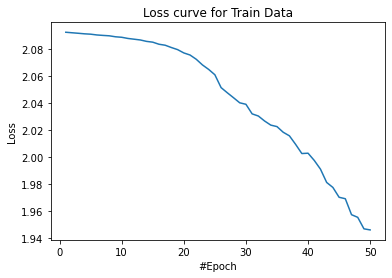

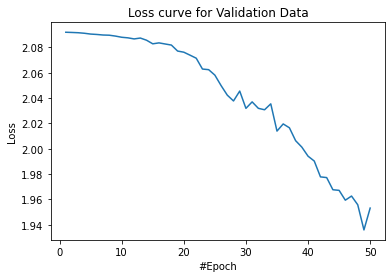

In [357]:
model.plot_loss_curve(0)
model.plot_loss_curve(1)